# Matching 

## Описание проекта

- разработать алгоритм, который для всех товаров из validation.csv предложит несколько вариантов наиболее похожих товаров из  base;
- оценить качество алгоритма по метрике accuracy@5.



### Описание данных


- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base) и вектор признаков размерностью 72.
- *target.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.



### План работы


1. [Предварительная обработка и ознакомление с данными](#part_1) Загрузить датафремы, провести первичный анализ данных. Наметить план дальнейшей работы с данными. Проверить и устранить наличие пропусков, явных дубликатов. Привести к необходимым типам данных. 
2. [Обучение моделей](#part_2) Подбор гиперпараметров, обучение и выбор наилучшей модели для тестирования.
3. [Тестирование](#part_3). Проверка модели на тестовой выборке.

<a id='part_1'></a>
## Предварительная обработка и ознакомление с данными

In [1]:
!pip install faiss
!pip install catboost


In [2]:
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import faiss
import pickle


from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

pd.set_option('display.max_columns', None)

In [3]:
data_dir = 'C:/Users/tra88/Downloads/data'

df_train = os.path.join(data_dir, 'train.csv')
df_base = os.path.join(data_dir, 'base.csv')
df_validation = os.path.join(data_dir, 'validation.csv')
df_valid_answer = os.path.join(data_dir, 'validation_answer.csv')

train = pd.read_csv(df_train, index_col=0)
base = pd.read_csv(df_base, index_col=0)
valid = pd.read_csv(df_validation, index_col=0)
valid_answer = pd.read_csv(df_valid_answer, index_col=0)

In [4]:
def info_df(df):
    print('*' * 100)
    print(f"Размер: {df.shape}")
    print('*' * 100)
    print(f"Количество явных дубликатов: {df.duplicated().sum()}")
    print('*' * 100)
    print('Кол-во пропусков:')
    print(df.isna().sum().sum())
    print('*' * 100)

In [5]:
info_df(train)

****************************************************************************************************
Размер: (100000, 73)
****************************************************************************************************
Количество явных дубликатов: 0
****************************************************************************************************
Кол-во пропусков:
0
****************************************************************************************************


In [6]:
train.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
68797-query,-115.817894,6.749916,-25.501059,-149.80936,101.77903,-78.698880,-55.065009,13.362562,123.470830,125.81510,-152.370640,-64.698260,-14.431768,37.356415,129.29999,-19.562683,21.276335,-11.452330,-176.46234,-78.593320,-134.27196,997.516929,-65.264590,25.961561,-13.778160,129.425031,-80.030624,17.479609,-99.988700,161.84583,4.711362,-117.715385,100.112640,-705.567871,40.520752,65.271720,6.481520,-162.57407,-97.950270,-72.033325,-3.922951,-4.391924,-84.52361,111.65410,-48.984100,80.820580,-128.701780,-194.491960,116.475190,18.180702,65.952910,28.683893,68.55374,-30.187119,84.229225,69.880486,-145.14278,1.476704,-247.119770,-436.803556,-8.279297,-138.86641,2.903214,39.099472,-174.221540,-85.341486,68.809320,2.403024,71.68394,136.72188,39.299615,-108.378900,1658908-base
57022-query,-126.893906,11.487166,-27.829672,-137.20798,97.55910,-108.257385,-67.164535,36.357260,112.217770,227.42694,-115.251630,-88.203575,-5.646969,-29.776052,238.03769,-25.977287,-0.673440,-12.077398,-134.34960,-78.747820,-97.91242,1507.231274,-4.079795,152.657260,19.288849,813.770071,-110.089420,18.780054,5.802284,146.97057,-34.946358,-74.967820,75.914560,-735.671365,-32.387257,82.590065,31.770473,-140.64308,-115.458275,-40.881943,-20.323960,-4.261700,-108.55155,178.65466,-32.792688,49.474430,-181.824190,-135.312820,29.918638,-50.046436,4.636583,-45.835030,78.87239,-23.256866,92.491050,84.161440,-129.22804,-5.484119,-135.911900,-247.246774,-85.201490,-136.11537,-101.876740,48.785210,-137.975100,4.756387,68.277054,-16.630283,115.78911,111.21881,-263.978715,-29.584713,122319-base
51894-query,-60.779480,6.269524,-43.108240,-141.74920,126.40401,-59.548670,-698.822405,17.093520,112.518110,116.35292,-36.791977,5.045166,-30.683730,49.180405,166.77870,-7.280819,-8.403845,46.573975,-164.04976,-78.930720,-175.25330,1507.231274,-12.399492,80.202736,-21.390423,813.770071,-77.780785,11.764822,4.044228,169.56274,-31.287807,-200.580100,85.907005,-735.671365,47.081135,72.459100,-6.548053,-151.83214,-132.905010,-46.806290,-12.454708,2.571900,-157.33525,147.28731,-23.160631,98.357670,-79.707720,-211.837510,58.089720,-61.431484,-63.129154,1.474333,70.12950,-42.213920,86.484610,68.580160,-132.53360,-41.215855,-113.797060,-632.588702,-17.523117,-141.19685,-115.905710,43.502970,-111.928085,100.203457,67.102270,28.839424,40.92096,117.07554,-697.178902,-61.855656,160004-base
48987-query,-92.038670,2.649814,-76.733180,-152.72766,79.57689,-67.338500,-759.626065,-106.046160,112.921906,143.93575,-111.034996,-158.181730,-31.732506,-48.808600,193.41902,-8.209568,19.069040,-20.011093,-86.60808,-80.383354,-57.21281,1507.231274,-160.400790,23.285702,-20.079243,813.770071,-68.337920,10.391928,-59.164528,141.87346,-4.207052,-163.277860,103.243610,-442.657407,33.497066,86.159840,-44.137573,-149.56313,-112.532670,-39.577805,-21.868668,-4.270722,-116.08563,129.93356,-23.354697,31.342575,-27.051498,-139.861530,10.293610,2.333832,3.492506,-21.095095,91.48312,-25.950280,86.598170,56.987280,-132.94716,111.104950,-156.668090,-535.590607,-0.200119,-126.22461,-73.273445,24.403925,-196.734740,-49.281885,66.544350,16.719707,74.62694,129.44678,-89.579939,-53.786324,1452445-base
23539-query,-89.505820,1.604171,-109.245480,-121.15003,91.79341,-67.485600,74.683672,-68.447716,124.307120,234.15248,-130.751460,31.391113,-37.088180,-20.321060,195.21065,-21.539507,-30.542406,-109.750885,-210.45146,-79.348785,-83.43665,1507.231274,-26.959377,2.432648,56.902424,79.869643,-79.721344,13.695191,-87.415340,158.83307,18.020596,-202.198670,71.716410,-325.840547,-26.152176,87.954310,23.740456,-158.10452,-130.227660,-73.426680,5.661936,1.378597,-98.20507,113.97518,-61.898416,20.645775,-75.931180,-117.769394,17.563362,-97.430960,-1.

In [7]:
info_df(base)

****************************************************************************************************
Размер: (2918139, 72)
****************************************************************************************************
Количество явных дубликатов: 0
****************************************************************************************************
Кол-во пропусков:
0
****************************************************************************************************


In [8]:
base.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2179137-base,-109.56738,6.536692,4.065414,-151.16275,62.308628,-95.000500,-591.333142,-51.672424,116.63703,157.901630,-135.55603,-52.247646,-55.182755,5.569667,219.19270,-21.513958,-7.887168,-47.761974,-183.404360,-79.83556,-107.429530,1507.231274,26.629696,81.952540,16.573175,813.770071,-101.600746,32.675632,-182.756770,150.19939,0.181928,-145.429960,128.295530,-779.483261,84.271614,56.282220,-5.386016,-139.55028,-132.12685,-18.006900,-6.933455,16.371395,-219.043980,151.859910,-23.065647,24.933800,-56.391037,-141.96776,-43.535725,-11.822004,76.453156,-61.740830,63.882927,-113.644455,87.485794,66.674810,-127.614174,32.601994,-136.211820,-557.364287,-169.400120,-130.494810,-98.598915,48.744170,-100.600075,176.760644,68.332825,5.311706,108.110120,132.767610,-1044.917921,-24.786728
2856573-base,-69.83606,10.897941,-60.537600,-143.95100,76.692430,-80.363200,28.790487,23.610910,128.16153,153.563230,-158.64745,-18.857178,-12.482376,-44.278175,155.57286,-14.467588,-10.191544,-95.499500,-58.496773,-79.33417,-77.158966,1507.231274,-25.237972,44.219154,26.000126,813.770071,-10.955090,20.073326,-65.529070,154.22690,-30.513596,-147.158250,64.080444,-366.139446,24.510601,73.626976,-29.748617,-151.20789,-128.76154,-44.482350,-6.690158,1.175772,-88.178240,95.659000,-17.013523,85.427170,-154.745830,-73.98631,69.914480,-24.508316,48.447094,-31.413548,75.223785,-101.568030,88.278870,57.830513,-124.167370,35.520092,-140.157000,46.474269,-29.152874,-127.134254,-81.835846,62.497650,-164.498260,-145.074665,67.298200,8.730289,68.819740,119.202240,-1074.464888,-36.778946
3822446-base,-110.93306,4.261099,17.538490,-148.05916,100.047760,-60.888400,-780.753475,11.370760,120.07349,200.788510,-120.79556,-105.712800,-14.852575,-13.728003,121.33722,-42.907143,-7.448431,30.280640,-190.205520,-78.35713,-116.052480,1507.231274,35.182907,77.019420,35.766983,455.925460,-34.638023,16.338625,-59.342155,168.49060,-31.946110,-100.489456,89.664190,-261.894320,-0.742973,131.918330,34.773422,-169.54376,-124.28186,-42.013798,-3.434376,10.469143,-47.891750,121.592060,-30.090134,22.286621,80.354420,-286.28015,-25.877956,-63.799110,180.573970,59.378440,68.549250,-190.726520,91.382900,71.836754,-136.719700,21.702490,-153.999200,46.857261,-98.814070,-133.910130,-77.396515,13.636419,-183.774930,-108.378999,68.327450,128.852170,58.326294,100.439384,-1074.464888,-34.810500
2671047-base,-85.78701,-0.398808,61.711730,-145.46484,116.082985,-63.972706,-189.010707,5.221427,133.10568,62.384660,-186.15167,-82.984886,-97.456820,-18.530773,152.20123,-13.914211,5.887905,-45.337612,-126.817406,-79.39993,-46.375893,1507.231274,0.310896,54.989180,-35.302177,813.770071,-33.387200,20.115211,-94.642944,141.96901,10.936643,-169.515720,21.553146,-724.968273,36.998306,117.423570,6.062023,-138.03473,-92.89894,-32.742332,-16.185596,8.319376,-78.258865,153.387220,-43.918475,142.167710,-106.243645,-184.60442,73.472570,-55.456790,28.311182,-49.692650,79.500610,-46.434624,80.338720,74.985000,-123.951630,-39.377693,9.702126,-369.368608,-75.986220,-146.275200,-86.324380,21.501781,-174.004120,-141.571282,68.317350,47.461475,2.556648,126.067215,-1074.464888,-101.626755
213830-base,-103.96934,9.406659,-61.352123,-135.18083,13.381462,-69.756930,-423.833952,-100.125440,130.22305,71.454575,-120.33805,-62.062763,-22.222431,-42.214607,146.54146,-21.779863,-7.278437,-35.147330,-84.968445,-78.51219,-85.074770,1507.231274,-23.068161,39.763870,95.254260,791.658445,-138.481580,17.328380,-84.116940,165.98102,-53.805980,-153.745880,76.484420,-981.744544,-41.838610,54.695710,2.027790,-149.73714,-118.76343,-88.065025,-29.415040,8.746045,-120.818310,84.954895,-17.793113,73.402340,-133.523070,-200.20306,105.998886,-74.386795,40.149490,-56.173912,

In [9]:
info_df(valid)

****************************************************************************************************
Размер: (100000, 72)
****************************************************************************************************
Количество явных дубликатов: 0
****************************************************************************************************
Кол-во пропусков:
0
****************************************************************************************************


In [10]:
valid.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
111317-query,-110.502430,5.161118,-53.457825,-164.34680,181.134190,-151.674440,-781.720066,-12.440863,131.227750,109.10225,-127.913130,-55.437744,-16.792944,0.761397,135.585110,-20.164762,-0.761359,-24.963099,-193.04103,-77.931780,-96.400380,1507.231274,40.161480,85.606340,-12.681133,701.226241,-47.698300,20.769579,-135.734190,156.04333,6.786988,-137.84998,134.41626,-972.389585,45.709380,51.313553,-3.739481,-137.58363,-108.28322,-53.722546,-16.915794,3.721591,70.529250,180.98798,-55.608389,18.976223,43.328040,-210.87930,61.560320,-39.681300,37.434216,4.026470,67.444176,-141.613750,88.464160,49.623230,-144.91911,28.364098,-33.235100,-115.559629,0.541817,-119.51458,-142.365130,64.339810,-128.243960,-150.595676,67.917190,10.473818,44.409946,124.459840,-865.530176,-87.897310
186009-query,-79.294920,1.840847,-82.901440,-174.87607,97.534500,-101.445880,18.463242,15.281396,121.563644,201.01428,-32.072517,-27.653255,-36.854702,75.497610,178.893170,-35.554028,14.023264,-40.883810,-136.69698,-79.203460,-118.351730,1507.231274,-27.137587,71.189760,22.097797,813.770071,-49.712627,19.601196,-121.790520,126.42482,-38.768658,-175.56708,143.27347,-839.597613,63.799904,100.470500,0.331925,-151.03520,-108.96023,-28.377054,-5.709855,11.133362,-150.042420,206.44748,-61.441417,9.556984,-56.563840,-174.84279,85.667480,-71.550630,-43.459614,37.822020,49.157580,-142.076610,86.325480,57.815937,-133.62872,76.810410,-205.134460,-460.105579,-117.174730,-127.35137,-61.050545,34.415360,-120.723210,-156.455917,65.731800,-28.371815,41.028778,78.750520,-726.444319,-22.370708
173375-query,-68.804640,11.824472,6.314960,-145.50514,31.903160,-96.353570,-669.854290,96.790726,119.532510,126.77643,-114.301440,-97.172930,-76.027130,-9.807310,176.992630,-29.552027,30.891724,-4.039787,-136.14975,-78.644516,-109.073326,1507.231274,-21.009565,26.522503,63.723164,196.566104,-150.640180,8.468187,-121.763130,164.63014,-32.389088,-159.76776,88.45610,-328.463253,48.952927,46.737700,-14.198963,-146.38695,-118.70803,-56.864315,-17.422771,-0.461264,-133.915560,152.63763,-61.898416,81.688130,-66.034090,-138.25099,47.665527,7.441040,53.186480,-29.944256,45.530968,-103.208010,81.101944,71.712685,-154.89438,86.498100,-98.642350,-271.486879,-174.778900,-140.97478,-48.760220,4.513405,-101.458954,-82.340944,68.129616,60.894250,19.558770,116.022514,-1074.464888,45.784480
190094-query,-88.341995,2.608436,-81.036476,-141.26698,228.568050,-79.175415,-719.822523,2.850815,126.198120,118.23215,-171.427440,-59.916210,-45.666122,-21.586946,104.691605,-2.579746,10.924357,-4.412912,-176.89096,-79.156730,-72.874800,285.664113,34.894817,34.075977,-3.971481,813.770071,82.422530,26.169346,-69.532555,179.83105,-68.864240,-151.35033,97.76923,-683.197634,24.010527,107.472440,-37.053947,-147.58968,-112.78697,-27.858082,-9.464991,5.646776,-96.832306,163.98929,-44.260977,5.938751,-55.309467,-86.37505,-21.204594,-120.056350,9.563190,-114.756360,58.665670,-116.879140,84.142810,90.880080,-135.53331,12.000389,-99.638380,-87.815744,-79.300160,-135.25192,-67.671486,2.428173,-183.037100,1.603543,66.770480,26.962229,84.884254,141.839630,-1261.767431,-29.871239
124811-query,-25.176155,8.346280,-36.657160,-137.44337,100.578026,-43.907326,-612.823087,-91.392920,123.902680,144.99081,-178.014070,-86.297210,-4.429165,14.023567,125.168304,-7.296211,3.983041,21.950626,-171.36636,-80.942500,-74.640090,1507.231274,-52.026900,55.280933,28.685833,811.892592,-32.897175,20.417948,-98.341930,151.09125,0.497372,-185.67712,90.66639,-260.193556,51.553345,103.352940,-8.782894,-144.42802,-111.88120,-54.565247,-14.883339,18.197060,-113.301710,158.62306,-34.474036,56.560482,-132.599200,-128.12717,-43.572330,-12.077368,2.082974,-141.799040,57.705746,-34.776375

In [11]:
info_df(valid_answer)

****************************************************************************************************
Размер: (100000, 1)
****************************************************************************************************
Количество явных дубликатов: 8498
****************************************************************************************************
Кол-во пропусков:
0
****************************************************************************************************


Загружено 4 датафрейма:
* base содержит 2 918 139 строк  и 72 столбца
* train содержит 100 000 строк и  73 столбца
* valid содержит 100 000 строк и 72 столбца
* valid_answer содержит 100 000 строк и 1 столбец


 Данные во всех столбцах содержат данные ввиде векторов. Пропусков и дубликатов в данных не обнаружено.
 
 Посмотрим на распределение данных в датафрейме train.

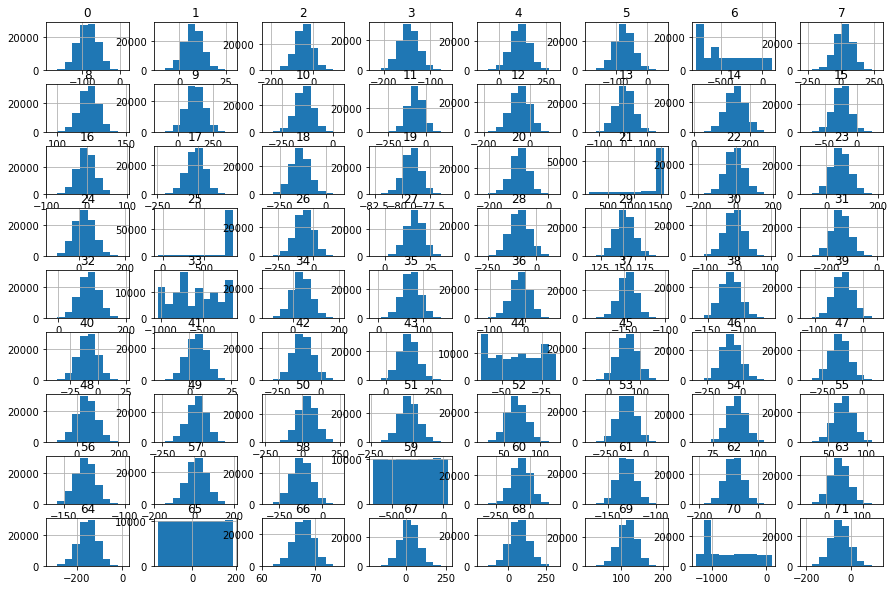

In [12]:
train.hist(figsize=(15, 10))
plt.show()

В большинстве столбцов данные имеют нормальное распределение. Исключение составляют столбцы 21, 25, 59 и 65. Поскольку неизвестно какой именно признак несут данные столбцы, то лучше всего их просто удалить. Удалить в таком случае необходимо во все датафреймах.

In [13]:
# train = train.drop(['59', '65', '25', '21'], axis=1)
# base = base.drop(['59', '65', '25', '21'], axis=1)
# valid = valid.drop(['59', '65', '25', '21'], axis=1)

В датафрейме train имеется столбец с целевым признаком. Его необходимо вынести в отдельную переменную и удалить обучающей выборки.

In [14]:
targets = train["Target"]
train.drop("Target", axis=1, inplace=True)

Данные необходимо отмасштабировать.

In [15]:
train = (train-train.mean ())/train.std()
base = (base-base.mean ())/base.std()
valid = (valid-valid.mean ())/valid.std()

<a id='part_2'></a>
# Обучение моделей

Поставлена задача поиска для каждой позиции из train найти 5 похожих позиций из base. Для решения данной задачи будут использованы два алгоритма:
* faiss - отбираем 20 кандидатов
* CatBoostClassifier - отбираем 5 наиболее подходящих.


 Оценивать качество будем метрикой accuracy@5. На первом этапе модель должна выдавать значение accuracy@5 около 0.8 или больше.

In [16]:
vector_dimension = base.shape[1]
neighbour = 20
nlist = 1024
quantizer = faiss.IndexFlatL2(vector_dimension)
index = faiss.IndexIVFFlat(quantizer, vector_dimension, nlist)
index.train(np.ascontiguousarray(base.values[:50000, :]).astype('float32'))
index.add(np.ascontiguousarray(base.values).astype('float32'))

Создадим словарь на основе base, что в дальнейшем позволит нам указывать какие позиции рекомендуются по запросу.

In [17]:
base_index = {k: v for k, v in enumerate(base.index.to_list())}

In [18]:
filename_b = 'base.pkl'
pickle.dump(base_index, open(filename_b, 'wb'))

In [19]:
index.nprobe = 150
vecs, idx = index.search(train.astype('float32'), neighbour)

In [20]:
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[r] for r in el])

print('accuracy@5:', 100 * acc / len(idx))

accuracy@5: 72.381


Теперь на основе 20 отобранных кандидатов создадим новые признаки и целевой, которые в дальнейшем передаются для дальнейшего отбора 5 кандидатов модели CatBoostClassifier.

In [21]:
def new_features_target(features, target, neighbour, idx):
    matrix = features.astype('float32').values
    new_matrix = np.repeat(matrix, neighbour, axis=0)
    neighbor_features = base.astype('float32').values[idx.flatten()]
    new_features_matrix = np.concatenate((new_matrix, neighbor_features), axis=1)
    
    new_target = []
    for target, el in zip(target.values.tolist(), idx.tolist()):
        temp = []
        for r in el:
            if target in base_index[r]:
                temp.append(1)
            else:
                temp.append(0)
        new_target.extend(temp)
        
    new_matrix = np.concatenate((new_features_matrix, np.array(new_target).reshape(-1, 1)), axis=1)
    np.random.shuffle(new_matrix)
    df = pd.DataFrame(new_matrix)
    
    
    return df

In [22]:
new_df = new_features_target(train, targets, neighbour, idx)

In [23]:
new_target = new_df.iloc[:, -1]  
new_df = new_df.drop(new_df.columns[-1], axis=1)

Разделим созданные признаки и целевой на обучающую и тестовую выборки в соотношении 80/20.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(new_df.values, new_target.values, test_size=0.2, random_state=42)

С помощью GridSearch подберем гиперпараметры для модели CatBooostClassifier на части обучающей выборки.

In [25]:
slice_size = 10000
X_train_slice = X_train[:slice_size]
y_train_slice = y_train[:slice_size]

In [26]:
clf = CatBoostClassifier(random_state=42)

param_grid = {'depth': [4, 6, 8],
              'learning_rate': [0.01, 0.05, 0.1],
              'iterations': [50, 100, 200]}

grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_slice, y_train_slice)
best_params = grid_search.best_params_

0:	learn: 0.6779917	total: 187ms	remaining: 9.16s
1:	learn: 0.6632538	total: 194ms	remaining: 4.67s
2:	learn: 0.6489635	total: 202ms	remaining: 3.17s
3:	learn: 0.6349855	total: 209ms	remaining: 2.4s
4:	learn: 0.6214113	total: 217ms	remaining: 1.95s
5:	learn: 0.6082252	total: 224ms	remaining: 1.64s
6:	learn: 0.5955294	total: 231ms	remaining: 1.42s
7:	learn: 0.5831545	total: 238ms	remaining: 1.25s
8:	learn: 0.5711420	total: 245ms	remaining: 1.12s
9:	learn: 0.5593878	total: 253ms	remaining: 1.01s
10:	learn: 0.5479515	total: 260ms	remaining: 923ms
11:	learn: 0.5369342	total: 267ms	remaining: 846ms
12:	learn: 0.5261122	total: 275ms	remaining: 784ms
13:	learn: 0.5156423	total: 283ms	remaining: 727ms
14:	learn: 0.5054597	total: 290ms	remaining: 677ms
15:	learn: 0.4956085	total: 298ms	remaining: 633ms
16:	learn: 0.4860529	total: 305ms	remaining: 593ms
17:	learn: 0.4767423	total: 313ms	remaining: 557ms
18:	learn: 0.4677159	total: 322ms	remaining: 525ms
19:	learn: 0.4589837	total: 330ms	remainin

29:	learn: 0.3841834	total: 195ms	remaining: 130ms
30:	learn: 0.3778511	total: 201ms	remaining: 123ms
31:	learn: 0.3716776	total: 208ms	remaining: 117ms
32:	learn: 0.3657199	total: 216ms	remaining: 111ms
33:	learn: 0.3599689	total: 223ms	remaining: 105ms
34:	learn: 0.3543992	total: 230ms	remaining: 98.4ms
35:	learn: 0.3489496	total: 236ms	remaining: 91.9ms
36:	learn: 0.3436652	total: 243ms	remaining: 85.3ms
37:	learn: 0.3384764	total: 250ms	remaining: 78.8ms
38:	learn: 0.3335127	total: 256ms	remaining: 72.3ms
39:	learn: 0.3286677	total: 263ms	remaining: 65.7ms
40:	learn: 0.3239634	total: 269ms	remaining: 59ms
41:	learn: 0.3194184	total: 275ms	remaining: 52.4ms
42:	learn: 0.3149858	total: 281ms	remaining: 45.8ms
43:	learn: 0.3106992	total: 288ms	remaining: 39.3ms
44:	learn: 0.3064611	total: 295ms	remaining: 32.8ms
45:	learn: 0.3023794	total: 302ms	remaining: 26.2ms
46:	learn: 0.2984692	total: 309ms	remaining: 19.7ms
47:	learn: 0.2946199	total: 316ms	remaining: 13.2ms
48:	learn: 0.290869

0:	learn: 0.6200792	total: 7.3ms	remaining: 358ms
1:	learn: 0.5570323	total: 14ms	remaining: 335ms
2:	learn: 0.5027896	total: 21ms	remaining: 328ms
3:	learn: 0.4557969	total: 27.8ms	remaining: 320ms
4:	learn: 0.4153848	total: 35ms	remaining: 315ms
5:	learn: 0.3805562	total: 41.9ms	remaining: 307ms
6:	learn: 0.3505052	total: 48.1ms	remaining: 296ms
7:	learn: 0.3249200	total: 53.7ms	remaining: 282ms
8:	learn: 0.3028868	total: 59.5ms	remaining: 271ms
9:	learn: 0.2836482	total: 65.3ms	remaining: 261ms
10:	learn: 0.2670532	total: 71.3ms	remaining: 253ms
11:	learn: 0.2524210	total: 77.4ms	remaining: 245ms
12:	learn: 0.2401208	total: 83.5ms	remaining: 238ms
13:	learn: 0.2294342	total: 89.3ms	remaining: 230ms
14:	learn: 0.2199952	total: 95.9ms	remaining: 224ms
15:	learn: 0.2116418	total: 103ms	remaining: 218ms
16:	learn: 0.2045130	total: 109ms	remaining: 212ms
17:	learn: 0.1982765	total: 116ms	remaining: 206ms
18:	learn: 0.1927234	total: 123ms	remaining: 200ms
19:	learn: 0.1881138	total: 129ms

30:	learn: 0.1439834	total: 196ms	remaining: 120ms
31:	learn: 0.1434668	total: 202ms	remaining: 114ms
32:	learn: 0.1431562	total: 207ms	remaining: 107ms
33:	learn: 0.1427528	total: 213ms	remaining: 100ms
34:	learn: 0.1421795	total: 220ms	remaining: 94.1ms
35:	learn: 0.1416431	total: 225ms	remaining: 87.7ms
36:	learn: 0.1413197	total: 232ms	remaining: 81.4ms
37:	learn: 0.1408430	total: 238ms	remaining: 75.1ms
38:	learn: 0.1401867	total: 244ms	remaining: 68.9ms
39:	learn: 0.1395641	total: 251ms	remaining: 62.7ms
40:	learn: 0.1388021	total: 258ms	remaining: 56.5ms
41:	learn: 0.1384045	total: 264ms	remaining: 50.3ms
42:	learn: 0.1375627	total: 271ms	remaining: 44.1ms
43:	learn: 0.1372488	total: 277ms	remaining: 37.7ms
44:	learn: 0.1362158	total: 282ms	remaining: 31.4ms
45:	learn: 0.1354393	total: 289ms	remaining: 25.1ms
46:	learn: 0.1345737	total: 295ms	remaining: 18.8ms
47:	learn: 0.1342228	total: 301ms	remaining: 12.5ms
48:	learn: 0.1334572	total: 306ms	remaining: 6.24ms
49:	learn: 0.133

0:	learn: 0.5534035	total: 13.1ms	remaining: 644ms
1:	learn: 0.4505187	total: 25.3ms	remaining: 608ms
2:	learn: 0.3752601	total: 32.7ms	remaining: 512ms
3:	learn: 0.3197413	total: 41.1ms	remaining: 473ms
4:	learn: 0.2787856	total: 57.4ms	remaining: 516ms
5:	learn: 0.2486182	total: 66ms	remaining: 484ms
6:	learn: 0.2264259	total: 73.4ms	remaining: 451ms
7:	learn: 0.2097538	total: 80.5ms	remaining: 423ms
8:	learn: 0.1971014	total: 86.9ms	remaining: 396ms
9:	learn: 0.1871525	total: 96ms	remaining: 384ms
10:	learn: 0.1797586	total: 105ms	remaining: 372ms
11:	learn: 0.1732569	total: 112ms	remaining: 356ms
12:	learn: 0.1686939	total: 120ms	remaining: 341ms
13:	learn: 0.1643382	total: 131ms	remaining: 338ms
14:	learn: 0.1616160	total: 140ms	remaining: 327ms
15:	learn: 0.1591364	total: 148ms	remaining: 315ms
16:	learn: 0.1573801	total: 155ms	remaining: 301ms
17:	learn: 0.1552966	total: 161ms	remaining: 286ms
18:	learn: 0.1534659	total: 167ms	remaining: 273ms
19:	learn: 0.1523506	total: 173ms	r

30:	learn: 0.3778305	total: 190ms	remaining: 423ms
31:	learn: 0.3716112	total: 197ms	remaining: 418ms
32:	learn: 0.3656427	total: 203ms	remaining: 413ms
33:	learn: 0.3598381	total: 210ms	remaining: 407ms
34:	learn: 0.3542045	total: 216ms	remaining: 401ms
35:	learn: 0.3487991	total: 222ms	remaining: 395ms
36:	learn: 0.3434584	total: 228ms	remaining: 389ms
37:	learn: 0.3383164	total: 238ms	remaining: 388ms
38:	learn: 0.3333522	total: 246ms	remaining: 385ms
39:	learn: 0.3285119	total: 253ms	remaining: 380ms
40:	learn: 0.3237947	total: 261ms	remaining: 376ms
41:	learn: 0.3191755	total: 268ms	remaining: 370ms
42:	learn: 0.3147771	total: 274ms	remaining: 363ms
43:	learn: 0.3104014	total: 280ms	remaining: 357ms
44:	learn: 0.3062033	total: 286ms	remaining: 349ms
45:	learn: 0.3021353	total: 291ms	remaining: 342ms
46:	learn: 0.2981652	total: 298ms	remaining: 336ms
47:	learn: 0.2943441	total: 305ms	remaining: 331ms
48:	learn: 0.2906282	total: 313ms	remaining: 326ms
49:	learn: 0.2870247	total: 321

91:	learn: 0.1983262	total: 567ms	remaining: 49.3ms
92:	learn: 0.1972409	total: 573ms	remaining: 43.1ms
93:	learn: 0.1961380	total: 579ms	remaining: 36.9ms
94:	learn: 0.1950900	total: 585ms	remaining: 30.8ms
95:	learn: 0.1940641	total: 592ms	remaining: 24.6ms
96:	learn: 0.1930442	total: 598ms	remaining: 18.5ms
97:	learn: 0.1920276	total: 604ms	remaining: 12.3ms
98:	learn: 0.1911143	total: 610ms	remaining: 6.17ms
99:	learn: 0.1902000	total: 617ms	remaining: 0us
0:	learn: 0.6779537	total: 7.52ms	remaining: 744ms
1:	learn: 0.6632167	total: 13.8ms	remaining: 675ms
2:	learn: 0.6488949	total: 20.5ms	remaining: 664ms
3:	learn: 0.6349795	total: 26.9ms	remaining: 646ms
4:	learn: 0.6214154	total: 34.2ms	remaining: 650ms
5:	learn: 0.6082622	total: 41ms	remaining: 642ms
6:	learn: 0.5955200	total: 47.6ms	remaining: 632ms
7:	learn: 0.5831274	total: 53.4ms	remaining: 614ms
8:	learn: 0.5711324	total: 61.2ms	remaining: 619ms
9:	learn: 0.5593220	total: 69.3ms	remaining: 624ms
10:	learn: 0.5479017	total:

60:	learn: 0.2533001	total: 380ms	remaining: 243ms
61:	learn: 0.2507379	total: 386ms	remaining: 236ms
62:	learn: 0.2482354	total: 391ms	remaining: 230ms
63:	learn: 0.2458275	total: 397ms	remaining: 223ms
64:	learn: 0.2434409	total: 402ms	remaining: 217ms
65:	learn: 0.2410732	total: 408ms	remaining: 210ms
66:	learn: 0.2388581	total: 414ms	remaining: 204ms
67:	learn: 0.2367123	total: 419ms	remaining: 197ms
68:	learn: 0.2345684	total: 425ms	remaining: 191ms
69:	learn: 0.2324945	total: 431ms	remaining: 185ms
70:	learn: 0.2304166	total: 437ms	remaining: 178ms
71:	learn: 0.2284841	total: 442ms	remaining: 172ms
72:	learn: 0.2265992	total: 450ms	remaining: 166ms
73:	learn: 0.2247244	total: 456ms	remaining: 160ms
74:	learn: 0.2229519	total: 461ms	remaining: 154ms
75:	learn: 0.2211812	total: 467ms	remaining: 147ms
76:	learn: 0.2194712	total: 473ms	remaining: 141ms
77:	learn: 0.2178232	total: 478ms	remaining: 135ms
78:	learn: 0.2161936	total: 484ms	remaining: 129ms
79:	learn: 0.2146159	total: 490

31:	learn: 0.1606928	total: 198ms	remaining: 421ms
32:	learn: 0.1593139	total: 203ms	remaining: 413ms
33:	learn: 0.1584203	total: 209ms	remaining: 406ms
34:	learn: 0.1570224	total: 215ms	remaining: 400ms
35:	learn: 0.1557733	total: 222ms	remaining: 395ms
36:	learn: 0.1550992	total: 228ms	remaining: 389ms
37:	learn: 0.1544090	total: 234ms	remaining: 382ms
38:	learn: 0.1539012	total: 240ms	remaining: 376ms
39:	learn: 0.1533501	total: 246ms	remaining: 369ms
40:	learn: 0.1524941	total: 253ms	remaining: 364ms
41:	learn: 0.1518119	total: 259ms	remaining: 358ms
42:	learn: 0.1511367	total: 266ms	remaining: 353ms
43:	learn: 0.1502665	total: 273ms	remaining: 347ms
44:	learn: 0.1498661	total: 279ms	remaining: 341ms
45:	learn: 0.1492946	total: 285ms	remaining: 335ms
46:	learn: 0.1485073	total: 291ms	remaining: 328ms
47:	learn: 0.1483052	total: 298ms	remaining: 322ms
48:	learn: 0.1479410	total: 304ms	remaining: 316ms
49:	learn: 0.1475648	total: 310ms	remaining: 310ms
50:	learn: 0.1471863	total: 316

0:	learn: 0.6199756	total: 9.47ms	remaining: 938ms
1:	learn: 0.5569111	total: 15ms	remaining: 734ms
2:	learn: 0.5025539	total: 20.5ms	remaining: 662ms
3:	learn: 0.4557357	total: 26.2ms	remaining: 630ms
4:	learn: 0.4153038	total: 32ms	remaining: 607ms
5:	learn: 0.3807303	total: 37.8ms	remaining: 592ms
6:	learn: 0.3509548	total: 43.8ms	remaining: 581ms
7:	learn: 0.3251189	total: 49.6ms	remaining: 570ms
8:	learn: 0.3029926	total: 55.7ms	remaining: 563ms
9:	learn: 0.2837031	total: 61.9ms	remaining: 557ms
10:	learn: 0.2672587	total: 68ms	remaining: 550ms
11:	learn: 0.2528348	total: 75.3ms	remaining: 552ms
12:	learn: 0.2404145	total: 82.4ms	remaining: 552ms
13:	learn: 0.2295288	total: 88.6ms	remaining: 544ms
14:	learn: 0.2203660	total: 94.4ms	remaining: 535ms
15:	learn: 0.2122798	total: 100ms	remaining: 527ms
16:	learn: 0.2053088	total: 106ms	remaining: 520ms
17:	learn: 0.1992241	total: 112ms	remaining: 511ms
18:	learn: 0.1937445	total: 118ms	remaining: 504ms
19:	learn: 0.1890590	total: 125m

82:	learn: 0.1360379	total: 572ms	remaining: 117ms
83:	learn: 0.1359029	total: 581ms	remaining: 111ms
84:	learn: 0.1353548	total: 588ms	remaining: 104ms
85:	learn: 0.1346983	total: 596ms	remaining: 97.1ms
86:	learn: 0.1345332	total: 604ms	remaining: 90.2ms
87:	learn: 0.1341473	total: 611ms	remaining: 83.4ms
88:	learn: 0.1340531	total: 618ms	remaining: 76.4ms
89:	learn: 0.1339758	total: 626ms	remaining: 69.5ms
90:	learn: 0.1335185	total: 633ms	remaining: 62.6ms
91:	learn: 0.1329698	total: 639ms	remaining: 55.5ms
92:	learn: 0.1328743	total: 645ms	remaining: 48.5ms
93:	learn: 0.1327221	total: 651ms	remaining: 41.5ms
94:	learn: 0.1325959	total: 657ms	remaining: 34.6ms
95:	learn: 0.1324521	total: 664ms	remaining: 27.7ms
96:	learn: 0.1322403	total: 670ms	remaining: 20.7ms
97:	learn: 0.1321114	total: 676ms	remaining: 13.8ms
98:	learn: 0.1314911	total: 682ms	remaining: 6.88ms
99:	learn: 0.1313327	total: 687ms	remaining: 0us
0:	learn: 0.5540016	total: 6.35ms	remaining: 628ms
1:	learn: 0.4512679

60:	learn: 0.1310033	total: 370ms	remaining: 236ms
61:	learn: 0.1301132	total: 376ms	remaining: 230ms
62:	learn: 0.1298587	total: 381ms	remaining: 224ms
63:	learn: 0.1282348	total: 387ms	remaining: 218ms
64:	learn: 0.1278945	total: 394ms	remaining: 212ms
65:	learn: 0.1275499	total: 401ms	remaining: 207ms
66:	learn: 0.1270645	total: 407ms	remaining: 201ms
67:	learn: 0.1264807	total: 413ms	remaining: 194ms
68:	learn: 0.1262413	total: 419ms	remaining: 188ms
69:	learn: 0.1259844	total: 425ms	remaining: 182ms
70:	learn: 0.1246317	total: 432ms	remaining: 176ms
71:	learn: 0.1243616	total: 438ms	remaining: 170ms
72:	learn: 0.1234114	total: 444ms	remaining: 164ms
73:	learn: 0.1227856	total: 449ms	remaining: 158ms
74:	learn: 0.1223006	total: 455ms	remaining: 152ms
75:	learn: 0.1220800	total: 461ms	remaining: 145ms
76:	learn: 0.1217786	total: 467ms	remaining: 139ms
77:	learn: 0.1212619	total: 472ms	remaining: 133ms
78:	learn: 0.1203189	total: 478ms	remaining: 127ms
79:	learn: 0.1200964	total: 484

31:	learn: 0.1425407	total: 198ms	remaining: 420ms
32:	learn: 0.1421070	total: 204ms	remaining: 414ms
33:	learn: 0.1418381	total: 210ms	remaining: 407ms
34:	learn: 0.1400710	total: 216ms	remaining: 401ms
35:	learn: 0.1396826	total: 222ms	remaining: 395ms
36:	learn: 0.1393149	total: 228ms	remaining: 388ms
37:	learn: 0.1382988	total: 235ms	remaining: 383ms
38:	learn: 0.1380085	total: 240ms	remaining: 376ms
39:	learn: 0.1377778	total: 246ms	remaining: 369ms
40:	learn: 0.1373021	total: 252ms	remaining: 363ms
41:	learn: 0.1361540	total: 258ms	remaining: 356ms
42:	learn: 0.1356960	total: 263ms	remaining: 349ms
43:	learn: 0.1353125	total: 269ms	remaining: 343ms
44:	learn: 0.1347534	total: 275ms	remaining: 336ms
45:	learn: 0.1337750	total: 281ms	remaining: 329ms
46:	learn: 0.1333764	total: 287ms	remaining: 324ms
47:	learn: 0.1325724	total: 293ms	remaining: 318ms
48:	learn: 0.1324024	total: 300ms	remaining: 312ms
49:	learn: 0.1320800	total: 307ms	remaining: 307ms
50:	learn: 0.1315963	total: 313

0:	learn: 0.6779917	total: 6.89ms	remaining: 1.37s
1:	learn: 0.6632538	total: 12.4ms	remaining: 1.23s
2:	learn: 0.6489635	total: 18ms	remaining: 1.18s
3:	learn: 0.6349855	total: 23.1ms	remaining: 1.13s
4:	learn: 0.6214113	total: 28.8ms	remaining: 1.12s
5:	learn: 0.6082252	total: 34.5ms	remaining: 1.11s
6:	learn: 0.5955294	total: 39.8ms	remaining: 1.1s
7:	learn: 0.5831545	total: 46.4ms	remaining: 1.11s
8:	learn: 0.5711420	total: 52.1ms	remaining: 1.1s
9:	learn: 0.5593878	total: 57.7ms	remaining: 1.1s
10:	learn: 0.5479515	total: 63.6ms	remaining: 1.09s
11:	learn: 0.5369342	total: 69.1ms	remaining: 1.08s
12:	learn: 0.5261122	total: 74.9ms	remaining: 1.08s
13:	learn: 0.5156423	total: 81.4ms	remaining: 1.08s
14:	learn: 0.5054597	total: 88ms	remaining: 1.08s
15:	learn: 0.4956085	total: 94.3ms	remaining: 1.08s
16:	learn: 0.4860529	total: 100ms	remaining: 1.08s
17:	learn: 0.4767423	total: 106ms	remaining: 1.07s
18:	learn: 0.4677159	total: 113ms	remaining: 1.08s
19:	learn: 0.4589837	total: 119m

177:	learn: 0.1567251	total: 1.1s	remaining: 136ms
178:	learn: 0.1565769	total: 1.1s	remaining: 130ms
179:	learn: 0.1564286	total: 1.11s	remaining: 123ms
180:	learn: 0.1562570	total: 1.12s	remaining: 117ms
181:	learn: 0.1561217	total: 1.12s	remaining: 111ms
182:	learn: 0.1559934	total: 1.13s	remaining: 105ms
183:	learn: 0.1557942	total: 1.14s	remaining: 98.7ms
184:	learn: 0.1556452	total: 1.14s	remaining: 92.6ms
185:	learn: 0.1555143	total: 1.15s	remaining: 86.4ms
186:	learn: 0.1553478	total: 1.15s	remaining: 80.2ms
187:	learn: 0.1551217	total: 1.16s	remaining: 74ms
188:	learn: 0.1549000	total: 1.17s	remaining: 67.9ms
189:	learn: 0.1547423	total: 1.17s	remaining: 61.7ms
190:	learn: 0.1546277	total: 1.18s	remaining: 55.6ms
191:	learn: 0.1544157	total: 1.19s	remaining: 49.4ms
192:	learn: 0.1543090	total: 1.19s	remaining: 43.2ms
193:	learn: 0.1541963	total: 1.2s	remaining: 37.1ms
194:	learn: 0.1540963	total: 1.2s	remaining: 30.9ms
195:	learn: 0.1539095	total: 1.21s	remaining: 24.7ms
196:	

149:	learn: 0.1634998	total: 927ms	remaining: 309ms
150:	learn: 0.1632287	total: 933ms	remaining: 303ms
151:	learn: 0.1629441	total: 939ms	remaining: 297ms
152:	learn: 0.1626552	total: 946ms	remaining: 290ms
153:	learn: 0.1623603	total: 951ms	remaining: 284ms
154:	learn: 0.1621216	total: 957ms	remaining: 278ms
155:	learn: 0.1618948	total: 964ms	remaining: 272ms
156:	learn: 0.1616547	total: 970ms	remaining: 266ms
157:	learn: 0.1614100	total: 976ms	remaining: 259ms
158:	learn: 0.1611938	total: 981ms	remaining: 253ms
159:	learn: 0.1609838	total: 987ms	remaining: 247ms
160:	learn: 0.1606966	total: 994ms	remaining: 241ms
161:	learn: 0.1604840	total: 1s	remaining: 235ms
162:	learn: 0.1602562	total: 1.01s	remaining: 229ms
163:	learn: 0.1600538	total: 1.01s	remaining: 222ms
164:	learn: 0.1598542	total: 1.02s	remaining: 216ms
165:	learn: 0.1596388	total: 1.02s	remaining: 210ms
166:	learn: 0.1594418	total: 1.03s	remaining: 204ms
167:	learn: 0.1591537	total: 1.04s	remaining: 198ms
168:	learn: 0.1

115:	learn: 0.1781150	total: 733ms	remaining: 531ms
116:	learn: 0.1773266	total: 740ms	remaining: 525ms
117:	learn: 0.1766637	total: 746ms	remaining: 518ms
118:	learn: 0.1760795	total: 752ms	remaining: 512ms
119:	learn: 0.1755064	total: 758ms	remaining: 505ms
120:	learn: 0.1749730	total: 764ms	remaining: 499ms
121:	learn: 0.1744455	total: 769ms	remaining: 492ms
122:	learn: 0.1739195	total: 775ms	remaining: 485ms
123:	learn: 0.1734064	total: 781ms	remaining: 479ms
124:	learn: 0.1729186	total: 787ms	remaining: 472ms
125:	learn: 0.1724314	total: 794ms	remaining: 466ms
126:	learn: 0.1719785	total: 800ms	remaining: 460ms
127:	learn: 0.1715167	total: 807ms	remaining: 454ms
128:	learn: 0.1710763	total: 813ms	remaining: 447ms
129:	learn: 0.1704725	total: 819ms	remaining: 441ms
130:	learn: 0.1700430	total: 825ms	remaining: 435ms
131:	learn: 0.1696158	total: 831ms	remaining: 428ms
132:	learn: 0.1692142	total: 836ms	remaining: 421ms
133:	learn: 0.1687976	total: 842ms	remaining: 415ms
134:	learn: 

90:	learn: 0.1998903	total: 564ms	remaining: 675ms
91:	learn: 0.1986662	total: 570ms	remaining: 669ms
92:	learn: 0.1975656	total: 576ms	remaining: 663ms
93:	learn: 0.1964998	total: 582ms	remaining: 657ms
94:	learn: 0.1954464	total: 589ms	remaining: 651ms
95:	learn: 0.1943039	total: 597ms	remaining: 646ms
96:	learn: 0.1933357	total: 603ms	remaining: 640ms
97:	learn: 0.1923342	total: 609ms	remaining: 634ms
98:	learn: 0.1913672	total: 615ms	remaining: 628ms
99:	learn: 0.1904373	total: 621ms	remaining: 621ms
100:	learn: 0.1895323	total: 627ms	remaining: 615ms
101:	learn: 0.1886528	total: 633ms	remaining: 608ms
102:	learn: 0.1877895	total: 639ms	remaining: 601ms
103:	learn: 0.1869903	total: 644ms	remaining: 594ms
104:	learn: 0.1861712	total: 652ms	remaining: 589ms
105:	learn: 0.1853595	total: 658ms	remaining: 584ms
106:	learn: 0.1845930	total: 664ms	remaining: 577ms
107:	learn: 0.1837925	total: 670ms	remaining: 570ms
108:	learn: 0.1830407	total: 675ms	remaining: 564ms
109:	learn: 0.1823369	

56:	learn: 0.2643545	total: 368ms	remaining: 924ms
57:	learn: 0.2615021	total: 374ms	remaining: 915ms
58:	learn: 0.2586856	total: 380ms	remaining: 908ms
59:	learn: 0.2559524	total: 386ms	remaining: 900ms
60:	learn: 0.2533001	total: 394ms	remaining: 899ms
61:	learn: 0.2507379	total: 402ms	remaining: 895ms
62:	learn: 0.2482354	total: 409ms	remaining: 890ms
63:	learn: 0.2458275	total: 416ms	remaining: 883ms
64:	learn: 0.2434409	total: 422ms	remaining: 877ms
65:	learn: 0.2410732	total: 432ms	remaining: 877ms
66:	learn: 0.2388581	total: 440ms	remaining: 873ms
67:	learn: 0.2367123	total: 454ms	remaining: 881ms
68:	learn: 0.2345684	total: 461ms	remaining: 875ms
69:	learn: 0.2324945	total: 468ms	remaining: 868ms
70:	learn: 0.2304166	total: 474ms	remaining: 861ms
71:	learn: 0.2284841	total: 480ms	remaining: 853ms
72:	learn: 0.2265992	total: 487ms	remaining: 847ms
73:	learn: 0.2247244	total: 493ms	remaining: 839ms
74:	learn: 0.2229519	total: 499ms	remaining: 832ms
75:	learn: 0.2211812	total: 505

30:	learn: 0.1609316	total: 195ms	remaining: 1.06s
31:	learn: 0.1598494	total: 201ms	remaining: 1.05s
32:	learn: 0.1587872	total: 206ms	remaining: 1.04s
33:	learn: 0.1578967	total: 213ms	remaining: 1.04s
34:	learn: 0.1569122	total: 219ms	remaining: 1.03s
35:	learn: 0.1551003	total: 226ms	remaining: 1.03s
36:	learn: 0.1544235	total: 232ms	remaining: 1.02s
37:	learn: 0.1539086	total: 239ms	remaining: 1.02s
38:	learn: 0.1529098	total: 246ms	remaining: 1.01s
39:	learn: 0.1521745	total: 252ms	remaining: 1.01s
40:	learn: 0.1515407	total: 258ms	remaining: 1s
41:	learn: 0.1509299	total: 265ms	remaining: 995ms
42:	learn: 0.1503855	total: 271ms	remaining: 990ms
43:	learn: 0.1498727	total: 277ms	remaining: 983ms
44:	learn: 0.1489519	total: 284ms	remaining: 978ms
45:	learn: 0.1482825	total: 290ms	remaining: 971ms
46:	learn: 0.1477842	total: 296ms	remaining: 965ms
47:	learn: 0.1470070	total: 302ms	remaining: 958ms
48:	learn: 0.1467002	total: 309ms	remaining: 951ms
49:	learn: 0.1459947	total: 315ms	

0:	learn: 0.6199130	total: 6.66ms	remaining: 1.32s
1:	learn: 0.5567506	total: 12.5ms	remaining: 1.23s
2:	learn: 0.5024879	total: 18.9ms	remaining: 1.24s
3:	learn: 0.4557499	total: 24.8ms	remaining: 1.22s
4:	learn: 0.4154465	total: 31.7ms	remaining: 1.24s
5:	learn: 0.3809300	total: 37.8ms	remaining: 1.22s
6:	learn: 0.3509622	total: 43.3ms	remaining: 1.19s
7:	learn: 0.3252975	total: 49.2ms	remaining: 1.18s
8:	learn: 0.3030785	total: 54.7ms	remaining: 1.16s
9:	learn: 0.2839461	total: 60.6ms	remaining: 1.15s
10:	learn: 0.2675309	total: 66.7ms	remaining: 1.15s
11:	learn: 0.2530647	total: 72.8ms	remaining: 1.14s
12:	learn: 0.2405328	total: 79.4ms	remaining: 1.14s
13:	learn: 0.2297507	total: 85.9ms	remaining: 1.14s
14:	learn: 0.2205019	total: 92.7ms	remaining: 1.14s
15:	learn: 0.2124521	total: 99.8ms	remaining: 1.15s
16:	learn: 0.2054478	total: 106ms	remaining: 1.14s
17:	learn: 0.1993753	total: 112ms	remaining: 1.13s
18:	learn: 0.1939894	total: 117ms	remaining: 1.12s
19:	learn: 0.1890664	tota

179:	learn: 0.1139138	total: 1.1s	remaining: 123ms
180:	learn: 0.1136196	total: 1.11s	remaining: 117ms
181:	learn: 0.1135497	total: 1.12s	remaining: 111ms
182:	learn: 0.1133277	total: 1.12s	remaining: 104ms
183:	learn: 0.1132113	total: 1.13s	remaining: 98.2ms
184:	learn: 0.1131269	total: 1.14s	remaining: 92.1ms
185:	learn: 0.1129803	total: 1.14s	remaining: 85.9ms
186:	learn: 0.1127326	total: 1.15s	remaining: 79.8ms
187:	learn: 0.1124922	total: 1.15s	remaining: 73.6ms
188:	learn: 0.1122496	total: 1.16s	remaining: 67.5ms
189:	learn: 0.1118450	total: 1.16s	remaining: 61.3ms
190:	learn: 0.1117451	total: 1.17s	remaining: 55.2ms
191:	learn: 0.1115442	total: 1.18s	remaining: 49ms
192:	learn: 0.1114137	total: 1.18s	remaining: 42.9ms
193:	learn: 0.1113007	total: 1.19s	remaining: 36.7ms
194:	learn: 0.1111683	total: 1.19s	remaining: 30.6ms
195:	learn: 0.1109993	total: 1.2s	remaining: 24.5ms
196:	learn: 0.1109223	total: 1.2s	remaining: 18.3ms
197:	learn: 0.1107829	total: 1.21s	remaining: 12.2ms
19

145:	learn: 0.1202439	total: 929ms	remaining: 343ms
146:	learn: 0.1199592	total: 935ms	remaining: 337ms
147:	learn: 0.1196642	total: 941ms	remaining: 331ms
148:	learn: 0.1194803	total: 947ms	remaining: 324ms
149:	learn: 0.1193500	total: 954ms	remaining: 318ms
150:	learn: 0.1191525	total: 960ms	remaining: 311ms
151:	learn: 0.1188656	total: 966ms	remaining: 305ms
152:	learn: 0.1185860	total: 973ms	remaining: 299ms
153:	learn: 0.1179590	total: 979ms	remaining: 292ms
154:	learn: 0.1175541	total: 986ms	remaining: 286ms
155:	learn: 0.1173590	total: 992ms	remaining: 280ms
156:	learn: 0.1172568	total: 999ms	remaining: 274ms
157:	learn: 0.1171061	total: 1s	remaining: 267ms
158:	learn: 0.1169761	total: 1.01s	remaining: 261ms
159:	learn: 0.1168211	total: 1.02s	remaining: 255ms
160:	learn: 0.1166833	total: 1.02s	remaining: 248ms
161:	learn: 0.1163206	total: 1.03s	remaining: 242ms
162:	learn: 0.1162410	total: 1.04s	remaining: 235ms
163:	learn: 0.1157615	total: 1.04s	remaining: 229ms
164:	learn: 0.1

121:	learn: 0.1281929	total: 747ms	remaining: 478ms
122:	learn: 0.1280086	total: 753ms	remaining: 471ms
123:	learn: 0.1276456	total: 759ms	remaining: 465ms
124:	learn: 0.1270726	total: 764ms	remaining: 459ms
125:	learn: 0.1269762	total: 772ms	remaining: 453ms
126:	learn: 0.1264303	total: 779ms	remaining: 448ms
127:	learn: 0.1263167	total: 784ms	remaining: 441ms
128:	learn: 0.1262086	total: 789ms	remaining: 434ms
129:	learn: 0.1258737	total: 795ms	remaining: 428ms
130:	learn: 0.1250627	total: 800ms	remaining: 422ms
131:	learn: 0.1248918	total: 806ms	remaining: 415ms
132:	learn: 0.1245263	total: 812ms	remaining: 409ms
133:	learn: 0.1242807	total: 817ms	remaining: 402ms
134:	learn: 0.1239473	total: 823ms	remaining: 396ms
135:	learn: 0.1237633	total: 828ms	remaining: 390ms
136:	learn: 0.1235605	total: 834ms	remaining: 383ms
137:	learn: 0.1232135	total: 839ms	remaining: 377ms
138:	learn: 0.1231033	total: 845ms	remaining: 371ms
139:	learn: 0.1229747	total: 850ms	remaining: 364ms
140:	learn: 

94:	learn: 0.1325959	total: 562ms	remaining: 621ms
95:	learn: 0.1324521	total: 567ms	remaining: 615ms
96:	learn: 0.1322403	total: 573ms	remaining: 608ms
97:	learn: 0.1321114	total: 578ms	remaining: 602ms
98:	learn: 0.1314911	total: 584ms	remaining: 596ms
99:	learn: 0.1313327	total: 590ms	remaining: 590ms
100:	learn: 0.1312138	total: 595ms	remaining: 584ms
101:	learn: 0.1308661	total: 601ms	remaining: 578ms
102:	learn: 0.1307342	total: 607ms	remaining: 571ms
103:	learn: 0.1303422	total: 612ms	remaining: 565ms
104:	learn: 0.1299596	total: 618ms	remaining: 559ms
105:	learn: 0.1295819	total: 623ms	remaining: 553ms
106:	learn: 0.1293785	total: 629ms	remaining: 547ms
107:	learn: 0.1289806	total: 635ms	remaining: 541ms
108:	learn: 0.1288866	total: 640ms	remaining: 534ms
109:	learn: 0.1287728	total: 645ms	remaining: 528ms
110:	learn: 0.1286122	total: 651ms	remaining: 522ms
111:	learn: 0.1284805	total: 656ms	remaining: 516ms
112:	learn: 0.1283570	total: 662ms	remaining: 510ms
113:	learn: 0.1279

54:	learn: 0.1308860	total: 1.63s	remaining: 4.3s
55:	learn: 0.1305131	total: 1.65s	remaining: 4.25s
56:	learn: 0.1302860	total: 1.67s	remaining: 4.2s
57:	learn: 0.1299900	total: 1.7s	remaining: 4.15s
58:	learn: 0.1296856	total: 1.72s	remaining: 4.11s
59:	learn: 0.1294123	total: 1.74s	remaining: 4.07s
60:	learn: 0.1290607	total: 1.77s	remaining: 4.03s
61:	learn: 0.1287135	total: 1.8s	remaining: 4s
62:	learn: 0.1283799	total: 1.82s	remaining: 3.96s
63:	learn: 0.1279824	total: 1.84s	remaining: 3.92s
64:	learn: 0.1277141	total: 1.87s	remaining: 3.88s
65:	learn: 0.1272596	total: 1.89s	remaining: 3.84s
66:	learn: 0.1270044	total: 1.92s	remaining: 3.8s
67:	learn: 0.1265232	total: 1.94s	remaining: 3.77s
68:	learn: 0.1262535	total: 1.97s	remaining: 3.73s
69:	learn: 0.1258773	total: 2s	remaining: 3.71s
70:	learn: 0.1256896	total: 2.02s	remaining: 3.67s
71:	learn: 0.1252926	total: 2.04s	remaining: 3.63s
72:	learn: 0.1250953	total: 2.06s	remaining: 3.59s
73:	learn: 0.1249311	total: 2.08s	remainin

17:	learn: 0.1563447	total: 484ms	remaining: 4.89s
18:	learn: 0.1543015	total: 522ms	remaining: 4.97s
19:	learn: 0.1524892	total: 563ms	remaining: 5.06s
20:	learn: 0.1511860	total: 602ms	remaining: 5.13s
21:	learn: 0.1503130	total: 627ms	remaining: 5.08s
22:	learn: 0.1489865	total: 655ms	remaining: 5.04s
23:	learn: 0.1482048	total: 689ms	remaining: 5.05s
24:	learn: 0.1475378	total: 717ms	remaining: 5.02s
25:	learn: 0.1470703	total: 738ms	remaining: 4.94s
26:	learn: 0.1463209	total: 765ms	remaining: 4.9s
27:	learn: 0.1447112	total: 802ms	remaining: 4.92s
28:	learn: 0.1443096	total: 829ms	remaining: 4.88s
29:	learn: 0.1439027	total: 851ms	remaining: 4.82s
30:	learn: 0.1436425	total: 872ms	remaining: 4.75s
31:	learn: 0.1428278	total: 893ms	remaining: 4.69s
32:	learn: 0.1420800	total: 917ms	remaining: 4.64s
33:	learn: 0.1412580	total: 945ms	remaining: 4.62s
34:	learn: 0.1408368	total: 968ms	remaining: 4.56s
35:	learn: 0.1405059	total: 990ms	remaining: 4.51s
36:	learn: 0.1401342	total: 1.01

195:	learn: 0.0830466	total: 3.39s	remaining: 69.1ms
196:	learn: 0.0828955	total: 3.39s	remaining: 51.7ms
197:	learn: 0.0827431	total: 3.4s	remaining: 34.3ms
198:	learn: 0.0823700	total: 3.41s	remaining: 17.1ms
199:	learn: 0.0817342	total: 3.41s	remaining: 0us
0:	learn: 0.5538628	total: 47ms	remaining: 9.36s
1:	learn: 0.4512091	total: 69.5ms	remaining: 6.88s
2:	learn: 0.3759527	total: 101ms	remaining: 6.63s
3:	learn: 0.3203016	total: 125ms	remaining: 6.11s
4:	learn: 0.2793812	total: 149ms	remaining: 5.81s
5:	learn: 0.2490203	total: 182ms	remaining: 5.88s
6:	learn: 0.2262780	total: 227ms	remaining: 6.27s
7:	learn: 0.2095547	total: 278ms	remaining: 6.67s
8:	learn: 0.1963678	total: 320ms	remaining: 6.78s
9:	learn: 0.1866090	total: 357ms	remaining: 6.79s
10:	learn: 0.1794633	total: 394ms	remaining: 6.76s
11:	learn: 0.1732936	total: 441ms	remaining: 6.91s
12:	learn: 0.1688251	total: 485ms	remaining: 6.97s
13:	learn: 0.1654656	total: 516ms	remaining: 6.85s
14:	learn: 0.1628070	total: 550ms	r

184:	learn: 0.0761815	total: 2.63s	remaining: 214ms
185:	learn: 0.0760237	total: 2.64s	remaining: 199ms
186:	learn: 0.0754719	total: 2.65s	remaining: 184ms
187:	learn: 0.0753329	total: 2.65s	remaining: 169ms
188:	learn: 0.0751357	total: 2.66s	remaining: 155ms
189:	learn: 0.0748992	total: 2.67s	remaining: 140ms
190:	learn: 0.0746543	total: 2.67s	remaining: 126ms
191:	learn: 0.0745297	total: 2.68s	remaining: 112ms
192:	learn: 0.0742604	total: 2.68s	remaining: 97.3ms
193:	learn: 0.0741834	total: 2.69s	remaining: 83.2ms
194:	learn: 0.0738298	total: 2.7s	remaining: 69.2ms
195:	learn: 0.0737123	total: 2.7s	remaining: 55.2ms
196:	learn: 0.0731111	total: 2.71s	remaining: 41.3ms
197:	learn: 0.0728347	total: 2.72s	remaining: 27.4ms
198:	learn: 0.0723957	total: 2.72s	remaining: 13.7ms
199:	learn: 0.0722757	total: 2.73s	remaining: 0us
0:	learn: 0.5536797	total: 6.9ms	remaining: 1.37s
1:	learn: 0.4510162	total: 13.2ms	remaining: 1.3s
2:	learn: 0.3756151	total: 19.4ms	remaining: 1.27s
3:	learn: 0.32

171:	learn: 0.0865729	total: 1.1s	remaining: 180ms
172:	learn: 0.0862428	total: 1.11s	remaining: 173ms
173:	learn: 0.0861018	total: 1.12s	remaining: 167ms
174:	learn: 0.0853773	total: 1.12s	remaining: 161ms
175:	learn: 0.0852084	total: 1.13s	remaining: 154ms
176:	learn: 0.0846577	total: 1.14s	remaining: 148ms
177:	learn: 0.0844833	total: 1.14s	remaining: 141ms
178:	learn: 0.0841121	total: 1.15s	remaining: 135ms
179:	learn: 0.0837787	total: 1.16s	remaining: 128ms
180:	learn: 0.0826280	total: 1.16s	remaining: 122ms
181:	learn: 0.0817578	total: 1.17s	remaining: 116ms
182:	learn: 0.0816092	total: 1.17s	remaining: 109ms
183:	learn: 0.0808684	total: 1.18s	remaining: 103ms
184:	learn: 0.0806454	total: 1.19s	remaining: 96.3ms
185:	learn: 0.0803606	total: 1.19s	remaining: 89.9ms
186:	learn: 0.0801801	total: 1.2s	remaining: 83.4ms
187:	learn: 0.0799611	total: 1.21s	remaining: 77ms
188:	learn: 0.0793690	total: 1.21s	remaining: 70.6ms
189:	learn: 0.0790230	total: 1.22s	remaining: 64.1ms
190:	learn

144:	learn: 0.0952287	total: 926ms	remaining: 351ms
145:	learn: 0.0943554	total: 933ms	remaining: 345ms
146:	learn: 0.0938754	total: 939ms	remaining: 339ms
147:	learn: 0.0936075	total: 946ms	remaining: 332ms
148:	learn: 0.0929066	total: 953ms	remaining: 326ms
149:	learn: 0.0927146	total: 960ms	remaining: 320ms
150:	learn: 0.0924281	total: 968ms	remaining: 314ms
151:	learn: 0.0922395	total: 975ms	remaining: 308ms
152:	learn: 0.0920266	total: 981ms	remaining: 301ms
153:	learn: 0.0913980	total: 989ms	remaining: 295ms
154:	learn: 0.0911598	total: 996ms	remaining: 289ms
155:	learn: 0.0905366	total: 1s	remaining: 283ms
156:	learn: 0.0902746	total: 1.01s	remaining: 277ms
157:	learn: 0.0894854	total: 1.02s	remaining: 270ms
158:	learn: 0.0892809	total: 1.02s	remaining: 264ms
159:	learn: 0.0890788	total: 1.03s	remaining: 257ms
160:	learn: 0.0888757	total: 1.03s	remaining: 251ms
161:	learn: 0.0884740	total: 1.04s	remaining: 244ms
162:	learn: 0.0877142	total: 1.05s	remaining: 238ms
163:	learn: 0.0

14:	learn: 0.5040313	total: 207ms	remaining: 483ms
15:	learn: 0.4939638	total: 221ms	remaining: 469ms
16:	learn: 0.4844244	total: 235ms	remaining: 457ms
17:	learn: 0.4751688	total: 248ms	remaining: 440ms
18:	learn: 0.4661492	total: 262ms	remaining: 427ms
19:	learn: 0.4573921	total: 276ms	remaining: 415ms
20:	learn: 0.4488505	total: 291ms	remaining: 402ms
21:	learn: 0.4404898	total: 306ms	remaining: 389ms
22:	learn: 0.4324162	total: 321ms	remaining: 376ms
23:	learn: 0.4246525	total: 335ms	remaining: 363ms
24:	learn: 0.4170276	total: 349ms	remaining: 349ms
25:	learn: 0.4096587	total: 363ms	remaining: 335ms
26:	learn: 0.4024794	total: 377ms	remaining: 321ms
27:	learn: 0.3955412	total: 392ms	remaining: 308ms
28:	learn: 0.3887962	total: 405ms	remaining: 294ms
29:	learn: 0.3823658	total: 419ms	remaining: 279ms
30:	learn: 0.3760079	total: 434ms	remaining: 266ms
31:	learn: 0.3697407	total: 448ms	remaining: 252ms
32:	learn: 0.3637044	total: 463ms	remaining: 238ms
33:	learn: 0.3579525	total: 476

30:	learn: 0.1539307	total: 425ms	remaining: 260ms
31:	learn: 0.1527215	total: 438ms	remaining: 247ms
32:	learn: 0.1512895	total: 452ms	remaining: 233ms
33:	learn: 0.1501026	total: 466ms	remaining: 219ms
34:	learn: 0.1488205	total: 479ms	remaining: 205ms
35:	learn: 0.1472157	total: 495ms	remaining: 193ms
36:	learn: 0.1460827	total: 509ms	remaining: 179ms
37:	learn: 0.1451861	total: 522ms	remaining: 165ms
38:	learn: 0.1444433	total: 535ms	remaining: 151ms
39:	learn: 0.1434609	total: 549ms	remaining: 137ms
40:	learn: 0.1426349	total: 562ms	remaining: 123ms
41:	learn: 0.1421266	total: 576ms	remaining: 110ms
42:	learn: 0.1416485	total: 589ms	remaining: 95.9ms
43:	learn: 0.1409201	total: 603ms	remaining: 82.2ms
44:	learn: 0.1401826	total: 617ms	remaining: 68.5ms
45:	learn: 0.1396746	total: 631ms	remaining: 54.9ms
46:	learn: 0.1389723	total: 645ms	remaining: 41.2ms
47:	learn: 0.1385855	total: 659ms	remaining: 27.4ms
48:	learn: 0.1378692	total: 671ms	remaining: 13.7ms
49:	learn: 0.1371432	tot

44:	learn: 0.1380520	total: 608ms	remaining: 67.6ms
45:	learn: 0.1369870	total: 622ms	remaining: 54.1ms
46:	learn: 0.1360808	total: 636ms	remaining: 40.6ms
47:	learn: 0.1355512	total: 649ms	remaining: 27ms
48:	learn: 0.1349503	total: 662ms	remaining: 13.5ms
49:	learn: 0.1342650	total: 676ms	remaining: 0us
0:	learn: 0.6189449	total: 13.8ms	remaining: 676ms
1:	learn: 0.5553469	total: 26.9ms	remaining: 646ms
2:	learn: 0.5003417	total: 40ms	remaining: 626ms
3:	learn: 0.4532054	total: 53.6ms	remaining: 616ms
4:	learn: 0.4123195	total: 66.2ms	remaining: 596ms
5:	learn: 0.3777720	total: 79.2ms	remaining: 581ms
6:	learn: 0.3476796	total: 92.4ms	remaining: 568ms
7:	learn: 0.3218789	total: 106ms	remaining: 556ms
8:	learn: 0.2998831	total: 119ms	remaining: 542ms
9:	learn: 0.2808333	total: 132ms	remaining: 529ms
10:	learn: 0.2643585	total: 145ms	remaining: 514ms
11:	learn: 0.2498480	total: 158ms	remaining: 500ms
12:	learn: 0.2374755	total: 171ms	remaining: 487ms
13:	learn: 0.2265561	total: 184ms	r

14:	learn: 0.1569161	total: 211ms	remaining: 493ms
15:	learn: 0.1545348	total: 225ms	remaining: 477ms
16:	learn: 0.1521153	total: 237ms	remaining: 461ms
17:	learn: 0.1494033	total: 251ms	remaining: 446ms
18:	learn: 0.1470433	total: 263ms	remaining: 430ms
19:	learn: 0.1449810	total: 277ms	remaining: 415ms
20:	learn: 0.1429007	total: 290ms	remaining: 400ms
21:	learn: 0.1404109	total: 303ms	remaining: 386ms
22:	learn: 0.1393021	total: 317ms	remaining: 373ms
23:	learn: 0.1380940	total: 332ms	remaining: 359ms
24:	learn: 0.1372275	total: 344ms	remaining: 344ms
25:	learn: 0.1361390	total: 358ms	remaining: 331ms
26:	learn: 0.1352248	total: 372ms	remaining: 317ms
27:	learn: 0.1334877	total: 387ms	remaining: 304ms
28:	learn: 0.1317183	total: 401ms	remaining: 290ms
29:	learn: 0.1308931	total: 415ms	remaining: 277ms
30:	learn: 0.1300514	total: 428ms	remaining: 263ms
31:	learn: 0.1287098	total: 441ms	remaining: 248ms
32:	learn: 0.1283122	total: 454ms	remaining: 234ms
33:	learn: 0.1274635	total: 468

29:	learn: 0.3822533	total: 406ms	remaining: 947ms
30:	learn: 0.3758726	total: 421ms	remaining: 938ms
31:	learn: 0.3696390	total: 437ms	remaining: 929ms
32:	learn: 0.3636818	total: 451ms	remaining: 915ms
33:	learn: 0.3579350	total: 464ms	remaining: 900ms
34:	learn: 0.3521082	total: 477ms	remaining: 885ms
35:	learn: 0.3464972	total: 491ms	remaining: 873ms
36:	learn: 0.3411811	total: 504ms	remaining: 859ms
37:	learn: 0.3358611	total: 517ms	remaining: 844ms
38:	learn: 0.3308499	total: 531ms	remaining: 830ms
39:	learn: 0.3257252	total: 546ms	remaining: 819ms
40:	learn: 0.3208991	total: 559ms	remaining: 805ms
41:	learn: 0.3163234	total: 572ms	remaining: 790ms
42:	learn: 0.3117953	total: 586ms	remaining: 777ms
43:	learn: 0.3074681	total: 599ms	remaining: 763ms
44:	learn: 0.3032408	total: 616ms	remaining: 752ms
45:	learn: 0.2990258	total: 629ms	remaining: 738ms
46:	learn: 0.2950786	total: 643ms	remaining: 725ms
47:	learn: 0.2912924	total: 656ms	remaining: 710ms
48:	learn: 0.2875869	total: 670

0:	learn: 0.6777305	total: 15ms	remaining: 1.49s
1:	learn: 0.6628184	total: 29.7ms	remaining: 1.45s
2:	learn: 0.6483240	total: 44.6ms	remaining: 1.44s
3:	learn: 0.6343573	total: 59.1ms	remaining: 1.42s
4:	learn: 0.6206525	total: 73.6ms	remaining: 1.4s
5:	learn: 0.6073947	total: 87.3ms	remaining: 1.37s
6:	learn: 0.5945223	total: 101ms	remaining: 1.34s
7:	learn: 0.5819989	total: 115ms	remaining: 1.32s
8:	learn: 0.5699097	total: 130ms	remaining: 1.32s
9:	learn: 0.5581879	total: 144ms	remaining: 1.3s
10:	learn: 0.5468081	total: 158ms	remaining: 1.28s
11:	learn: 0.5356965	total: 172ms	remaining: 1.26s
12:	learn: 0.5249976	total: 187ms	remaining: 1.25s
13:	learn: 0.5144647	total: 201ms	remaining: 1.23s
14:	learn: 0.5040313	total: 216ms	remaining: 1.22s
15:	learn: 0.4939638	total: 231ms	remaining: 1.21s
16:	learn: 0.4844244	total: 245ms	remaining: 1.2s
17:	learn: 0.4751688	total: 259ms	remaining: 1.18s
18:	learn: 0.4661492	total: 272ms	remaining: 1.16s
19:	learn: 0.4573921	total: 286ms	remain

74:	learn: 0.2189406	total: 1.01s	remaining: 337ms
75:	learn: 0.2170685	total: 1.02s	remaining: 323ms
76:	learn: 0.2152748	total: 1.04s	remaining: 310ms
77:	learn: 0.2135992	total: 1.05s	remaining: 296ms
78:	learn: 0.2119144	total: 1.06s	remaining: 283ms
79:	learn: 0.2103003	total: 1.08s	remaining: 269ms
80:	learn: 0.2087116	total: 1.09s	remaining: 256ms
81:	learn: 0.2072268	total: 1.1s	remaining: 242ms
82:	learn: 0.2057670	total: 1.12s	remaining: 229ms
83:	learn: 0.2042591	total: 1.13s	remaining: 216ms
84:	learn: 0.2028423	total: 1.15s	remaining: 202ms
85:	learn: 0.2014772	total: 1.16s	remaining: 189ms
86:	learn: 0.2001080	total: 1.18s	remaining: 176ms
87:	learn: 0.1988699	total: 1.19s	remaining: 162ms
88:	learn: 0.1975310	total: 1.2s	remaining: 149ms
89:	learn: 0.1963116	total: 1.22s	remaining: 135ms
90:	learn: 0.1950975	total: 1.23s	remaining: 122ms
91:	learn: 0.1939077	total: 1.24s	remaining: 108ms
92:	learn: 0.1927467	total: 1.26s	remaining: 94.7ms
93:	learn: 0.1916048	total: 1.27

45:	learn: 0.1396746	total: 626ms	remaining: 734ms
46:	learn: 0.1389723	total: 640ms	remaining: 722ms
47:	learn: 0.1385855	total: 655ms	remaining: 709ms
48:	learn: 0.1378692	total: 669ms	remaining: 697ms
49:	learn: 0.1371432	total: 684ms	remaining: 684ms
50:	learn: 0.1365588	total: 698ms	remaining: 670ms
51:	learn: 0.1355435	total: 711ms	remaining: 656ms
52:	learn: 0.1351131	total: 725ms	remaining: 643ms
53:	learn: 0.1345456	total: 738ms	remaining: 629ms
54:	learn: 0.1340873	total: 751ms	remaining: 615ms
55:	learn: 0.1336405	total: 764ms	remaining: 600ms
56:	learn: 0.1333071	total: 777ms	remaining: 586ms
57:	learn: 0.1329998	total: 789ms	remaining: 572ms
58:	learn: 0.1324245	total: 807ms	remaining: 561ms
59:	learn: 0.1320022	total: 821ms	remaining: 547ms
60:	learn: 0.1313836	total: 835ms	remaining: 534ms
61:	learn: 0.1309314	total: 848ms	remaining: 520ms
62:	learn: 0.1300100	total: 861ms	remaining: 506ms
63:	learn: 0.1297226	total: 875ms	remaining: 492ms
64:	learn: 0.1292511	total: 888

15:	learn: 0.2081721	total: 218ms	remaining: 1.15s
16:	learn: 0.2011551	total: 238ms	remaining: 1.16s
17:	learn: 0.1949754	total: 251ms	remaining: 1.14s
18:	learn: 0.1891696	total: 264ms	remaining: 1.12s
19:	learn: 0.1844471	total: 277ms	remaining: 1.11s
20:	learn: 0.1801977	total: 291ms	remaining: 1.09s
21:	learn: 0.1764294	total: 304ms	remaining: 1.08s
22:	learn: 0.1731468	total: 318ms	remaining: 1.06s
23:	learn: 0.1701320	total: 331ms	remaining: 1.05s
24:	learn: 0.1674441	total: 345ms	remaining: 1.03s
25:	learn: 0.1650251	total: 359ms	remaining: 1.02s
26:	learn: 0.1624908	total: 373ms	remaining: 1.01s
27:	learn: 0.1603182	total: 387ms	remaining: 994ms
28:	learn: 0.1583347	total: 400ms	remaining: 980ms
29:	learn: 0.1567254	total: 415ms	remaining: 967ms
30:	learn: 0.1554054	total: 427ms	remaining: 952ms
31:	learn: 0.1540847	total: 441ms	remaining: 937ms
32:	learn: 0.1527567	total: 453ms	remaining: 921ms
33:	learn: 0.1514087	total: 467ms	remaining: 906ms
34:	learn: 0.1504601	total: 480

90:	learn: 0.1166864	total: 1.22s	remaining: 120ms
91:	learn: 0.1165423	total: 1.23s	remaining: 107ms
92:	learn: 0.1162676	total: 1.24s	remaining: 93.5ms
93:	learn: 0.1158752	total: 1.25s	remaining: 80.1ms
94:	learn: 0.1155889	total: 1.27s	remaining: 66.8ms
95:	learn: 0.1152146	total: 1.28s	remaining: 53.4ms
96:	learn: 0.1149674	total: 1.29s	remaining: 40.1ms
97:	learn: 0.1144751	total: 1.31s	remaining: 26.7ms
98:	learn: 0.1141484	total: 1.32s	remaining: 13.4ms
99:	learn: 0.1139279	total: 1.33s	remaining: 0us
0:	learn: 0.6189449	total: 15.5ms	remaining: 1.53s
1:	learn: 0.5553469	total: 29.2ms	remaining: 1.43s
2:	learn: 0.5003417	total: 42.7ms	remaining: 1.38s
3:	learn: 0.4532054	total: 56ms	remaining: 1.34s
4:	learn: 0.4123195	total: 70ms	remaining: 1.33s
5:	learn: 0.3777720	total: 84.2ms	remaining: 1.32s
6:	learn: 0.3476796	total: 97ms	remaining: 1.29s
7:	learn: 0.3218789	total: 111ms	remaining: 1.27s
8:	learn: 0.2998831	total: 124ms	remaining: 1.25s
9:	learn: 0.2808333	total: 137ms	r

59:	learn: 0.1063541	total: 823ms	remaining: 548ms
60:	learn: 0.1054206	total: 836ms	remaining: 535ms
61:	learn: 0.1047051	total: 849ms	remaining: 521ms
62:	learn: 0.1044038	total: 863ms	remaining: 507ms
63:	learn: 0.1039861	total: 875ms	remaining: 492ms
64:	learn: 0.1036975	total: 888ms	remaining: 478ms
65:	learn: 0.1026531	total: 901ms	remaining: 464ms
66:	learn: 0.1022872	total: 914ms	remaining: 450ms
67:	learn: 0.1013817	total: 926ms	remaining: 436ms
68:	learn: 0.1008269	total: 939ms	remaining: 422ms
69:	learn: 0.1002654	total: 952ms	remaining: 408ms
70:	learn: 0.0996417	total: 965ms	remaining: 394ms
71:	learn: 0.0991117	total: 978ms	remaining: 381ms
72:	learn: 0.0981016	total: 991ms	remaining: 367ms
73:	learn: 0.0977954	total: 1s	remaining: 353ms
74:	learn: 0.0972587	total: 1.02s	remaining: 339ms
75:	learn: 0.0969250	total: 1.03s	remaining: 326ms
76:	learn: 0.0966347	total: 1.04s	remaining: 312ms
77:	learn: 0.0956563	total: 1.06s	remaining: 298ms
78:	learn: 0.0953113	total: 1.07s	

29:	learn: 0.1308931	total: 418ms	remaining: 976ms
30:	learn: 0.1300514	total: 433ms	remaining: 963ms
31:	learn: 0.1287098	total: 446ms	remaining: 948ms
32:	learn: 0.1283122	total: 459ms	remaining: 931ms
33:	learn: 0.1274635	total: 472ms	remaining: 916ms
34:	learn: 0.1265160	total: 485ms	remaining: 901ms
35:	learn: 0.1256622	total: 499ms	remaining: 886ms
36:	learn: 0.1251811	total: 512ms	remaining: 871ms
37:	learn: 0.1245152	total: 525ms	remaining: 857ms
38:	learn: 0.1238597	total: 538ms	remaining: 841ms
39:	learn: 0.1233369	total: 551ms	remaining: 827ms
40:	learn: 0.1226167	total: 565ms	remaining: 813ms
41:	learn: 0.1221939	total: 579ms	remaining: 799ms
42:	learn: 0.1215373	total: 592ms	remaining: 784ms
43:	learn: 0.1204997	total: 605ms	remaining: 770ms
44:	learn: 0.1190328	total: 618ms	remaining: 756ms
45:	learn: 0.1185076	total: 631ms	remaining: 741ms
46:	learn: 0.1170216	total: 645ms	remaining: 728ms
47:	learn: 0.1162366	total: 658ms	remaining: 713ms
48:	learn: 0.1159198	total: 671

93:	learn: 0.0873173	total: 1.41s	remaining: 90ms
94:	learn: 0.0863970	total: 1.43s	remaining: 75ms
95:	learn: 0.0853818	total: 1.44s	remaining: 60ms
96:	learn: 0.0849001	total: 1.45s	remaining: 44.9ms
97:	learn: 0.0845796	total: 1.47s	remaining: 29.9ms
98:	learn: 0.0841868	total: 1.48s	remaining: 14.9ms
99:	learn: 0.0837788	total: 1.49s	remaining: 0us
0:	learn: 0.5518827	total: 15.3ms	remaining: 1.52s
1:	learn: 0.4485172	total: 29ms	remaining: 1.42s
2:	learn: 0.3723278	total: 42.5ms	remaining: 1.38s
3:	learn: 0.3169239	total: 55.6ms	remaining: 1.33s
4:	learn: 0.2754991	total: 68.8ms	remaining: 1.31s
5:	learn: 0.2448714	total: 82.4ms	remaining: 1.29s
6:	learn: 0.2221296	total: 97ms	remaining: 1.29s
7:	learn: 0.2051532	total: 111ms	remaining: 1.27s
8:	learn: 0.1926235	total: 125ms	remaining: 1.26s
9:	learn: 0.1828528	total: 140ms	remaining: 1.26s
10:	learn: 0.1753350	total: 154ms	remaining: 1.25s
11:	learn: 0.1693585	total: 170ms	remaining: 1.24s
12:	learn: 0.1647423	total: 184ms	remain

57:	learn: 0.2580273	total: 802ms	remaining: 1.96s
58:	learn: 0.2552221	total: 817ms	remaining: 1.95s
59:	learn: 0.2523348	total: 830ms	remaining: 1.94s
60:	learn: 0.2496942	total: 845ms	remaining: 1.93s
61:	learn: 0.2470549	total: 860ms	remaining: 1.91s
62:	learn: 0.2444268	total: 874ms	remaining: 1.9s
63:	learn: 0.2418479	total: 888ms	remaining: 1.89s
64:	learn: 0.2393395	total: 902ms	remaining: 1.87s
65:	learn: 0.2369324	total: 917ms	remaining: 1.86s
66:	learn: 0.2346651	total: 930ms	remaining: 1.85s
67:	learn: 0.2324477	total: 943ms	remaining: 1.83s
68:	learn: 0.2302907	total: 957ms	remaining: 1.82s
69:	learn: 0.2282108	total: 972ms	remaining: 1.8s
70:	learn: 0.2260783	total: 986ms	remaining: 1.79s
71:	learn: 0.2241128	total: 1s	remaining: 1.78s
72:	learn: 0.2222124	total: 1.02s	remaining: 1.77s
73:	learn: 0.2204047	total: 1.03s	remaining: 1.76s
74:	learn: 0.2185598	total: 1.05s	remaining: 1.75s
75:	learn: 0.2167247	total: 1.06s	remaining: 1.74s
76:	learn: 0.2149519	total: 1.08s	re

27:	learn: 0.3955098	total: 437ms	remaining: 2.69s
28:	learn: 0.3887921	total: 454ms	remaining: 2.68s
29:	learn: 0.3823634	total: 471ms	remaining: 2.67s
30:	learn: 0.3760199	total: 486ms	remaining: 2.65s
31:	learn: 0.3696831	total: 501ms	remaining: 2.63s
32:	learn: 0.3637074	total: 516ms	remaining: 2.61s
33:	learn: 0.3579276	total: 534ms	remaining: 2.61s
34:	learn: 0.3522076	total: 551ms	remaining: 2.6s
35:	learn: 0.3466181	total: 565ms	remaining: 2.57s
36:	learn: 0.3413469	total: 580ms	remaining: 2.56s
37:	learn: 0.3361373	total: 597ms	remaining: 2.54s
38:	learn: 0.3311099	total: 614ms	remaining: 2.53s
39:	learn: 0.3260986	total: 630ms	remaining: 2.52s
40:	learn: 0.3212403	total: 645ms	remaining: 2.5s
41:	learn: 0.3166625	total: 659ms	remaining: 2.48s
42:	learn: 0.3121865	total: 674ms	remaining: 2.46s
43:	learn: 0.3078972	total: 689ms	remaining: 2.44s
44:	learn: 0.3037271	total: 703ms	remaining: 2.42s
45:	learn: 0.2994778	total: 718ms	remaining: 2.4s
46:	learn: 0.2954577	total: 731ms	

190:	learn: 0.1467096	total: 2.82s	remaining: 133ms
191:	learn: 0.1465059	total: 2.84s	remaining: 118ms
192:	learn: 0.1463562	total: 2.85s	remaining: 103ms
193:	learn: 0.1461856	total: 2.87s	remaining: 88.6ms
194:	learn: 0.1459870	total: 2.88s	remaining: 73.8ms
195:	learn: 0.1458774	total: 2.89s	remaining: 59.1ms
196:	learn: 0.1456237	total: 2.91s	remaining: 44.3ms
197:	learn: 0.1454097	total: 2.92s	remaining: 29.5ms
198:	learn: 0.1451876	total: 2.94s	remaining: 14.8ms
199:	learn: 0.1450130	total: 2.95s	remaining: 0us
0:	learn: 0.6777305	total: 16.6ms	remaining: 3.31s
1:	learn: 0.6628184	total: 32.8ms	remaining: 3.25s
2:	learn: 0.6483240	total: 55.8ms	remaining: 3.67s
3:	learn: 0.6343573	total: 71.7ms	remaining: 3.51s
4:	learn: 0.6206525	total: 88.5ms	remaining: 3.45s
5:	learn: 0.6073947	total: 103ms	remaining: 3.31s
6:	learn: 0.5945223	total: 117ms	remaining: 3.22s
7:	learn: 0.5819989	total: 135ms	remaining: 3.25s
8:	learn: 0.5699097	total: 151ms	remaining: 3.2s
9:	learn: 0.5581879	to

152:	learn: 0.1559407	total: 2.68s	remaining: 825ms
153:	learn: 0.1555378	total: 2.7s	remaining: 806ms
154:	learn: 0.1551260	total: 2.71s	remaining: 788ms
155:	learn: 0.1548585	total: 2.73s	remaining: 770ms
156:	learn: 0.1545410	total: 2.74s	remaining: 751ms
157:	learn: 0.1542643	total: 2.76s	remaining: 733ms
158:	learn: 0.1539868	total: 2.77s	remaining: 715ms
159:	learn: 0.1537184	total: 2.79s	remaining: 697ms
160:	learn: 0.1534157	total: 2.8s	remaining: 679ms
161:	learn: 0.1529879	total: 2.81s	remaining: 660ms
162:	learn: 0.1526501	total: 2.83s	remaining: 643ms
163:	learn: 0.1523814	total: 2.84s	remaining: 624ms
164:	learn: 0.1521533	total: 2.86s	remaining: 606ms
165:	learn: 0.1518591	total: 2.87s	remaining: 588ms
166:	learn: 0.1515628	total: 2.89s	remaining: 571ms
167:	learn: 0.1512888	total: 2.9s	remaining: 553ms
168:	learn: 0.1510125	total: 2.92s	remaining: 535ms
169:	learn: 0.1507778	total: 2.93s	remaining: 517ms
170:	learn: 0.1505445	total: 2.94s	remaining: 499ms
171:	learn: 0.1

116:	learn: 0.1718271	total: 1.61s	remaining: 1.14s
117:	learn: 0.1712282	total: 1.63s	remaining: 1.13s
118:	learn: 0.1705779	total: 1.64s	remaining: 1.12s
119:	learn: 0.1700231	total: 1.65s	remaining: 1.1s
120:	learn: 0.1694665	total: 1.67s	remaining: 1.09s
121:	learn: 0.1688730	total: 1.68s	remaining: 1.07s
122:	learn: 0.1683037	total: 1.69s	remaining: 1.06s
123:	learn: 0.1677286	total: 1.71s	remaining: 1.04s
124:	learn: 0.1671439	total: 1.72s	remaining: 1.03s
125:	learn: 0.1666014	total: 1.73s	remaining: 1.02s
126:	learn: 0.1661034	total: 1.74s	remaining: 1s
127:	learn: 0.1656304	total: 1.76s	remaining: 989ms
128:	learn: 0.1651689	total: 1.77s	remaining: 974ms
129:	learn: 0.1646120	total: 1.78s	remaining: 960ms
130:	learn: 0.1641417	total: 1.8s	remaining: 946ms
131:	learn: 0.1635158	total: 1.81s	remaining: 932ms
132:	learn: 0.1630568	total: 1.82s	remaining: 918ms
133:	learn: 0.1626290	total: 1.83s	remaining: 904ms
134:	learn: 0.1621828	total: 1.85s	remaining: 890ms
135:	learn: 0.161

77:	learn: 0.2138375	total: 1s	remaining: 1.57s
78:	learn: 0.2121340	total: 1.01s	remaining: 1.55s
79:	learn: 0.2105364	total: 1.03s	remaining: 1.54s
80:	learn: 0.2089547	total: 1.04s	remaining: 1.53s
81:	learn: 0.2074807	total: 1.05s	remaining: 1.52s
82:	learn: 0.2060092	total: 1.07s	remaining: 1.5s
83:	learn: 0.2045412	total: 1.08s	remaining: 1.49s
84:	learn: 0.2031812	total: 1.09s	remaining: 1.48s
85:	learn: 0.2017878	total: 1.1s	remaining: 1.47s
86:	learn: 0.2003846	total: 1.12s	remaining: 1.45s
87:	learn: 0.1991328	total: 1.13s	remaining: 1.44s
88:	learn: 0.1978861	total: 1.14s	remaining: 1.43s
89:	learn: 0.1966551	total: 1.16s	remaining: 1.41s
90:	learn: 0.1953884	total: 1.17s	remaining: 1.4s
91:	learn: 0.1942475	total: 1.18s	remaining: 1.39s
92:	learn: 0.1930912	total: 1.19s	remaining: 1.37s
93:	learn: 0.1919667	total: 1.21s	remaining: 1.36s
94:	learn: 0.1907941	total: 1.22s	remaining: 1.35s
95:	learn: 0.1897973	total: 1.23s	remaining: 1.33s
96:	learn: 0.1887963	total: 1.25s	rem

46:	learn: 0.1389723	total: 607ms	remaining: 1.98s
47:	learn: 0.1385855	total: 621ms	remaining: 1.97s
48:	learn: 0.1378692	total: 633ms	remaining: 1.95s
49:	learn: 0.1371432	total: 646ms	remaining: 1.94s
50:	learn: 0.1365588	total: 658ms	remaining: 1.92s
51:	learn: 0.1355435	total: 670ms	remaining: 1.91s
52:	learn: 0.1351131	total: 682ms	remaining: 1.89s
53:	learn: 0.1345456	total: 695ms	remaining: 1.88s
54:	learn: 0.1340873	total: 708ms	remaining: 1.87s
55:	learn: 0.1336405	total: 720ms	remaining: 1.85s
56:	learn: 0.1333071	total: 732ms	remaining: 1.84s
57:	learn: 0.1329998	total: 744ms	remaining: 1.82s
58:	learn: 0.1324245	total: 756ms	remaining: 1.8s
59:	learn: 0.1320022	total: 768ms	remaining: 1.79s
60:	learn: 0.1313836	total: 780ms	remaining: 1.78s
61:	learn: 0.1309314	total: 795ms	remaining: 1.77s
62:	learn: 0.1300100	total: 808ms	remaining: 1.76s
63:	learn: 0.1297226	total: 820ms	remaining: 1.74s
64:	learn: 0.1292511	total: 833ms	remaining: 1.73s
65:	learn: 0.1284912	total: 845m

16:	learn: 0.2016220	total: 216ms	remaining: 2.33s
17:	learn: 0.1952948	total: 229ms	remaining: 2.31s
18:	learn: 0.1898503	total: 242ms	remaining: 2.3s
19:	learn: 0.1850277	total: 254ms	remaining: 2.29s
20:	learn: 0.1808190	total: 267ms	remaining: 2.27s
21:	learn: 0.1769064	total: 279ms	remaining: 2.26s
22:	learn: 0.1735403	total: 292ms	remaining: 2.24s
23:	learn: 0.1705538	total: 304ms	remaining: 2.23s
24:	learn: 0.1677997	total: 317ms	remaining: 2.22s
25:	learn: 0.1653310	total: 329ms	remaining: 2.2s
26:	learn: 0.1628391	total: 341ms	remaining: 2.19s
27:	learn: 0.1608811	total: 354ms	remaining: 2.17s
28:	learn: 0.1584705	total: 367ms	remaining: 2.17s
29:	learn: 0.1570030	total: 381ms	remaining: 2.16s
30:	learn: 0.1556260	total: 394ms	remaining: 2.15s
31:	learn: 0.1541649	total: 409ms	remaining: 2.15s
32:	learn: 0.1527030	total: 424ms	remaining: 2.14s
33:	learn: 0.1515895	total: 437ms	remaining: 2.13s
34:	learn: 0.1503192	total: 450ms	remaining: 2.12s
35:	learn: 0.1490539	total: 462ms

187:	learn: 0.0870382	total: 2.39s	remaining: 152ms
188:	learn: 0.0868901	total: 2.4s	remaining: 140ms
189:	learn: 0.0867179	total: 2.41s	remaining: 127ms
190:	learn: 0.0865226	total: 2.42s	remaining: 114ms
191:	learn: 0.0863532	total: 2.44s	remaining: 101ms
192:	learn: 0.0861865	total: 2.45s	remaining: 88.8ms
193:	learn: 0.0859559	total: 2.46s	remaining: 76.1ms
194:	learn: 0.0855957	total: 2.47s	remaining: 63.4ms
195:	learn: 0.0854671	total: 2.49s	remaining: 50.8ms
196:	learn: 0.0853517	total: 2.5s	remaining: 38.1ms
197:	learn: 0.0847410	total: 2.51s	remaining: 25.4ms
198:	learn: 0.0846253	total: 2.52s	remaining: 12.7ms
199:	learn: 0.0845113	total: 2.54s	remaining: 0us
0:	learn: 0.6189624	total: 13.2ms	remaining: 2.63s
1:	learn: 0.5552380	total: 26.9ms	remaining: 2.66s
2:	learn: 0.5002999	total: 40ms	remaining: 2.62s
3:	learn: 0.4534460	total: 52ms	remaining: 2.55s
4:	learn: 0.4126461	total: 64.4ms	remaining: 2.51s
5:	learn: 0.3777590	total: 76.6ms	remaining: 2.48s
6:	learn: 0.3477488

150:	learn: 0.0960445	total: 2.02s	remaining: 657ms
151:	learn: 0.0959028	total: 2.04s	remaining: 644ms
152:	learn: 0.0954687	total: 2.06s	remaining: 631ms
153:	learn: 0.0947942	total: 2.07s	remaining: 619ms
154:	learn: 0.0944136	total: 2.09s	remaining: 606ms
155:	learn: 0.0942493	total: 2.1s	remaining: 593ms
156:	learn: 0.0936973	total: 2.12s	remaining: 580ms
157:	learn: 0.0933965	total: 2.13s	remaining: 567ms
158:	learn: 0.0928115	total: 2.15s	remaining: 554ms
159:	learn: 0.0926152	total: 2.16s	remaining: 540ms
160:	learn: 0.0920812	total: 2.18s	remaining: 527ms
161:	learn: 0.0915371	total: 2.19s	remaining: 514ms
162:	learn: 0.0911464	total: 2.2s	remaining: 500ms
163:	learn: 0.0906920	total: 2.21s	remaining: 486ms
164:	learn: 0.0904632	total: 2.23s	remaining: 473ms
165:	learn: 0.0901361	total: 2.24s	remaining: 459ms
166:	learn: 0.0899666	total: 2.25s	remaining: 445ms
167:	learn: 0.0897356	total: 2.26s	remaining: 431ms
168:	learn: 0.0896092	total: 2.28s	remaining: 418ms
169:	learn: 0.

122:	learn: 0.1058128	total: 1.55s	remaining: 971ms
123:	learn: 0.1056492	total: 1.56s	remaining: 959ms
124:	learn: 0.1054612	total: 1.58s	remaining: 947ms
125:	learn: 0.1050625	total: 1.59s	remaining: 934ms
126:	learn: 0.1043856	total: 1.6s	remaining: 921ms
127:	learn: 0.1041164	total: 1.61s	remaining: 908ms
128:	learn: 0.1039038	total: 1.63s	remaining: 895ms
129:	learn: 0.1032711	total: 1.64s	remaining: 883ms
130:	learn: 0.1028027	total: 1.65s	remaining: 870ms
131:	learn: 0.1024007	total: 1.66s	remaining: 858ms
132:	learn: 0.1020740	total: 1.68s	remaining: 845ms
133:	learn: 0.1017053	total: 1.69s	remaining: 833ms
134:	learn: 0.1015299	total: 1.7s	remaining: 820ms
135:	learn: 0.1009640	total: 1.72s	remaining: 808ms
136:	learn: 0.1007365	total: 1.73s	remaining: 795ms
137:	learn: 0.1002592	total: 1.74s	remaining: 782ms
138:	learn: 0.0998580	total: 1.75s	remaining: 770ms
139:	learn: 0.0992520	total: 1.77s	remaining: 758ms
140:	learn: 0.0990478	total: 1.78s	remaining: 745ms
141:	learn: 0.

93:	learn: 0.1167701	total: 1.22s	remaining: 1.38s
94:	learn: 0.1162622	total: 1.24s	remaining: 1.37s
95:	learn: 0.1157458	total: 1.25s	remaining: 1.35s
96:	learn: 0.1156240	total: 1.26s	remaining: 1.34s
97:	learn: 0.1151023	total: 1.28s	remaining: 1.33s
98:	learn: 0.1148664	total: 1.29s	remaining: 1.32s
99:	learn: 0.1143070	total: 1.31s	remaining: 1.31s
100:	learn: 0.1139620	total: 1.33s	remaining: 1.3s
101:	learn: 0.1132245	total: 1.34s	remaining: 1.29s
102:	learn: 0.1127375	total: 1.36s	remaining: 1.28s
103:	learn: 0.1120695	total: 1.37s	remaining: 1.26s
104:	learn: 0.1115909	total: 1.38s	remaining: 1.25s
105:	learn: 0.1110849	total: 1.4s	remaining: 1.24s
106:	learn: 0.1109115	total: 1.41s	remaining: 1.22s
107:	learn: 0.1106508	total: 1.42s	remaining: 1.21s
108:	learn: 0.1103522	total: 1.43s	remaining: 1.2s
109:	learn: 0.1100972	total: 1.45s	remaining: 1.18s
110:	learn: 0.1097742	total: 1.46s	remaining: 1.17s
111:	learn: 0.1094866	total: 1.47s	remaining: 1.16s
112:	learn: 0.1092706	

62:	learn: 0.1044038	total: 793ms	remaining: 1.73s
63:	learn: 0.1039861	total: 805ms	remaining: 1.71s
64:	learn: 0.1036975	total: 818ms	remaining: 1.7s
65:	learn: 0.1026531	total: 830ms	remaining: 1.69s
66:	learn: 0.1022872	total: 842ms	remaining: 1.67s
67:	learn: 0.1013817	total: 854ms	remaining: 1.66s
68:	learn: 0.1008269	total: 868ms	remaining: 1.65s
69:	learn: 0.1002654	total: 880ms	remaining: 1.63s
70:	learn: 0.0996417	total: 895ms	remaining: 1.63s
71:	learn: 0.0991117	total: 908ms	remaining: 1.61s
72:	learn: 0.0981016	total: 922ms	remaining: 1.6s
73:	learn: 0.0977954	total: 935ms	remaining: 1.59s
74:	learn: 0.0972587	total: 948ms	remaining: 1.58s
75:	learn: 0.0969250	total: 962ms	remaining: 1.57s
76:	learn: 0.0966347	total: 976ms	remaining: 1.56s
77:	learn: 0.0956563	total: 989ms	remaining: 1.55s
78:	learn: 0.0953113	total: 1s	remaining: 1.53s
79:	learn: 0.0948718	total: 1.01s	remaining: 1.52s
80:	learn: 0.0943177	total: 1.03s	remaining: 1.51s
81:	learn: 0.0933519	total: 1.04s	re

32:	learn: 0.1267434	total: 416ms	remaining: 2.1s
33:	learn: 0.1261017	total: 429ms	remaining: 2.09s
34:	learn: 0.1253690	total: 442ms	remaining: 2.08s
35:	learn: 0.1245436	total: 455ms	remaining: 2.07s
36:	learn: 0.1239874	total: 467ms	remaining: 2.06s
37:	learn: 0.1234588	total: 481ms	remaining: 2.05s
38:	learn: 0.1227659	total: 493ms	remaining: 2.04s
39:	learn: 0.1218926	total: 506ms	remaining: 2.02s
40:	learn: 0.1210051	total: 518ms	remaining: 2.01s
41:	learn: 0.1197384	total: 530ms	remaining: 1.99s
42:	learn: 0.1190063	total: 543ms	remaining: 1.98s
43:	learn: 0.1187106	total: 555ms	remaining: 1.97s
44:	learn: 0.1182928	total: 567ms	remaining: 1.95s
45:	learn: 0.1178506	total: 579ms	remaining: 1.94s
46:	learn: 0.1167576	total: 592ms	remaining: 1.93s
47:	learn: 0.1163517	total: 605ms	remaining: 1.91s
48:	learn: 0.1159558	total: 617ms	remaining: 1.9s
49:	learn: 0.1152655	total: 629ms	remaining: 1.89s
50:	learn: 0.1148482	total: 642ms	remaining: 1.88s
51:	learn: 0.1136457	total: 654ms

192:	learn: 0.0491226	total: 2.42s	remaining: 87.7ms
193:	learn: 0.0489612	total: 2.43s	remaining: 75.2ms
194:	learn: 0.0486609	total: 2.44s	remaining: 62.6ms
195:	learn: 0.0485553	total: 2.45s	remaining: 50.1ms
196:	learn: 0.0482808	total: 2.47s	remaining: 37.6ms
197:	learn: 0.0480762	total: 2.48s	remaining: 25ms
198:	learn: 0.0479948	total: 2.49s	remaining: 12.5ms
199:	learn: 0.0475492	total: 2.5s	remaining: 0us
0:	learn: 0.5518939	total: 14.3ms	remaining: 2.85s
1:	learn: 0.4483401	total: 27ms	remaining: 2.67s
2:	learn: 0.3722548	total: 39.5ms	remaining: 2.6s
3:	learn: 0.3170152	total: 51.6ms	remaining: 2.53s
4:	learn: 0.2756844	total: 64ms	remaining: 2.5s
5:	learn: 0.2458013	total: 77.3ms	remaining: 2.5s
6:	learn: 0.2230515	total: 89.1ms	remaining: 2.46s
7:	learn: 0.2056880	total: 102ms	remaining: 2.44s
8:	learn: 0.1930143	total: 114ms	remaining: 2.42s
9:	learn: 0.1832712	total: 126ms	remaining: 2.4s
10:	learn: 0.1747957	total: 138ms	remaining: 2.38s
11:	learn: 0.1686263	total: 150m

155:	learn: 0.0577921	total: 1.97s	remaining: 555ms
156:	learn: 0.0575969	total: 1.98s	remaining: 543ms
157:	learn: 0.0570800	total: 2s	remaining: 531ms
158:	learn: 0.0568624	total: 2.01s	remaining: 518ms
159:	learn: 0.0565699	total: 2.02s	remaining: 505ms
160:	learn: 0.0561302	total: 2.03s	remaining: 493ms
161:	learn: 0.0557425	total: 2.05s	remaining: 480ms
162:	learn: 0.0555910	total: 2.06s	remaining: 467ms
163:	learn: 0.0554761	total: 2.07s	remaining: 455ms
164:	learn: 0.0549879	total: 2.08s	remaining: 442ms
165:	learn: 0.0546860	total: 2.1s	remaining: 430ms
166:	learn: 0.0543385	total: 2.11s	remaining: 417ms
167:	learn: 0.0538246	total: 2.12s	remaining: 404ms
168:	learn: 0.0536172	total: 2.13s	remaining: 392ms
169:	learn: 0.0529382	total: 2.15s	remaining: 379ms
170:	learn: 0.0528368	total: 2.16s	remaining: 366ms
171:	learn: 0.0526553	total: 2.17s	remaining: 354ms
172:	learn: 0.0524991	total: 2.19s	remaining: 341ms
173:	learn: 0.0523321	total: 2.2s	remaining: 329ms
174:	learn: 0.051

123:	learn: 0.0746303	total: 1.62s	remaining: 994ms
124:	learn: 0.0742376	total: 1.63s	remaining: 980ms
125:	learn: 0.0739781	total: 1.65s	remaining: 967ms
126:	learn: 0.0736652	total: 1.66s	remaining: 953ms
127:	learn: 0.0734687	total: 1.67s	remaining: 940ms
128:	learn: 0.0732324	total: 1.68s	remaining: 926ms
129:	learn: 0.0729651	total: 1.7s	remaining: 913ms
130:	learn: 0.0727069	total: 1.71s	remaining: 900ms
131:	learn: 0.0723548	total: 1.72s	remaining: 886ms
132:	learn: 0.0720264	total: 1.73s	remaining: 873ms
133:	learn: 0.0713434	total: 1.75s	remaining: 860ms
134:	learn: 0.0710193	total: 1.76s	remaining: 846ms
135:	learn: 0.0707618	total: 1.77s	remaining: 833ms
136:	learn: 0.0702001	total: 1.78s	remaining: 820ms
137:	learn: 0.0698690	total: 1.79s	remaining: 806ms
138:	learn: 0.0693597	total: 1.81s	remaining: 793ms
139:	learn: 0.0686007	total: 1.82s	remaining: 780ms
140:	learn: 0.0675682	total: 1.83s	remaining: 767ms
141:	learn: 0.0671257	total: 1.84s	remaining: 754ms
142:	learn: 0

95:	learn: 0.0823619	total: 1.22s	remaining: 1.32s
96:	learn: 0.0822215	total: 1.23s	remaining: 1.31s
97:	learn: 0.0817099	total: 1.24s	remaining: 1.29s
98:	learn: 0.0814608	total: 1.25s	remaining: 1.28s
99:	learn: 0.0802050	total: 1.27s	remaining: 1.27s
100:	learn: 0.0799599	total: 1.28s	remaining: 1.25s
101:	learn: 0.0792611	total: 1.29s	remaining: 1.24s
102:	learn: 0.0788879	total: 1.3s	remaining: 1.23s
103:	learn: 0.0783290	total: 1.32s	remaining: 1.22s
104:	learn: 0.0775517	total: 1.33s	remaining: 1.2s
105:	learn: 0.0771603	total: 1.34s	remaining: 1.19s
106:	learn: 0.0763822	total: 1.35s	remaining: 1.18s
107:	learn: 0.0760637	total: 1.37s	remaining: 1.16s
108:	learn: 0.0758961	total: 1.38s	remaining: 1.15s
109:	learn: 0.0751691	total: 1.39s	remaining: 1.14s
110:	learn: 0.0747892	total: 1.41s	remaining: 1.13s
111:	learn: 0.0744400	total: 1.42s	remaining: 1.11s
112:	learn: 0.0741840	total: 1.43s	remaining: 1.1s
113:	learn: 0.0735266	total: 1.44s	remaining: 1.09s
114:	learn: 0.072882

5:	learn: 0.6075045	total: 252ms	remaining: 1.84s
6:	learn: 0.5945139	total: 295ms	remaining: 1.81s
7:	learn: 0.5817752	total: 336ms	remaining: 1.77s
8:	learn: 0.5696368	total: 376ms	remaining: 1.71s
9:	learn: 0.5577521	total: 419ms	remaining: 1.68s
10:	learn: 0.5462137	total: 461ms	remaining: 1.63s
11:	learn: 0.5350791	total: 503ms	remaining: 1.59s
12:	learn: 0.5241248	total: 543ms	remaining: 1.54s
13:	learn: 0.5135568	total: 584ms	remaining: 1.5s
14:	learn: 0.5033428	total: 625ms	remaining: 1.46s
15:	learn: 0.4931500	total: 666ms	remaining: 1.42s
16:	learn: 0.4834081	total: 710ms	remaining: 1.38s
17:	learn: 0.4740385	total: 751ms	remaining: 1.33s
18:	learn: 0.4649752	total: 791ms	remaining: 1.29s
19:	learn: 0.4560995	total: 833ms	remaining: 1.25s
20:	learn: 0.4476077	total: 875ms	remaining: 1.21s
21:	learn: 0.4391116	total: 915ms	remaining: 1.16s
22:	learn: 0.4310201	total: 954ms	remaining: 1.12s
23:	learn: 0.4232050	total: 994ms	remaining: 1.08s
24:	learn: 0.4156889	total: 1.03s	rem

22:	learn: 0.4306714	total: 960ms	remaining: 1.13s
23:	learn: 0.4228524	total: 1s	remaining: 1.08s
24:	learn: 0.4152635	total: 1.04s	remaining: 1.04s
25:	learn: 0.4076926	total: 1.08s	remaining: 998ms
26:	learn: 0.4005438	total: 1.12s	remaining: 955ms
27:	learn: 0.3935377	total: 1.16s	remaining: 911ms
28:	learn: 0.3865883	total: 1.2s	remaining: 870ms
29:	learn: 0.3800121	total: 1.24s	remaining: 827ms
30:	learn: 0.3735942	total: 1.28s	remaining: 786ms
31:	learn: 0.3672842	total: 1.32s	remaining: 744ms
32:	learn: 0.3610846	total: 1.36s	remaining: 703ms
33:	learn: 0.3552659	total: 1.41s	remaining: 662ms
34:	learn: 0.3496258	total: 1.45s	remaining: 620ms
35:	learn: 0.3440309	total: 1.49s	remaining: 578ms
36:	learn: 0.3385091	total: 1.53s	remaining: 537ms
37:	learn: 0.3333391	total: 1.57s	remaining: 495ms
38:	learn: 0.3282262	total: 1.61s	remaining: 454ms
39:	learn: 0.3232846	total: 1.65s	remaining: 412ms
40:	learn: 0.3184445	total: 1.69s	remaining: 371ms
41:	learn: 0.3136091	total: 1.73s	r

35:	learn: 0.1346013	total: 1.46s	remaining: 568ms
36:	learn: 0.1331359	total: 1.5s	remaining: 527ms
37:	learn: 0.1317476	total: 1.54s	remaining: 488ms
38:	learn: 0.1304886	total: 1.58s	remaining: 447ms
39:	learn: 0.1297301	total: 1.62s	remaining: 406ms
40:	learn: 0.1282149	total: 1.67s	remaining: 366ms
41:	learn: 0.1269776	total: 1.71s	remaining: 325ms
42:	learn: 0.1260957	total: 1.75s	remaining: 285ms
43:	learn: 0.1253837	total: 1.79s	remaining: 244ms
44:	learn: 0.1245913	total: 1.83s	remaining: 203ms
45:	learn: 0.1240468	total: 1.87s	remaining: 163ms
46:	learn: 0.1229976	total: 1.91s	remaining: 122ms
47:	learn: 0.1223620	total: 1.95s	remaining: 81.2ms
48:	learn: 0.1215043	total: 1.99s	remaining: 40.6ms
49:	learn: 0.1208604	total: 2.03s	remaining: 0us
0:	learn: 0.6197042	total: 41.5ms	remaining: 2.04s
1:	learn: 0.5560009	total: 82.1ms	remaining: 1.97s
2:	learn: 0.5011801	total: 123ms	remaining: 1.93s
3:	learn: 0.4531485	total: 166ms	remaining: 1.91s
4:	learn: 0.4119868	total: 207ms	r

0:	learn: 0.5531795	total: 42.6ms	remaining: 2.09s
1:	learn: 0.4497297	total: 84.6ms	remaining: 2.03s
2:	learn: 0.3732216	total: 129ms	remaining: 2.02s
3:	learn: 0.3158072	total: 171ms	remaining: 1.97s
4:	learn: 0.2731126	total: 215ms	remaining: 1.94s
5:	learn: 0.2432464	total: 259ms	remaining: 1.9s
6:	learn: 0.2199057	total: 301ms	remaining: 1.85s
7:	learn: 0.2015171	total: 342ms	remaining: 1.79s
8:	learn: 0.1877193	total: 384ms	remaining: 1.75s
9:	learn: 0.1766307	total: 425ms	remaining: 1.7s
10:	learn: 0.1677656	total: 472ms	remaining: 1.67s
11:	learn: 0.1601806	total: 517ms	remaining: 1.64s
12:	learn: 0.1540894	total: 561ms	remaining: 1.6s
13:	learn: 0.1486140	total: 607ms	remaining: 1.56s
14:	learn: 0.1444725	total: 650ms	remaining: 1.52s
15:	learn: 0.1409776	total: 694ms	remaining: 1.47s
16:	learn: 0.1377993	total: 741ms	remaining: 1.44s
17:	learn: 0.1337265	total: 780ms	remaining: 1.39s
18:	learn: 0.1315002	total: 820ms	remaining: 1.34s
19:	learn: 0.1283094	total: 862ms	remainin

17:	learn: 0.1358774	total: 721ms	remaining: 1.28s
18:	learn: 0.1328555	total: 762ms	remaining: 1.24s
19:	learn: 0.1314031	total: 801ms	remaining: 1.2s
20:	learn: 0.1292339	total: 840ms	remaining: 1.16s
21:	learn: 0.1275986	total: 880ms	remaining: 1.12s
22:	learn: 0.1261453	total: 920ms	remaining: 1.08s
23:	learn: 0.1236880	total: 961ms	remaining: 1.04s
24:	learn: 0.1218380	total: 1s	remaining: 1s
25:	learn: 0.1211169	total: 1.04s	remaining: 961ms
26:	learn: 0.1201941	total: 1.08s	remaining: 921ms
27:	learn: 0.1190871	total: 1.12s	remaining: 882ms
28:	learn: 0.1179628	total: 1.16s	remaining: 841ms
29:	learn: 0.1156841	total: 1.2s	remaining: 803ms
30:	learn: 0.1147886	total: 1.24s	remaining: 762ms
31:	learn: 0.1136624	total: 1.28s	remaining: 722ms
32:	learn: 0.1125350	total: 1.32s	remaining: 682ms
33:	learn: 0.1106708	total: 1.36s	remaining: 642ms
34:	learn: 0.1097995	total: 1.4s	remaining: 602ms
35:	learn: 0.1077842	total: 1.44s	remaining: 562ms
36:	learn: 0.1070523	total: 1.48s	remain

29:	learn: 0.3805652	total: 1.21s	remaining: 2.83s
30:	learn: 0.3740620	total: 1.25s	remaining: 2.79s
31:	learn: 0.3677973	total: 1.29s	remaining: 2.75s
32:	learn: 0.3616711	total: 1.33s	remaining: 2.71s
33:	learn: 0.3559216	total: 1.37s	remaining: 2.67s
34:	learn: 0.3502720	total: 1.41s	remaining: 2.62s
35:	learn: 0.3447590	total: 1.45s	remaining: 2.58s
36:	learn: 0.3393982	total: 1.5s	remaining: 2.55s
37:	learn: 0.3341127	total: 1.54s	remaining: 2.51s
38:	learn: 0.3290942	total: 1.58s	remaining: 2.47s
39:	learn: 0.3241398	total: 1.62s	remaining: 2.44s
40:	learn: 0.3192735	total: 1.66s	remaining: 2.4s
41:	learn: 0.3145333	total: 1.71s	remaining: 2.35s
42:	learn: 0.3099966	total: 1.75s	remaining: 2.31s
43:	learn: 0.3055817	total: 1.78s	remaining: 2.27s
44:	learn: 0.3011467	total: 1.82s	remaining: 2.23s
45:	learn: 0.2969971	total: 1.87s	remaining: 2.19s
46:	learn: 0.2930135	total: 1.91s	remaining: 2.15s
47:	learn: 0.2889152	total: 1.95s	remaining: 2.11s
48:	learn: 0.2850791	total: 1.99s

92:	learn: 0.1862729	total: 3.88s	remaining: 292ms
93:	learn: 0.1850589	total: 3.93s	remaining: 251ms
94:	learn: 0.1838835	total: 3.97s	remaining: 209ms
95:	learn: 0.1827907	total: 4.01s	remaining: 167ms
96:	learn: 0.1817113	total: 4.05s	remaining: 125ms
97:	learn: 0.1805626	total: 4.09s	remaining: 83.5ms
98:	learn: 0.1795345	total: 4.13s	remaining: 41.7ms
99:	learn: 0.1784846	total: 4.17s	remaining: 0us
0:	learn: 0.6778876	total: 44.9ms	remaining: 4.44s
1:	learn: 0.6630126	total: 88ms	remaining: 4.31s
2:	learn: 0.6485232	total: 132ms	remaining: 4.27s
3:	learn: 0.6343200	total: 176ms	remaining: 4.21s
4:	learn: 0.6205759	total: 220ms	remaining: 4.18s
5:	learn: 0.6074007	total: 264ms	remaining: 4.14s
6:	learn: 0.5945347	total: 309ms	remaining: 4.1s
7:	learn: 0.5817696	total: 350ms	remaining: 4.02s
8:	learn: 0.5695016	total: 390ms	remaining: 3.95s
9:	learn: 0.5575676	total: 431ms	remaining: 3.88s
10:	learn: 0.5459637	total: 472ms	remaining: 3.82s
11:	learn: 0.5347605	total: 513ms	remainin

55:	learn: 0.2601605	total: 2.28s	remaining: 1.79s
56:	learn: 0.2569461	total: 2.32s	remaining: 1.75s
57:	learn: 0.2539128	total: 2.36s	remaining: 1.71s
58:	learn: 0.2509401	total: 2.4s	remaining: 1.67s
59:	learn: 0.2480401	total: 2.44s	remaining: 1.63s
60:	learn: 0.2453062	total: 2.48s	remaining: 1.59s
61:	learn: 0.2424026	total: 2.52s	remaining: 1.54s
62:	learn: 0.2398537	total: 2.56s	remaining: 1.5s
63:	learn: 0.2373498	total: 2.6s	remaining: 1.46s
64:	learn: 0.2347829	total: 2.64s	remaining: 1.42s
65:	learn: 0.2323082	total: 2.68s	remaining: 1.38s
66:	learn: 0.2300063	total: 2.72s	remaining: 1.34s
67:	learn: 0.2277041	total: 2.76s	remaining: 1.3s
68:	learn: 0.2254116	total: 2.8s	remaining: 1.26s
69:	learn: 0.2232778	total: 2.84s	remaining: 1.22s
70:	learn: 0.2210951	total: 2.89s	remaining: 1.18s
71:	learn: 0.2190226	total: 2.93s	remaining: 1.14s
72:	learn: 0.2169029	total: 2.97s	remaining: 1.1s
73:	learn: 0.2149472	total: 3.01s	remaining: 1.06s
74:	learn: 0.2130665	total: 3.05s	rem

22:	learn: 0.1641770	total: 941ms	remaining: 3.15s
23:	learn: 0.1608347	total: 980ms	remaining: 3.1s
24:	learn: 0.1579116	total: 1.02s	remaining: 3.06s
25:	learn: 0.1548093	total: 1.06s	remaining: 3.02s
26:	learn: 0.1520536	total: 1.1s	remaining: 2.98s
27:	learn: 0.1497728	total: 1.14s	remaining: 2.94s
28:	learn: 0.1477172	total: 1.18s	remaining: 2.9s
29:	learn: 0.1457163	total: 1.22s	remaining: 2.85s
30:	learn: 0.1437180	total: 1.26s	remaining: 2.81s
31:	learn: 0.1422065	total: 1.31s	remaining: 2.78s
32:	learn: 0.1403141	total: 1.34s	remaining: 2.73s
33:	learn: 0.1392195	total: 1.39s	remaining: 2.69s
34:	learn: 0.1374643	total: 1.43s	remaining: 2.65s
35:	learn: 0.1360415	total: 1.47s	remaining: 2.61s
36:	learn: 0.1346819	total: 1.51s	remaining: 2.57s
37:	learn: 0.1333008	total: 1.55s	remaining: 2.53s
38:	learn: 0.1322968	total: 1.59s	remaining: 2.48s
39:	learn: 0.1313142	total: 1.63s	remaining: 2.44s
40:	learn: 0.1296314	total: 1.67s	remaining: 2.4s
41:	learn: 0.1283788	total: 1.71s	r

89:	learn: 0.0949143	total: 3.66s	remaining: 407ms
90:	learn: 0.0942145	total: 3.7s	remaining: 366ms
91:	learn: 0.0939212	total: 3.74s	remaining: 325ms
92:	learn: 0.0932714	total: 3.78s	remaining: 285ms
93:	learn: 0.0929087	total: 3.82s	remaining: 244ms
94:	learn: 0.0924828	total: 3.86s	remaining: 203ms
95:	learn: 0.0915843	total: 3.91s	remaining: 163ms
96:	learn: 0.0906421	total: 3.95s	remaining: 122ms
97:	learn: 0.0902477	total: 3.99s	remaining: 81.4ms
98:	learn: 0.0896696	total: 4.03s	remaining: 40.7ms
99:	learn: 0.0890694	total: 4.07s	remaining: 0us
0:	learn: 0.6197042	total: 41.8ms	remaining: 4.14s
1:	learn: 0.5560009	total: 83.8ms	remaining: 4.11s
2:	learn: 0.5011801	total: 124ms	remaining: 4.02s
3:	learn: 0.4531485	total: 165ms	remaining: 3.95s
4:	learn: 0.4119868	total: 206ms	remaining: 3.91s
5:	learn: 0.3763242	total: 245ms	remaining: 3.85s
6:	learn: 0.3462486	total: 287ms	remaining: 3.81s
7:	learn: 0.3192963	total: 325ms	remaining: 3.74s
8:	learn: 0.2963570	total: 366ms	remai

54:	learn: 0.1168825	total: 2.29s	remaining: 1.87s
55:	learn: 0.1162771	total: 2.33s	remaining: 1.83s
56:	learn: 0.1157749	total: 2.37s	remaining: 1.79s
57:	learn: 0.1146966	total: 2.42s	remaining: 1.75s
58:	learn: 0.1132825	total: 2.46s	remaining: 1.71s
59:	learn: 0.1125620	total: 2.5s	remaining: 1.67s
60:	learn: 0.1120233	total: 2.54s	remaining: 1.62s
61:	learn: 0.1107651	total: 2.58s	remaining: 1.58s
62:	learn: 0.1101817	total: 2.62s	remaining: 1.54s
63:	learn: 0.1096856	total: 2.66s	remaining: 1.5s
64:	learn: 0.1086394	total: 2.7s	remaining: 1.45s
65:	learn: 0.1081322	total: 2.74s	remaining: 1.41s
66:	learn: 0.1074449	total: 2.78s	remaining: 1.37s
67:	learn: 0.1063743	total: 2.82s	remaining: 1.33s
68:	learn: 0.1054234	total: 2.86s	remaining: 1.28s
69:	learn: 0.1049934	total: 2.9s	remaining: 1.24s
70:	learn: 0.1044890	total: 2.94s	remaining: 1.2s
71:	learn: 0.1036249	total: 2.98s	remaining: 1.16s
72:	learn: 0.1028401	total: 3.02s	remaining: 1.12s
73:	learn: 0.1019798	total: 3.06s	re

21:	learn: 0.1248243	total: 898ms	remaining: 3.18s
22:	learn: 0.1230455	total: 937ms	remaining: 3.14s
23:	learn: 0.1215731	total: 977ms	remaining: 3.09s
24:	learn: 0.1198814	total: 1.02s	remaining: 3.05s
25:	learn: 0.1187289	total: 1.06s	remaining: 3.01s
26:	learn: 0.1168125	total: 1.1s	remaining: 2.97s
27:	learn: 0.1153932	total: 1.14s	remaining: 2.94s
28:	learn: 0.1140944	total: 1.18s	remaining: 2.9s
29:	learn: 0.1131955	total: 1.22s	remaining: 2.86s
30:	learn: 0.1118549	total: 1.27s	remaining: 2.82s
31:	learn: 0.1099189	total: 1.31s	remaining: 2.78s
32:	learn: 0.1089574	total: 1.35s	remaining: 2.74s
33:	learn: 0.1081064	total: 1.39s	remaining: 2.69s
34:	learn: 0.1067105	total: 1.43s	remaining: 2.65s
35:	learn: 0.1050766	total: 1.47s	remaining: 2.61s
36:	learn: 0.1034931	total: 1.51s	remaining: 2.58s
37:	learn: 0.1022925	total: 1.56s	remaining: 2.54s
38:	learn: 0.1007630	total: 1.61s	remaining: 2.52s
39:	learn: 0.0999579	total: 1.65s	remaining: 2.48s
40:	learn: 0.0982485	total: 1.69s

84:	learn: 0.0638768	total: 3.51s	remaining: 620ms
85:	learn: 0.0632352	total: 3.55s	remaining: 579ms
86:	learn: 0.0629592	total: 3.59s	remaining: 537ms
87:	learn: 0.0626294	total: 3.63s	remaining: 496ms
88:	learn: 0.0617758	total: 3.67s	remaining: 454ms
89:	learn: 0.0614686	total: 3.71s	remaining: 413ms
90:	learn: 0.0606067	total: 3.76s	remaining: 372ms
91:	learn: 0.0602720	total: 3.8s	remaining: 330ms
92:	learn: 0.0599492	total: 3.84s	remaining: 289ms
93:	learn: 0.0596583	total: 3.88s	remaining: 247ms
94:	learn: 0.0590157	total: 3.92s	remaining: 206ms
95:	learn: 0.0577102	total: 3.96s	remaining: 165ms
96:	learn: 0.0570361	total: 4s	remaining: 124ms
97:	learn: 0.0567672	total: 4.04s	remaining: 82.4ms
98:	learn: 0.0565213	total: 4.08s	remaining: 41.2ms
99:	learn: 0.0558421	total: 4.12s	remaining: 0us
0:	learn: 0.5532872	total: 42ms	remaining: 4.16s
1:	learn: 0.4493985	total: 83.2ms	remaining: 4.08s
2:	learn: 0.3730816	total: 122ms	remaining: 3.96s
3:	learn: 0.3156866	total: 162ms	remai

46:	learn: 0.0960752	total: 1.91s	remaining: 2.15s
47:	learn: 0.0948871	total: 1.95s	remaining: 2.11s
48:	learn: 0.0939165	total: 1.99s	remaining: 2.07s
49:	learn: 0.0926984	total: 2.03s	remaining: 2.03s
50:	learn: 0.0921382	total: 2.07s	remaining: 1.99s
51:	learn: 0.0915915	total: 2.11s	remaining: 1.95s
52:	learn: 0.0911106	total: 2.15s	remaining: 1.91s
53:	learn: 0.0905702	total: 2.19s	remaining: 1.86s
54:	learn: 0.0899372	total: 2.23s	remaining: 1.82s
55:	learn: 0.0893623	total: 2.27s	remaining: 1.78s
56:	learn: 0.0888430	total: 2.31s	remaining: 1.74s
57:	learn: 0.0876041	total: 2.35s	remaining: 1.7s
58:	learn: 0.0868190	total: 2.39s	remaining: 1.66s
59:	learn: 0.0852887	total: 2.43s	remaining: 1.62s
60:	learn: 0.0847114	total: 2.47s	remaining: 1.58s
61:	learn: 0.0833262	total: 2.51s	remaining: 1.54s
62:	learn: 0.0827964	total: 2.55s	remaining: 1.5s
63:	learn: 0.0822508	total: 2.59s	remaining: 1.46s
64:	learn: 0.0807944	total: 2.63s	remaining: 1.42s
65:	learn: 0.0804397	total: 2.67s

109:	learn: 0.1687513	total: 4.56s	remaining: 3.73s
110:	learn: 0.1679010	total: 4.6s	remaining: 3.69s
111:	learn: 0.1671610	total: 4.65s	remaining: 3.65s
112:	learn: 0.1663662	total: 4.69s	remaining: 3.61s
113:	learn: 0.1656267	total: 4.73s	remaining: 3.57s
114:	learn: 0.1647469	total: 4.78s	remaining: 3.53s
115:	learn: 0.1639292	total: 4.82s	remaining: 3.49s
116:	learn: 0.1631922	total: 4.86s	remaining: 3.44s
117:	learn: 0.1623766	total: 4.9s	remaining: 3.4s
118:	learn: 0.1617252	total: 4.94s	remaining: 3.36s
119:	learn: 0.1610805	total: 4.98s	remaining: 3.32s
120:	learn: 0.1604210	total: 5.02s	remaining: 3.28s
121:	learn: 0.1598037	total: 5.06s	remaining: 3.23s
122:	learn: 0.1592278	total: 5.1s	remaining: 3.19s
123:	learn: 0.1584747	total: 5.14s	remaining: 3.15s
124:	learn: 0.1576968	total: 5.18s	remaining: 3.11s
125:	learn: 0.1571283	total: 5.23s	remaining: 3.07s
126:	learn: 0.1564646	total: 5.27s	remaining: 3.03s
127:	learn: 0.1558293	total: 5.31s	remaining: 2.99s
128:	learn: 0.15

72:	learn: 0.2172461	total: 2.95s	remaining: 5.14s
73:	learn: 0.2152528	total: 3s	remaining: 5.1s
74:	learn: 0.2133142	total: 3.04s	remaining: 5.06s
75:	learn: 0.2114782	total: 3.08s	remaining: 5.03s
76:	learn: 0.2096772	total: 3.12s	remaining: 4.99s
77:	learn: 0.2078748	total: 3.16s	remaining: 4.94s
78:	learn: 0.2062440	total: 3.2s	remaining: 4.9s
79:	learn: 0.2046307	total: 3.24s	remaining: 4.86s
80:	learn: 0.2029717	total: 3.28s	remaining: 4.82s
81:	learn: 0.2014266	total: 3.32s	remaining: 4.78s
82:	learn: 0.1998362	total: 3.36s	remaining: 4.74s
83:	learn: 0.1983600	total: 3.4s	remaining: 4.7s
84:	learn: 0.1968854	total: 3.44s	remaining: 4.66s
85:	learn: 0.1953645	total: 3.48s	remaining: 4.62s
86:	learn: 0.1939724	total: 3.52s	remaining: 4.58s
87:	learn: 0.1924671	total: 3.56s	remaining: 4.54s
88:	learn: 0.1912094	total: 3.6s	remaining: 4.49s
89:	learn: 0.1898487	total: 3.64s	remaining: 4.45s
90:	learn: 0.1886191	total: 3.68s	remaining: 4.41s
91:	learn: 0.1874019	total: 3.72s	remain

37:	learn: 0.3339116	total: 1.54s	remaining: 6.55s
38:	learn: 0.3287769	total: 1.57s	remaining: 6.5s
39:	learn: 0.3238592	total: 1.62s	remaining: 6.46s
40:	learn: 0.3189917	total: 1.66s	remaining: 6.42s
41:	learn: 0.3141788	total: 1.69s	remaining: 6.37s
42:	learn: 0.3097537	total: 1.73s	remaining: 6.33s
43:	learn: 0.3054232	total: 1.77s	remaining: 6.28s
44:	learn: 0.3011221	total: 1.81s	remaining: 6.24s
45:	learn: 0.2969614	total: 1.85s	remaining: 6.2s
46:	learn: 0.2929166	total: 1.89s	remaining: 6.16s
47:	learn: 0.2888596	total: 1.93s	remaining: 6.12s
48:	learn: 0.2850050	total: 1.98s	remaining: 6.09s
49:	learn: 0.2813145	total: 2.02s	remaining: 6.05s
50:	learn: 0.2776726	total: 2.06s	remaining: 6.01s
51:	learn: 0.2741523	total: 2.1s	remaining: 5.96s
52:	learn: 0.2705788	total: 2.14s	remaining: 5.92s
53:	learn: 0.2673157	total: 2.18s	remaining: 5.89s
54:	learn: 0.2639979	total: 2.22s	remaining: 5.85s
55:	learn: 0.2607777	total: 2.26s	remaining: 5.81s
56:	learn: 0.2575630	total: 2.3s	r

0:	learn: 0.6778876	total: 41.4ms	remaining: 8.24s
1:	learn: 0.6630126	total: 82.1ms	remaining: 8.12s
2:	learn: 0.6485232	total: 124ms	remaining: 8.11s
3:	learn: 0.6343200	total: 165ms	remaining: 8.1s
4:	learn: 0.6205759	total: 207ms	remaining: 8.08s
5:	learn: 0.6074007	total: 249ms	remaining: 8.04s
6:	learn: 0.5945347	total: 290ms	remaining: 7.98s
7:	learn: 0.5817696	total: 330ms	remaining: 7.93s
8:	learn: 0.5695016	total: 372ms	remaining: 7.89s
9:	learn: 0.5575676	total: 412ms	remaining: 7.83s
10:	learn: 0.5459637	total: 452ms	remaining: 7.76s
11:	learn: 0.5347605	total: 490ms	remaining: 7.67s
12:	learn: 0.5239733	total: 530ms	remaining: 7.62s
13:	learn: 0.5132559	total: 570ms	remaining: 7.58s
14:	learn: 0.5029814	total: 610ms	remaining: 7.53s
15:	learn: 0.4928525	total: 651ms	remaining: 7.48s
16:	learn: 0.4832443	total: 692ms	remaining: 7.45s
17:	learn: 0.4739368	total: 735ms	remaining: 7.43s
18:	learn: 0.4649289	total: 775ms	remaining: 7.38s
19:	learn: 0.4560120	total: 815ms	remain

165:	learn: 0.1375482	total: 6.75s	remaining: 1.38s
166:	learn: 0.1372645	total: 6.79s	remaining: 1.34s
167:	learn: 0.1370178	total: 6.83s	remaining: 1.3s
168:	learn: 0.1366362	total: 6.87s	remaining: 1.26s
169:	learn: 0.1363015	total: 6.92s	remaining: 1.22s
170:	learn: 0.1359019	total: 6.96s	remaining: 1.18s
171:	learn: 0.1356354	total: 7s	remaining: 1.14s
172:	learn: 0.1353384	total: 7.04s	remaining: 1.1s
173:	learn: 0.1349322	total: 7.08s	remaining: 1.06s
174:	learn: 0.1346460	total: 7.12s	remaining: 1.02s
175:	learn: 0.1343132	total: 7.16s	remaining: 976ms
176:	learn: 0.1339351	total: 7.2s	remaining: 936ms
177:	learn: 0.1335641	total: 7.24s	remaining: 895ms
178:	learn: 0.1333187	total: 7.29s	remaining: 855ms
179:	learn: 0.1329772	total: 7.33s	remaining: 814ms
180:	learn: 0.1325898	total: 7.37s	remaining: 773ms
181:	learn: 0.1322257	total: 7.41s	remaining: 733ms
182:	learn: 0.1318924	total: 7.45s	remaining: 692ms
183:	learn: 0.1316333	total: 7.49s	remaining: 651ms
184:	learn: 0.1314

128:	learn: 0.1551842	total: 5.3s	remaining: 2.92s
129:	learn: 0.1545123	total: 5.34s	remaining: 2.88s
130:	learn: 0.1539927	total: 5.38s	remaining: 2.83s
131:	learn: 0.1534796	total: 5.42s	remaining: 2.79s
132:	learn: 0.1529436	total: 5.46s	remaining: 2.75s
133:	learn: 0.1522789	total: 5.51s	remaining: 2.71s
134:	learn: 0.1518083	total: 5.55s	remaining: 2.67s
135:	learn: 0.1512483	total: 5.59s	remaining: 2.63s
136:	learn: 0.1506715	total: 5.63s	remaining: 2.59s
137:	learn: 0.1500575	total: 5.67s	remaining: 2.55s
138:	learn: 0.1494748	total: 5.71s	remaining: 2.51s
139:	learn: 0.1489620	total: 5.75s	remaining: 2.47s
140:	learn: 0.1483537	total: 5.79s	remaining: 2.42s
141:	learn: 0.1478856	total: 5.84s	remaining: 2.38s
142:	learn: 0.1474855	total: 5.88s	remaining: 2.34s
143:	learn: 0.1471065	total: 5.92s	remaining: 2.3s
144:	learn: 0.1466469	total: 5.96s	remaining: 2.26s
145:	learn: 0.1462254	total: 6s	remaining: 2.22s
146:	learn: 0.1457819	total: 6.04s	remaining: 2.18s
147:	learn: 0.145

92:	learn: 0.0921897	total: 3.77s	remaining: 4.34s
93:	learn: 0.0913448	total: 3.81s	remaining: 4.3s
94:	learn: 0.0907449	total: 3.85s	remaining: 4.26s
95:	learn: 0.0904621	total: 3.89s	remaining: 4.22s
96:	learn: 0.0895159	total: 3.94s	remaining: 4.18s
97:	learn: 0.0887198	total: 3.97s	remaining: 4.14s
98:	learn: 0.0885308	total: 4.01s	remaining: 4.1s
99:	learn: 0.0880295	total: 4.05s	remaining: 4.05s
100:	learn: 0.0876823	total: 4.1s	remaining: 4.01s
101:	learn: 0.0872586	total: 4.14s	remaining: 3.97s
102:	learn: 0.0868336	total: 4.17s	remaining: 3.93s
103:	learn: 0.0862229	total: 4.22s	remaining: 3.89s
104:	learn: 0.0857200	total: 4.26s	remaining: 3.85s
105:	learn: 0.0852959	total: 4.3s	remaining: 3.81s
106:	learn: 0.0844419	total: 4.34s	remaining: 3.77s
107:	learn: 0.0842835	total: 4.38s	remaining: 3.73s
108:	learn: 0.0838928	total: 4.42s	remaining: 3.69s
109:	learn: 0.0836695	total: 4.46s	remaining: 3.65s
110:	learn: 0.0832733	total: 4.5s	remaining: 3.61s
111:	learn: 0.0829610	tot

56:	learn: 0.1162159	total: 2.51s	remaining: 6.29s
57:	learn: 0.1152419	total: 2.55s	remaining: 6.25s
58:	learn: 0.1146758	total: 2.6s	remaining: 6.21s
59:	learn: 0.1137277	total: 2.64s	remaining: 6.16s
60:	learn: 0.1134855	total: 2.68s	remaining: 6.11s
61:	learn: 0.1124136	total: 2.72s	remaining: 6.06s
62:	learn: 0.1113609	total: 2.77s	remaining: 6.03s
63:	learn: 0.1103128	total: 2.82s	remaining: 5.98s
64:	learn: 0.1093707	total: 2.86s	remaining: 5.93s
65:	learn: 0.1087327	total: 2.9s	remaining: 5.89s
66:	learn: 0.1077338	total: 2.94s	remaining: 5.85s
67:	learn: 0.1072366	total: 2.99s	remaining: 5.8s
68:	learn: 0.1062457	total: 3.03s	remaining: 5.76s
69:	learn: 0.1057181	total: 3.08s	remaining: 5.71s
70:	learn: 0.1053864	total: 3.12s	remaining: 5.67s
71:	learn: 0.1043774	total: 3.16s	remaining: 5.62s
72:	learn: 0.1037548	total: 3.2s	remaining: 5.57s
73:	learn: 0.1029253	total: 3.25s	remaining: 5.53s
74:	learn: 0.1026986	total: 3.29s	remaining: 5.49s
75:	learn: 0.1018851	total: 3.33s	r

17:	learn: 0.1875464	total: 744ms	remaining: 7.52s
18:	learn: 0.1819153	total: 785ms	remaining: 7.48s
19:	learn: 0.1772929	total: 826ms	remaining: 7.43s
20:	learn: 0.1727982	total: 865ms	remaining: 7.37s
21:	learn: 0.1686072	total: 905ms	remaining: 7.32s
22:	learn: 0.1649524	total: 944ms	remaining: 7.26s
23:	learn: 0.1612204	total: 984ms	remaining: 7.22s
24:	learn: 0.1581782	total: 1.02s	remaining: 7.17s
25:	learn: 0.1548044	total: 1.06s	remaining: 7.12s
26:	learn: 0.1515176	total: 1.1s	remaining: 7.08s
27:	learn: 0.1490829	total: 1.15s	remaining: 7.04s
28:	learn: 0.1469987	total: 1.19s	remaining: 6.99s
29:	learn: 0.1450977	total: 1.23s	remaining: 6.95s
30:	learn: 0.1432716	total: 1.26s	remaining: 6.9s
31:	learn: 0.1412110	total: 1.31s	remaining: 6.88s
32:	learn: 0.1393068	total: 1.35s	remaining: 6.83s
33:	learn: 0.1380449	total: 1.39s	remaining: 6.79s
34:	learn: 0.1363320	total: 1.43s	remaining: 6.75s
35:	learn: 0.1346013	total: 1.47s	remaining: 6.7s
36:	learn: 0.1331359	total: 1.51s	

178:	learn: 0.0574641	total: 7.23s	remaining: 848ms
179:	learn: 0.0569455	total: 7.27s	remaining: 808ms
180:	learn: 0.0564467	total: 7.31s	remaining: 768ms
181:	learn: 0.0563650	total: 7.35s	remaining: 727ms
182:	learn: 0.0562317	total: 7.39s	remaining: 687ms
183:	learn: 0.0560037	total: 7.43s	remaining: 646ms
184:	learn: 0.0558969	total: 7.47s	remaining: 606ms
185:	learn: 0.0557350	total: 7.51s	remaining: 565ms
186:	learn: 0.0555182	total: 7.55s	remaining: 525ms
187:	learn: 0.0549027	total: 7.59s	remaining: 485ms
188:	learn: 0.0544818	total: 7.63s	remaining: 444ms
189:	learn: 0.0543725	total: 7.67s	remaining: 404ms
190:	learn: 0.0541536	total: 7.72s	remaining: 364ms
191:	learn: 0.0540267	total: 7.76s	remaining: 324ms
192:	learn: 0.0535049	total: 7.8s	remaining: 283ms
193:	learn: 0.0534112	total: 7.85s	remaining: 243ms
194:	learn: 0.0531170	total: 7.89s	remaining: 202ms
195:	learn: 0.0529632	total: 7.93s	remaining: 162ms
196:	learn: 0.0528382	total: 7.97s	remaining: 121ms
197:	learn: 0

140:	learn: 0.0706125	total: 5.7s	remaining: 2.38s
141:	learn: 0.0701648	total: 5.74s	remaining: 2.34s
142:	learn: 0.0698250	total: 5.78s	remaining: 2.3s
143:	learn: 0.0693716	total: 5.82s	remaining: 2.26s
144:	learn: 0.0692625	total: 5.86s	remaining: 2.22s
145:	learn: 0.0689806	total: 5.9s	remaining: 2.18s
146:	learn: 0.0683463	total: 5.94s	remaining: 2.14s
147:	learn: 0.0680984	total: 5.98s	remaining: 2.1s
148:	learn: 0.0679845	total: 6.02s	remaining: 2.06s
149:	learn: 0.0676363	total: 6.06s	remaining: 2.02s
150:	learn: 0.0672784	total: 6.1s	remaining: 1.98s
151:	learn: 0.0670663	total: 6.14s	remaining: 1.94s
152:	learn: 0.0666310	total: 6.18s	remaining: 1.9s
153:	learn: 0.0660389	total: 6.22s	remaining: 1.86s
154:	learn: 0.0650088	total: 6.26s	remaining: 1.82s
155:	learn: 0.0644753	total: 6.3s	remaining: 1.78s
156:	learn: 0.0643028	total: 6.34s	remaining: 1.74s
157:	learn: 0.0640293	total: 6.38s	remaining: 1.7s
158:	learn: 0.0639023	total: 6.42s	remaining: 1.66s
159:	learn: 0.063478

103:	learn: 0.0865484	total: 4.32s	remaining: 3.99s
104:	learn: 0.0862703	total: 4.36s	remaining: 3.95s
105:	learn: 0.0859575	total: 4.4s	remaining: 3.9s
106:	learn: 0.0855663	total: 4.45s	remaining: 3.86s
107:	learn: 0.0849742	total: 4.49s	remaining: 3.82s
108:	learn: 0.0841626	total: 4.53s	remaining: 3.78s
109:	learn: 0.0836774	total: 4.57s	remaining: 3.74s
110:	learn: 0.0830131	total: 4.61s	remaining: 3.69s
111:	learn: 0.0827510	total: 4.65s	remaining: 3.65s
112:	learn: 0.0819829	total: 4.69s	remaining: 3.61s
113:	learn: 0.0816939	total: 4.73s	remaining: 3.57s
114:	learn: 0.0809115	total: 4.78s	remaining: 3.53s
115:	learn: 0.0802309	total: 4.82s	remaining: 3.49s
116:	learn: 0.0797466	total: 4.86s	remaining: 3.45s
117:	learn: 0.0790576	total: 4.9s	remaining: 3.4s
118:	learn: 0.0787867	total: 4.94s	remaining: 3.36s
119:	learn: 0.0785495	total: 4.98s	remaining: 3.32s
120:	learn: 0.0783112	total: 5.02s	remaining: 3.28s
121:	learn: 0.0780859	total: 5.07s	remaining: 3.24s
122:	learn: 0.07

63:	learn: 0.0778066	total: 10.5s	remaining: 22.4s
64:	learn: 0.0764469	total: 10.7s	remaining: 22.2s
65:	learn: 0.0758638	total: 10.9s	remaining: 22.1s
66:	learn: 0.0748635	total: 11s	remaining: 21.8s
67:	learn: 0.0733354	total: 11.1s	remaining: 21.5s
68:	learn: 0.0724076	total: 11.1s	remaining: 21.1s
69:	learn: 0.0720303	total: 11.1s	remaining: 20.7s
70:	learn: 0.0714066	total: 11.2s	remaining: 20.4s
71:	learn: 0.0709863	total: 11.2s	remaining: 20s
72:	learn: 0.0705962	total: 11.3s	remaining: 19.6s
73:	learn: 0.0695835	total: 11.3s	remaining: 19.3s
74:	learn: 0.0690260	total: 11.4s	remaining: 19s
75:	learn: 0.0686827	total: 11.4s	remaining: 18.6s
76:	learn: 0.0681958	total: 11.5s	remaining: 18.4s
77:	learn: 0.0678655	total: 11.8s	remaining: 18.4s
78:	learn: 0.0675790	total: 12s	remaining: 18.4s
79:	learn: 0.0672703	total: 12.2s	remaining: 18.3s
80:	learn: 0.0666796	total: 12.4s	remaining: 18.3s
81:	learn: 0.0663585	total: 12.8s	remaining: 18.4s
82:	learn: 0.0656061	total: 12.9s	remai

27:	learn: 0.1153932	total: 1.2s	remaining: 7.38s
28:	learn: 0.1140944	total: 1.25s	remaining: 7.35s
29:	learn: 0.1131955	total: 1.29s	remaining: 7.31s
30:	learn: 0.1118549	total: 1.33s	remaining: 7.27s
31:	learn: 0.1099189	total: 1.38s	remaining: 7.23s
32:	learn: 0.1089574	total: 1.42s	remaining: 7.18s
33:	learn: 0.1081064	total: 1.46s	remaining: 7.12s
34:	learn: 0.1067105	total: 1.5s	remaining: 7.08s
35:	learn: 0.1050766	total: 1.54s	remaining: 7.04s
36:	learn: 0.1034931	total: 1.58s	remaining: 6.98s
37:	learn: 0.1022925	total: 1.63s	remaining: 6.93s
38:	learn: 0.1007630	total: 1.67s	remaining: 6.89s
39:	learn: 0.0999579	total: 1.71s	remaining: 6.86s
40:	learn: 0.0982485	total: 1.76s	remaining: 6.81s
41:	learn: 0.0966875	total: 1.8s	remaining: 6.77s
42:	learn: 0.0954231	total: 1.84s	remaining: 6.72s
43:	learn: 0.0943833	total: 1.88s	remaining: 6.68s
44:	learn: 0.0935079	total: 1.93s	remaining: 6.63s
45:	learn: 0.0927186	total: 1.97s	remaining: 6.59s
46:	learn: 0.0916367	total: 2.01s	

188:	learn: 0.0288374	total: 8.14s	remaining: 474ms
189:	learn: 0.0287784	total: 8.18s	remaining: 431ms
190:	learn: 0.0285474	total: 8.22s	remaining: 388ms
191:	learn: 0.0284340	total: 8.27s	remaining: 345ms
192:	learn: 0.0283486	total: 8.31s	remaining: 301ms
193:	learn: 0.0281130	total: 8.35s	remaining: 258ms
194:	learn: 0.0280296	total: 8.4s	remaining: 215ms
195:	learn: 0.0279401	total: 8.44s	remaining: 172ms
196:	learn: 0.0278685	total: 8.49s	remaining: 129ms
197:	learn: 0.0278020	total: 8.53s	remaining: 86.1ms
198:	learn: 0.0275040	total: 8.57s	remaining: 43.1ms
199:	learn: 0.0274121	total: 8.61s	remaining: 0us
0:	learn: 0.5532527	total: 45.4ms	remaining: 9.03s
1:	learn: 0.4483815	total: 88.9ms	remaining: 8.8s
2:	learn: 0.3720246	total: 130ms	remaining: 8.57s
3:	learn: 0.3151013	total: 174ms	remaining: 8.53s
4:	learn: 0.2718040	total: 218ms	remaining: 8.5s
5:	learn: 0.2416807	total: 263ms	remaining: 8.52s
6:	learn: 0.2179890	total: 307ms	remaining: 8.47s
7:	learn: 0.1998206	total: 

149:	learn: 0.0373220	total: 6.46s	remaining: 2.15s
150:	learn: 0.0370934	total: 6.53s	remaining: 2.12s
151:	learn: 0.0367233	total: 6.57s	remaining: 2.08s
152:	learn: 0.0361682	total: 6.62s	remaining: 2.03s
153:	learn: 0.0357519	total: 6.66s	remaining: 1.99s
154:	learn: 0.0355944	total: 6.7s	remaining: 1.95s
155:	learn: 0.0353408	total: 6.75s	remaining: 1.9s
156:	learn: 0.0347727	total: 6.79s	remaining: 1.86s
157:	learn: 0.0346725	total: 6.83s	remaining: 1.82s
158:	learn: 0.0344169	total: 6.87s	remaining: 1.77s
159:	learn: 0.0341325	total: 6.91s	remaining: 1.73s
160:	learn: 0.0339544	total: 6.96s	remaining: 1.69s
161:	learn: 0.0335069	total: 7s	remaining: 1.64s
162:	learn: 0.0333945	total: 7.04s	remaining: 1.6s
163:	learn: 0.0329706	total: 7.09s	remaining: 1.56s
164:	learn: 0.0327422	total: 7.13s	remaining: 1.51s
165:	learn: 0.0326509	total: 7.17s	remaining: 1.47s
166:	learn: 0.0325715	total: 7.21s	remaining: 1.43s
167:	learn: 0.0324438	total: 7.26s	remaining: 1.38s
168:	learn: 0.0321

111:	learn: 0.0522051	total: 4.84s	remaining: 3.8s
112:	learn: 0.0517917	total: 4.88s	remaining: 3.76s
113:	learn: 0.0515754	total: 4.92s	remaining: 3.71s
114:	learn: 0.0513348	total: 4.97s	remaining: 3.67s
115:	learn: 0.0510966	total: 5.01s	remaining: 3.63s
116:	learn: 0.0509591	total: 5.06s	remaining: 3.59s
117:	learn: 0.0508199	total: 5.1s	remaining: 3.54s
118:	learn: 0.0501379	total: 5.14s	remaining: 3.5s
119:	learn: 0.0498434	total: 5.18s	remaining: 3.46s
120:	learn: 0.0496475	total: 5.23s	remaining: 3.41s
121:	learn: 0.0487921	total: 5.27s	remaining: 3.37s
122:	learn: 0.0481738	total: 5.32s	remaining: 3.33s
123:	learn: 0.0479706	total: 5.36s	remaining: 3.28s
124:	learn: 0.0478669	total: 5.4s	remaining: 3.24s
125:	learn: 0.0476560	total: 5.45s	remaining: 3.2s
126:	learn: 0.0472889	total: 5.49s	remaining: 3.16s
127:	learn: 0.0466669	total: 5.54s	remaining: 3.12s
128:	learn: 0.0463102	total: 5.58s	remaining: 3.07s
129:	learn: 0.0457778	total: 5.62s	remaining: 3.03s
130:	learn: 0.045

71:	learn: 0.0747704	total: 3.13s	remaining: 5.57s
72:	learn: 0.0738349	total: 3.18s	remaining: 5.53s
73:	learn: 0.0727651	total: 3.22s	remaining: 5.48s
74:	learn: 0.0720779	total: 3.26s	remaining: 5.44s
75:	learn: 0.0717373	total: 3.31s	remaining: 5.39s
76:	learn: 0.0708839	total: 3.35s	remaining: 5.35s
77:	learn: 0.0698425	total: 3.39s	remaining: 5.31s
78:	learn: 0.0689664	total: 3.44s	remaining: 5.26s
79:	learn: 0.0684334	total: 3.48s	remaining: 5.22s
80:	learn: 0.0681120	total: 3.52s	remaining: 5.18s
81:	learn: 0.0677908	total: 3.57s	remaining: 5.13s
82:	learn: 0.0669891	total: 3.61s	remaining: 5.09s
83:	learn: 0.0667619	total: 3.65s	remaining: 5.05s
84:	learn: 0.0658675	total: 3.7s	remaining: 5s
85:	learn: 0.0654832	total: 3.74s	remaining: 4.96s
86:	learn: 0.0645051	total: 3.79s	remaining: 4.92s
87:	learn: 0.0641411	total: 3.83s	remaining: 4.87s
88:	learn: 0.0636658	total: 3.87s	remaining: 4.83s
89:	learn: 0.0632907	total: 3.92s	remaining: 4.79s
90:	learn: 0.0628416	total: 3.96s	r

48:	learn: 0.2910582	total: 389ms	remaining: 7.94ms
49:	learn: 0.2874549	total: 398ms	remaining: 0us


In [27]:
print("Лучшие параметры:", best_params)

Лучшие параметры: {'depth': 4, 'iterations': 50, 'learning_rate': 0.01}


Теперь обучим модель с лучшими гиперпараметрами в всем обьеме обучающей выборки.

Для обучения получились очень большими, поэтому обучать будет частями.

In [28]:
model = grid_search.best_estimator_

batch_size = 10000

for i in range(0, len(X_train), batch_size):
    X_batch = X_train[i:i+batch_size]
    y_batch = y_train[i:i+batch_size]
    model.fit(X_batch, y_batch)

0:	learn: 0.6779943	total: 8.45ms	remaining: 414ms
1:	learn: 0.6632657	total: 15.9ms	remaining: 382ms
2:	learn: 0.6489800	total: 24.2ms	remaining: 379ms
3:	learn: 0.6350524	total: 31.8ms	remaining: 366ms
4:	learn: 0.6215082	total: 39.5ms	remaining: 356ms
5:	learn: 0.6083469	total: 46.9ms	remaining: 344ms
6:	learn: 0.5956322	total: 54.3ms	remaining: 334ms
7:	learn: 0.5832431	total: 62ms	remaining: 325ms
8:	learn: 0.5712164	total: 69.2ms	remaining: 315ms
9:	learn: 0.5594407	total: 77.3ms	remaining: 309ms
10:	learn: 0.5480456	total: 85.3ms	remaining: 302ms
11:	learn: 0.5368873	total: 92.9ms	remaining: 294ms
12:	learn: 0.5261336	total: 101ms	remaining: 286ms
13:	learn: 0.5157339	total: 108ms	remaining: 279ms
14:	learn: 0.5055226	total: 116ms	remaining: 270ms
15:	learn: 0.4956381	total: 123ms	remaining: 262ms
16:	learn: 0.4861006	total: 131ms	remaining: 254ms
17:	learn: 0.4767878	total: 138ms	remaining: 245ms
18:	learn: 0.4676467	total: 146ms	remaining: 237ms
19:	learn: 0.4589311	total: 153

24:	learn: 0.4218881	total: 192ms	remaining: 192ms
25:	learn: 0.4145500	total: 200ms	remaining: 185ms
26:	learn: 0.4075112	total: 208ms	remaining: 177ms
27:	learn: 0.4006349	total: 215ms	remaining: 169ms
28:	learn: 0.3939457	total: 222ms	remaining: 161ms
29:	learn: 0.3874814	total: 230ms	remaining: 153ms
30:	learn: 0.3812145	total: 237ms	remaining: 146ms
31:	learn: 0.3751328	total: 245ms	remaining: 138ms
32:	learn: 0.3691828	total: 253ms	remaining: 130ms
33:	learn: 0.3634600	total: 261ms	remaining: 123ms
34:	learn: 0.3578941	total: 269ms	remaining: 115ms
35:	learn: 0.3524901	total: 277ms	remaining: 108ms
36:	learn: 0.3472544	total: 284ms	remaining: 99.8ms
37:	learn: 0.3421893	total: 291ms	remaining: 92ms
38:	learn: 0.3372093	total: 299ms	remaining: 84.4ms
39:	learn: 0.3323907	total: 307ms	remaining: 76.9ms
40:	learn: 0.3277378	total: 316ms	remaining: 69.4ms
41:	learn: 0.3232070	total: 324ms	remaining: 61.7ms
42:	learn: 0.3187644	total: 332ms	remaining: 54.1ms
43:	learn: 0.3144915	total

48:	learn: 0.2935127	total: 384ms	remaining: 7.84ms
49:	learn: 0.2899092	total: 392ms	remaining: 0us
0:	learn: 0.6779625	total: 8.55ms	remaining: 419ms
1:	learn: 0.6633460	total: 15.9ms	remaining: 381ms
2:	learn: 0.6491298	total: 23.5ms	remaining: 369ms
3:	learn: 0.6353625	total: 30.6ms	remaining: 352ms
4:	learn: 0.6219133	total: 38ms	remaining: 342ms
5:	learn: 0.6087939	total: 45.5ms	remaining: 334ms
6:	learn: 0.5960833	total: 52.9ms	remaining: 325ms
7:	learn: 0.5837635	total: 60.2ms	remaining: 316ms
8:	learn: 0.5718015	total: 67.9ms	remaining: 309ms
9:	learn: 0.5601677	total: 75.6ms	remaining: 303ms
10:	learn: 0.5488559	total: 82.8ms	remaining: 294ms
11:	learn: 0.5378785	total: 90.2ms	remaining: 286ms
12:	learn: 0.5272195	total: 97.7ms	remaining: 278ms
13:	learn: 0.5168830	total: 105ms	remaining: 269ms
14:	learn: 0.5068441	total: 112ms	remaining: 261ms
15:	learn: 0.4970838	total: 120ms	remaining: 254ms
16:	learn: 0.4875820	total: 127ms	remaining: 247ms
17:	learn: 0.4783214	total: 135

25:	learn: 0.4151814	total: 202ms	remaining: 186ms
26:	learn: 0.4081877	total: 211ms	remaining: 180ms
27:	learn: 0.4013619	total: 218ms	remaining: 171ms
28:	learn: 0.3947396	total: 226ms	remaining: 163ms
29:	learn: 0.3882277	total: 234ms	remaining: 156ms
30:	learn: 0.3819436	total: 241ms	remaining: 148ms
31:	learn: 0.3758312	total: 249ms	remaining: 140ms
32:	learn: 0.3699477	total: 256ms	remaining: 132ms
33:	learn: 0.3641657	total: 264ms	remaining: 124ms
34:	learn: 0.3585857	total: 271ms	remaining: 116ms
35:	learn: 0.3531521	total: 279ms	remaining: 108ms
36:	learn: 0.3479034	total: 286ms	remaining: 100ms
37:	learn: 0.3428065	total: 294ms	remaining: 92.9ms
38:	learn: 0.3378612	total: 301ms	remaining: 85ms
39:	learn: 0.3330441	total: 309ms	remaining: 77.4ms
40:	learn: 0.3283494	total: 317ms	remaining: 69.7ms
41:	learn: 0.3237745	total: 326ms	remaining: 62ms
42:	learn: 0.3193862	total: 333ms	remaining: 54.3ms
43:	learn: 0.3150678	total: 341ms	remaining: 46.6ms
44:	learn: 0.3108788	total: 

47:	learn: 0.2857794	total: 376ms	remaining: 15.7ms
48:	learn: 0.2820181	total: 384ms	remaining: 7.84ms
49:	learn: 0.2783648	total: 392ms	remaining: 0us
0:	learn: 0.6775845	total: 7.99ms	remaining: 392ms
1:	learn: 0.6625773	total: 16.8ms	remaining: 403ms
2:	learn: 0.6480208	total: 23.9ms	remaining: 374ms
3:	learn: 0.6338348	total: 31.5ms	remaining: 362ms
4:	learn: 0.6200681	total: 39.2ms	remaining: 353ms
5:	learn: 0.6066479	total: 46.9ms	remaining: 344ms
6:	learn: 0.5937012	total: 54.1ms	remaining: 333ms
7:	learn: 0.5811078	total: 61.2ms	remaining: 321ms
8:	learn: 0.5688922	total: 69.2ms	remaining: 315ms
9:	learn: 0.5569491	total: 77.2ms	remaining: 309ms
10:	learn: 0.5453638	total: 85.3ms	remaining: 302ms
11:	learn: 0.5338941	total: 92.9ms	remaining: 294ms
12:	learn: 0.5229950	total: 100ms	remaining: 286ms
13:	learn: 0.5122985	total: 108ms	remaining: 279ms
14:	learn: 0.5019366	total: 116ms	remaining: 271ms
15:	learn: 0.4919518	total: 125ms	remaining: 265ms
16:	learn: 0.4823245	total: 1

24:	learn: 0.4201881	total: 192ms	remaining: 192ms
25:	learn: 0.4129539	total: 200ms	remaining: 185ms
26:	learn: 0.4059364	total: 209ms	remaining: 178ms
27:	learn: 0.3990417	total: 217ms	remaining: 170ms
28:	learn: 0.3923963	total: 225ms	remaining: 163ms
29:	learn: 0.3858682	total: 233ms	remaining: 155ms
30:	learn: 0.3795538	total: 240ms	remaining: 147ms
31:	learn: 0.3733144	total: 249ms	remaining: 140ms
32:	learn: 0.3673740	total: 257ms	remaining: 132ms
33:	learn: 0.3616082	total: 265ms	remaining: 125ms
34:	learn: 0.3560245	total: 273ms	remaining: 117ms
35:	learn: 0.3505971	total: 280ms	remaining: 109ms
36:	learn: 0.3453316	total: 288ms	remaining: 101ms
37:	learn: 0.3401793	total: 297ms	remaining: 93.8ms
38:	learn: 0.3352000	total: 306ms	remaining: 86.2ms
39:	learn: 0.3303750	total: 313ms	remaining: 78.2ms
40:	learn: 0.3256788	total: 321ms	remaining: 70.5ms
41:	learn: 0.3211467	total: 329ms	remaining: 62.7ms
42:	learn: 0.3167424	total: 338ms	remaining: 55ms
43:	learn: 0.3124394	total:

47:	learn: 0.2919935	total: 377ms	remaining: 15.7ms
48:	learn: 0.2882628	total: 385ms	remaining: 7.87ms
49:	learn: 0.2846558	total: 394ms	remaining: 0us
0:	learn: 0.6778336	total: 10.1ms	remaining: 494ms
1:	learn: 0.6629886	total: 18.7ms	remaining: 450ms
2:	learn: 0.6485911	total: 27.5ms	remaining: 431ms
3:	learn: 0.6346233	total: 35.8ms	remaining: 412ms
4:	learn: 0.6210210	total: 45ms	remaining: 405ms
5:	learn: 0.6078738	total: 53.4ms	remaining: 392ms
6:	learn: 0.5950353	total: 61.7ms	remaining: 379ms
7:	learn: 0.5825537	total: 70.1ms	remaining: 368ms
8:	learn: 0.5704468	total: 77.9ms	remaining: 355ms
9:	learn: 0.5586690	total: 85.7ms	remaining: 343ms
10:	learn: 0.5472273	total: 92.7ms	remaining: 329ms
11:	learn: 0.5361464	total: 102ms	remaining: 322ms
12:	learn: 0.5253334	total: 111ms	remaining: 315ms
13:	learn: 0.5148462	total: 119ms	remaining: 307ms
14:	learn: 0.5046439	total: 128ms	remaining: 300ms
15:	learn: 0.4946941	total: 137ms	remaining: 291ms
16:	learn: 0.4850913	total: 145m

22:	learn: 0.4359244	total: 195ms	remaining: 229ms
23:	learn: 0.4281899	total: 204ms	remaining: 221ms
24:	learn: 0.4207258	total: 213ms	remaining: 213ms
25:	learn: 0.4134663	total: 220ms	remaining: 203ms
26:	learn: 0.4063759	total: 229ms	remaining: 195ms
27:	learn: 0.3994800	total: 236ms	remaining: 186ms
28:	learn: 0.3927958	total: 244ms	remaining: 176ms
29:	learn: 0.3863421	total: 251ms	remaining: 168ms
30:	learn: 0.3800964	total: 258ms	remaining: 158ms
31:	learn: 0.3739440	total: 266ms	remaining: 150ms
32:	learn: 0.3679854	total: 274ms	remaining: 141ms
33:	learn: 0.3622568	total: 282ms	remaining: 133ms
34:	learn: 0.3567203	total: 290ms	remaining: 124ms
35:	learn: 0.3512717	total: 297ms	remaining: 115ms
36:	learn: 0.3459869	total: 304ms	remaining: 107ms
37:	learn: 0.3408378	total: 312ms	remaining: 98.4ms
38:	learn: 0.3357566	total: 319ms	remaining: 90.1ms
39:	learn: 0.3309218	total: 328ms	remaining: 81.9ms
40:	learn: 0.3262129	total: 335ms	remaining: 73.5ms
41:	learn: 0.3216808	total:

44:	learn: 0.3142917	total: 392ms	remaining: 43.6ms
45:	learn: 0.3103035	total: 402ms	remaining: 34.9ms
46:	learn: 0.3063850	total: 410ms	remaining: 26.2ms
47:	learn: 0.3025488	total: 418ms	remaining: 17.4ms
48:	learn: 0.2988794	total: 427ms	remaining: 8.71ms
49:	learn: 0.2953186	total: 435ms	remaining: 0us
0:	learn: 0.6775946	total: 8.12ms	remaining: 398ms
1:	learn: 0.6625394	total: 16.6ms	remaining: 398ms
2:	learn: 0.6479407	total: 24.4ms	remaining: 383ms
3:	learn: 0.6337883	total: 32.1ms	remaining: 369ms
4:	learn: 0.6199695	total: 40.2ms	remaining: 362ms
5:	learn: 0.6065320	total: 48.4ms	remaining: 355ms
6:	learn: 0.5934937	total: 56.5ms	remaining: 347ms
7:	learn: 0.5808403	total: 65ms	remaining: 341ms
8:	learn: 0.5685535	total: 72.9ms	remaining: 332ms
9:	learn: 0.5565412	total: 81.3ms	remaining: 325ms
10:	learn: 0.5448418	total: 89.6ms	remaining: 318ms
11:	learn: 0.5335226	total: 97.7ms	remaining: 309ms
12:	learn: 0.5225270	total: 106ms	remaining: 302ms
13:	learn: 0.5118835	total: 

27:	learn: 0.4019870	total: 196ms	remaining: 154ms
28:	learn: 0.3953259	total: 204ms	remaining: 148ms
29:	learn: 0.3886234	total: 211ms	remaining: 140ms
30:	learn: 0.3824052	total: 218ms	remaining: 134ms
31:	learn: 0.3763765	total: 225ms	remaining: 126ms
32:	learn: 0.3705067	total: 233ms	remaining: 120ms
33:	learn: 0.3647389	total: 240ms	remaining: 113ms
34:	learn: 0.3591207	total: 246ms	remaining: 106ms
35:	learn: 0.3537385	total: 253ms	remaining: 98.4ms
36:	learn: 0.3485030	total: 260ms	remaining: 91.4ms
37:	learn: 0.3434267	total: 267ms	remaining: 84.4ms
38:	learn: 0.3384338	total: 274ms	remaining: 77.3ms
39:	learn: 0.3336482	total: 281ms	remaining: 70.2ms
40:	learn: 0.3290016	total: 288ms	remaining: 63.2ms
41:	learn: 0.3244624	total: 295ms	remaining: 56.2ms
42:	learn: 0.3200472	total: 302ms	remaining: 49.1ms
43:	learn: 0.3157844	total: 309ms	remaining: 42.1ms
44:	learn: 0.3116342	total: 316ms	remaining: 35.1ms
45:	learn: 0.3076170	total: 324ms	remaining: 28.2ms
46:	learn: 0.3036965

0:	learn: 0.6784640	total: 7.09ms	remaining: 347ms
1:	learn: 0.6641799	total: 14ms	remaining: 336ms
2:	learn: 0.6503148	total: 21.1ms	remaining: 330ms
3:	learn: 0.6368387	total: 27.8ms	remaining: 320ms
4:	learn: 0.6237055	total: 34.7ms	remaining: 313ms
5:	learn: 0.6109809	total: 41.3ms	remaining: 303ms
6:	learn: 0.5986067	total: 48.1ms	remaining: 295ms
7:	learn: 0.5865367	total: 54.8ms	remaining: 288ms
8:	learn: 0.5748777	total: 61.5ms	remaining: 280ms
9:	learn: 0.5635137	total: 68.7ms	remaining: 275ms
10:	learn: 0.5524043	total: 75.7ms	remaining: 268ms
11:	learn: 0.5415331	total: 82.5ms	remaining: 261ms
12:	learn: 0.5311355	total: 89.6ms	remaining: 255ms
13:	learn: 0.5209997	total: 96.4ms	remaining: 248ms
14:	learn: 0.5111313	total: 104ms	remaining: 242ms
15:	learn: 0.5015716	total: 111ms	remaining: 235ms
16:	learn: 0.4923227	total: 118ms	remaining: 229ms
17:	learn: 0.4833109	total: 125ms	remaining: 222ms
18:	learn: 0.4744412	total: 132ms	remaining: 215ms
19:	learn: 0.4659611	total: 1

28:	learn: 0.3914569	total: 199ms	remaining: 144ms
29:	learn: 0.3849366	total: 206ms	remaining: 138ms
30:	learn: 0.3786367	total: 213ms	remaining: 131ms
31:	learn: 0.3723279	total: 220ms	remaining: 124ms
32:	learn: 0.3663350	total: 227ms	remaining: 117ms
33:	learn: 0.3605712	total: 234ms	remaining: 110ms
34:	learn: 0.3549834	total: 241ms	remaining: 103ms
35:	learn: 0.3495105	total: 248ms	remaining: 96.5ms
36:	learn: 0.3442335	total: 255ms	remaining: 89.6ms
37:	learn: 0.3391422	total: 262ms	remaining: 82.9ms
38:	learn: 0.3341629	total: 270ms	remaining: 76.1ms
39:	learn: 0.3293280	total: 277ms	remaining: 69.2ms
40:	learn: 0.3246117	total: 284ms	remaining: 62.3ms
41:	learn: 0.3200838	total: 291ms	remaining: 55.3ms
42:	learn: 0.3156613	total: 297ms	remaining: 48.4ms
43:	learn: 0.3113822	total: 304ms	remaining: 41.5ms
44:	learn: 0.3071789	total: 312ms	remaining: 34.6ms
45:	learn: 0.3031206	total: 319ms	remaining: 27.7ms
46:	learn: 0.2992017	total: 326ms	remaining: 20.8ms
47:	learn: 0.295366

0:	learn: 0.6777524	total: 8.75ms	remaining: 429ms
1:	learn: 0.6628888	total: 16.2ms	remaining: 389ms
2:	learn: 0.6484827	total: 22.9ms	remaining: 359ms
3:	learn: 0.6344365	total: 29.9ms	remaining: 344ms
4:	learn: 0.6208045	total: 36.9ms	remaining: 332ms
5:	learn: 0.6075461	total: 43.9ms	remaining: 322ms
6:	learn: 0.5946205	total: 50.4ms	remaining: 309ms
7:	learn: 0.5821888	total: 56.9ms	remaining: 299ms
8:	learn: 0.5700725	total: 63.6ms	remaining: 290ms
9:	learn: 0.5581184	total: 70.6ms	remaining: 282ms
10:	learn: 0.5466547	total: 77.6ms	remaining: 275ms
11:	learn: 0.5354847	total: 84.4ms	remaining: 267ms
12:	learn: 0.5247000	total: 91.3ms	remaining: 260ms
13:	learn: 0.5141648	total: 98.1ms	remaining: 252ms
14:	learn: 0.5038932	total: 105ms	remaining: 245ms
15:	learn: 0.4940450	total: 112ms	remaining: 237ms
16:	learn: 0.4844207	total: 118ms	remaining: 230ms
17:	learn: 0.4750746	total: 125ms	remaining: 222ms
18:	learn: 0.4658940	total: 132ms	remaining: 215ms
19:	learn: 0.4571130	total:

28:	learn: 0.3924402	total: 197ms	remaining: 143ms
29:	learn: 0.3859307	total: 204ms	remaining: 136ms
30:	learn: 0.3796703	total: 211ms	remaining: 130ms
31:	learn: 0.3734773	total: 218ms	remaining: 123ms
32:	learn: 0.3675326	total: 225ms	remaining: 116ms
33:	learn: 0.3617646	total: 232ms	remaining: 109ms
34:	learn: 0.3561805	total: 239ms	remaining: 102ms
35:	learn: 0.3507941	total: 247ms	remaining: 96.1ms
36:	learn: 0.3454099	total: 255ms	remaining: 89.4ms
37:	learn: 0.3403004	total: 261ms	remaining: 82.5ms
38:	learn: 0.3353364	total: 268ms	remaining: 75.6ms
39:	learn: 0.3304709	total: 275ms	remaining: 68.7ms
40:	learn: 0.3257571	total: 282ms	remaining: 61.8ms
41:	learn: 0.3212121	total: 288ms	remaining: 54.9ms
42:	learn: 0.3167950	total: 295ms	remaining: 48.1ms
43:	learn: 0.3125104	total: 302ms	remaining: 41.2ms
44:	learn: 0.3083392	total: 309ms	remaining: 34.3ms
45:	learn: 0.3042808	total: 316ms	remaining: 27.5ms
46:	learn: 0.3002850	total: 323ms	remaining: 20.6ms
47:	learn: 0.296454

0:	learn: 0.6782313	total: 7.46ms	remaining: 365ms
1:	learn: 0.6636890	total: 15.8ms	remaining: 380ms
2:	learn: 0.6496544	total: 22.8ms	remaining: 358ms
3:	learn: 0.6359998	total: 29.6ms	remaining: 341ms
4:	learn: 0.6226815	total: 36.5ms	remaining: 328ms
5:	learn: 0.6097055	total: 43.4ms	remaining: 318ms
6:	learn: 0.5971618	total: 50ms	remaining: 307ms
7:	learn: 0.5849746	total: 57ms	remaining: 299ms
8:	learn: 0.5731384	total: 63.6ms	remaining: 290ms
9:	learn: 0.5615944	total: 70.5ms	remaining: 282ms
10:	learn: 0.5503334	total: 77ms	remaining: 273ms
11:	learn: 0.5394244	total: 84ms	remaining: 266ms
12:	learn: 0.5288484	total: 90.7ms	remaining: 258ms
13:	learn: 0.5184541	total: 97.6ms	remaining: 251ms
14:	learn: 0.5085139	total: 104ms	remaining: 244ms
15:	learn: 0.4988591	total: 111ms	remaining: 236ms
16:	learn: 0.4894125	total: 118ms	remaining: 229ms
17:	learn: 0.4802477	total: 125ms	remaining: 221ms
18:	learn: 0.4713562	total: 131ms	remaining: 214ms
19:	learn: 0.4627587	total: 138ms	r

26:	learn: 0.4019103	total: 191ms	remaining: 162ms
27:	learn: 0.3949368	total: 198ms	remaining: 156ms
28:	learn: 0.3882023	total: 205ms	remaining: 148ms
29:	learn: 0.3816442	total: 212ms	remaining: 141ms
30:	learn: 0.3752355	total: 219ms	remaining: 134ms
31:	learn: 0.3690320	total: 226ms	remaining: 127ms
32:	learn: 0.3630590	total: 232ms	remaining: 120ms
33:	learn: 0.3572221	total: 239ms	remaining: 113ms
34:	learn: 0.3515953	total: 246ms	remaining: 105ms
35:	learn: 0.3461208	total: 252ms	remaining: 98.1ms
36:	learn: 0.3407902	total: 259ms	remaining: 91ms
37:	learn: 0.3355969	total: 266ms	remaining: 84ms
38:	learn: 0.3305965	total: 273ms	remaining: 76.9ms
39:	learn: 0.3257511	total: 280ms	remaining: 69.9ms
40:	learn: 0.3210074	total: 286ms	remaining: 62.8ms
41:	learn: 0.3164115	total: 293ms	remaining: 55.8ms
42:	learn: 0.3119613	total: 300ms	remaining: 48.8ms
43:	learn: 0.3075695	total: 307ms	remaining: 41.9ms
44:	learn: 0.3033649	total: 314ms	remaining: 34.9ms
45:	learn: 0.2992792	tota

0:	learn: 0.6770457	total: 7.36ms	remaining: 361ms
1:	learn: 0.6614005	total: 14.4ms	remaining: 345ms
2:	learn: 0.6460990	total: 21.1ms	remaining: 331ms
3:	learn: 0.6313950	total: 28.1ms	remaining: 323ms
4:	learn: 0.6170807	total: 35.1ms	remaining: 316ms
5:	learn: 0.6031771	total: 43ms	remaining: 315ms
6:	learn: 0.5896744	total: 49.5ms	remaining: 304ms
7:	learn: 0.5765963	total: 56.2ms	remaining: 295ms
8:	learn: 0.5639295	total: 62.7ms	remaining: 286ms
9:	learn: 0.5515738	total: 69.6ms	remaining: 278ms
10:	learn: 0.5395472	total: 76.5ms	remaining: 271ms
11:	learn: 0.5278657	total: 83.2ms	remaining: 264ms
12:	learn: 0.5165493	total: 90.4ms	remaining: 257ms
13:	learn: 0.5055395	total: 97.5ms	remaining: 251ms
14:	learn: 0.4948089	total: 104ms	remaining: 243ms
15:	learn: 0.4845017	total: 111ms	remaining: 236ms
16:	learn: 0.4745471	total: 119ms	remaining: 230ms
17:	learn: 0.4648413	total: 126ms	remaining: 224ms
18:	learn: 0.4553173	total: 133ms	remaining: 217ms
19:	learn: 0.4462083	total: 1

26:	learn: 0.4055908	total: 197ms	remaining: 168ms
27:	learn: 0.3986352	total: 205ms	remaining: 161ms
28:	learn: 0.3919498	total: 212ms	remaining: 153ms
29:	learn: 0.3854774	total: 219ms	remaining: 146ms
30:	learn: 0.3792229	total: 227ms	remaining: 139ms
31:	learn: 0.3730840	total: 237ms	remaining: 133ms
32:	learn: 0.3671426	total: 246ms	remaining: 127ms
33:	learn: 0.3613314	total: 255ms	remaining: 120ms
34:	learn: 0.3557097	total: 264ms	remaining: 113ms
35:	learn: 0.3502267	total: 274ms	remaining: 106ms
36:	learn: 0.3449491	total: 282ms	remaining: 99.2ms
37:	learn: 0.3398252	total: 290ms	remaining: 91.6ms
38:	learn: 0.3348674	total: 298ms	remaining: 84.2ms
39:	learn: 0.3300359	total: 306ms	remaining: 76.5ms
40:	learn: 0.3252993	total: 314ms	remaining: 69ms
41:	learn: 0.3207265	total: 322ms	remaining: 61.3ms
42:	learn: 0.3163016	total: 330ms	remaining: 53.8ms
43:	learn: 0.3120060	total: 339ms	remaining: 46.3ms
44:	learn: 0.3078150	total: 347ms	remaining: 38.5ms
45:	learn: 0.3037305	tot

0:	learn: 0.6782185	total: 7ms	remaining: 343ms
1:	learn: 0.6637212	total: 13.8ms	remaining: 331ms
2:	learn: 0.6496268	total: 20.4ms	remaining: 320ms
3:	learn: 0.6359522	total: 27.2ms	remaining: 313ms
4:	learn: 0.6226320	total: 34.1ms	remaining: 307ms
5:	learn: 0.6096101	total: 40.9ms	remaining: 300ms
6:	learn: 0.5970561	total: 47.5ms	remaining: 292ms
7:	learn: 0.5847924	total: 54.4ms	remaining: 286ms
8:	learn: 0.5729284	total: 60.9ms	remaining: 277ms
9:	learn: 0.5613815	total: 68.1ms	remaining: 272ms
10:	learn: 0.5501451	total: 74.8ms	remaining: 265ms
11:	learn: 0.5392226	total: 81.7ms	remaining: 259ms
12:	learn: 0.5286024	total: 88.7ms	remaining: 252ms
13:	learn: 0.5183116	total: 95.5ms	remaining: 245ms
14:	learn: 0.5082804	total: 103ms	remaining: 240ms
15:	learn: 0.4985543	total: 110ms	remaining: 233ms
16:	learn: 0.4891263	total: 117ms	remaining: 227ms
17:	learn: 0.4799784	total: 124ms	remaining: 220ms
18:	learn: 0.4710775	total: 131ms	remaining: 213ms
19:	learn: 0.4624050	total: 13

26:	learn: 0.4002237	total: 193ms	remaining: 165ms
27:	learn: 0.3932626	total: 201ms	remaining: 158ms
28:	learn: 0.3865312	total: 208ms	remaining: 151ms
29:	learn: 0.3798848	total: 215ms	remaining: 143ms
30:	learn: 0.3734427	total: 221ms	remaining: 136ms
31:	learn: 0.3672454	total: 228ms	remaining: 128ms
32:	learn: 0.3608776	total: 235ms	remaining: 121ms
33:	learn: 0.3550401	total: 242ms	remaining: 114ms
34:	learn: 0.3493793	total: 250ms	remaining: 107ms
35:	learn: 0.3439050	total: 258ms	remaining: 100ms
36:	learn: 0.3385511	total: 265ms	remaining: 93.1ms
37:	learn: 0.3333954	total: 272ms	remaining: 86ms
38:	learn: 0.3283187	total: 279ms	remaining: 78.8ms
39:	learn: 0.3234327	total: 287ms	remaining: 71.7ms
40:	learn: 0.3186636	total: 294ms	remaining: 64.5ms
41:	learn: 0.3140532	total: 301ms	remaining: 57.3ms
42:	learn: 0.3095641	total: 308ms	remaining: 50.1ms
43:	learn: 0.3052126	total: 315ms	remaining: 42.9ms
44:	learn: 0.3009975	total: 322ms	remaining: 35.8ms
45:	learn: 0.2968974	tot

0:	learn: 0.6783562	total: 7.37ms	remaining: 361ms
1:	learn: 0.6639172	total: 14.4ms	remaining: 345ms
2:	learn: 0.6499259	total: 21.3ms	remaining: 334ms
3:	learn: 0.6363534	total: 28.5ms	remaining: 327ms
4:	learn: 0.6231600	total: 36.3ms	remaining: 326ms
5:	learn: 0.6103211	total: 43.8ms	remaining: 321ms
6:	learn: 0.5978628	total: 50.3ms	remaining: 309ms
7:	learn: 0.5857472	total: 57ms	remaining: 299ms
8:	learn: 0.5740007	total: 63.7ms	remaining: 290ms
9:	learn: 0.5625202	total: 70.7ms	remaining: 283ms
10:	learn: 0.5513725	total: 77.7ms	remaining: 276ms
11:	learn: 0.5404994	total: 84.8ms	remaining: 269ms
12:	learn: 0.5299876	total: 91.9ms	remaining: 262ms
13:	learn: 0.5197817	total: 98.7ms	remaining: 254ms
14:	learn: 0.5097275	total: 106ms	remaining: 246ms
15:	learn: 0.5000567	total: 113ms	remaining: 240ms
16:	learn: 0.4907114	total: 122ms	remaining: 236ms
17:	learn: 0.4816245	total: 130ms	remaining: 231ms
18:	learn: 0.4726355	total: 137ms	remaining: 224ms
19:	learn: 0.4640512	total: 1

27:	learn: 0.3920592	total: 193ms	remaining: 151ms
28:	learn: 0.3852895	total: 200ms	remaining: 145ms
29:	learn: 0.3787073	total: 208ms	remaining: 138ms
30:	learn: 0.3722846	total: 215ms	remaining: 132ms
31:	learn: 0.3660673	total: 222ms	remaining: 125ms
32:	learn: 0.3600505	total: 229ms	remaining: 118ms
33:	learn: 0.3541815	total: 236ms	remaining: 111ms
34:	learn: 0.3485197	total: 242ms	remaining: 104ms
35:	learn: 0.3430102	total: 249ms	remaining: 96.8ms
36:	learn: 0.3376226	total: 256ms	remaining: 89.9ms
37:	learn: 0.3324055	total: 263ms	remaining: 82.9ms
38:	learn: 0.3273841	total: 269ms	remaining: 76ms
39:	learn: 0.3224999	total: 276ms	remaining: 69ms
40:	learn: 0.3176859	total: 283ms	remaining: 62.1ms
41:	learn: 0.3130635	total: 291ms	remaining: 55.4ms
42:	learn: 0.3085867	total: 298ms	remaining: 48.5ms
43:	learn: 0.3042068	total: 305ms	remaining: 41.6ms
44:	learn: 0.2999890	total: 312ms	remaining: 34.7ms
45:	learn: 0.2958987	total: 320ms	remaining: 27.8ms
46:	learn: 0.2918942	tot

0:	learn: 0.6783123	total: 7.88ms	remaining: 386ms
1:	learn: 0.6638841	total: 16ms	remaining: 383ms
2:	learn: 0.6499484	total: 22.7ms	remaining: 355ms
3:	learn: 0.6363693	total: 29.9ms	remaining: 343ms
4:	learn: 0.6231119	total: 36.7ms	remaining: 330ms
5:	learn: 0.6102490	total: 43.5ms	remaining: 319ms
6:	learn: 0.5977697	total: 50.1ms	remaining: 308ms
7:	learn: 0.5855948	total: 57.7ms	remaining: 303ms
8:	learn: 0.5738476	total: 64.1ms	remaining: 292ms
9:	learn: 0.5623384	total: 71.3ms	remaining: 285ms
10:	learn: 0.5511412	total: 78.5ms	remaining: 278ms
11:	learn: 0.5402155	total: 85.2ms	remaining: 270ms
12:	learn: 0.5296975	total: 92.3ms	remaining: 263ms
13:	learn: 0.5194783	total: 99.4ms	remaining: 256ms
14:	learn: 0.5095128	total: 106ms	remaining: 248ms
15:	learn: 0.4998500	total: 113ms	remaining: 240ms
16:	learn: 0.4905166	total: 120ms	remaining: 233ms
17:	learn: 0.4814139	total: 127ms	remaining: 226ms
18:	learn: 0.4724602	total: 134ms	remaining: 218ms
19:	learn: 0.4639159	total: 1

27:	learn: 0.3821950	total: 193ms	remaining: 152ms
28:	learn: 0.3752589	total: 201ms	remaining: 145ms
29:	learn: 0.3685158	total: 208ms	remaining: 139ms
30:	learn: 0.3620168	total: 215ms	remaining: 132ms
31:	learn: 0.3556392	total: 223ms	remaining: 125ms
32:	learn: 0.3494968	total: 231ms	remaining: 119ms
33:	learn: 0.3435330	total: 238ms	remaining: 112ms
34:	learn: 0.3377626	total: 245ms	remaining: 105ms
35:	learn: 0.3321498	total: 253ms	remaining: 98.3ms
36:	learn: 0.3265385	total: 260ms	remaining: 91.2ms
37:	learn: 0.3212474	total: 267ms	remaining: 84.2ms
38:	learn: 0.3161371	total: 274ms	remaining: 77.2ms
39:	learn: 0.3111475	total: 280ms	remaining: 70.1ms
40:	learn: 0.3063314	total: 287ms	remaining: 63.1ms
41:	learn: 0.3016082	total: 295ms	remaining: 56.1ms
42:	learn: 0.2970855	total: 301ms	remaining: 49ms
43:	learn: 0.2926491	total: 309ms	remaining: 42.1ms
44:	learn: 0.2883621	total: 316ms	remaining: 35.1ms
45:	learn: 0.2841476	total: 324ms	remaining: 28.1ms
46:	learn: 0.2801245	t

0:	learn: 0.6779161	total: 7.22ms	remaining: 354ms
1:	learn: 0.6630962	total: 14.1ms	remaining: 337ms
2:	learn: 0.6486392	total: 21ms	remaining: 329ms
3:	learn: 0.6346153	total: 27.9ms	remaining: 320ms
4:	learn: 0.6210594	total: 34.8ms	remaining: 313ms
5:	learn: 0.6078870	total: 41.4ms	remaining: 303ms
6:	learn: 0.5951041	total: 48.2ms	remaining: 296ms
7:	learn: 0.5826087	total: 55ms	remaining: 289ms
8:	learn: 0.5705586	total: 61.8ms	remaining: 282ms
9:	learn: 0.5587017	total: 68.6ms	remaining: 274ms
10:	learn: 0.5472664	total: 75.4ms	remaining: 267ms
11:	learn: 0.5361819	total: 82.1ms	remaining: 260ms
12:	learn: 0.5252720	total: 88.9ms	remaining: 253ms
13:	learn: 0.5148289	total: 95.7ms	remaining: 246ms
14:	learn: 0.5046136	total: 102ms	remaining: 239ms
15:	learn: 0.4947365	total: 109ms	remaining: 232ms
16:	learn: 0.4851500	total: 116ms	remaining: 225ms
17:	learn: 0.4757816	total: 123ms	remaining: 220ms
18:	learn: 0.4666768	total: 131ms	remaining: 213ms
19:	learn: 0.4579146	total: 138

27:	learn: 0.4009288	total: 195ms	remaining: 153ms
28:	learn: 0.3943213	total: 202ms	remaining: 146ms
29:	learn: 0.3878339	total: 209ms	remaining: 140ms
30:	learn: 0.3815925	total: 217ms	remaining: 133ms
31:	learn: 0.3754706	total: 224ms	remaining: 126ms
32:	learn: 0.3695160	total: 230ms	remaining: 119ms
33:	learn: 0.3638051	total: 237ms	remaining: 112ms
34:	learn: 0.3582183	total: 244ms	remaining: 105ms
35:	learn: 0.3528115	total: 251ms	remaining: 97.5ms
36:	learn: 0.3475687	total: 258ms	remaining: 90.5ms
37:	learn: 0.3424891	total: 265ms	remaining: 83.5ms
38:	learn: 0.3375206	total: 271ms	remaining: 76.5ms
39:	learn: 0.3327424	total: 278ms	remaining: 69.5ms
40:	learn: 0.3280148	total: 285ms	remaining: 62.6ms
41:	learn: 0.3235080	total: 292ms	remaining: 55.6ms
42:	learn: 0.3191122	total: 299ms	remaining: 48.7ms
43:	learn: 0.3147553	total: 306ms	remaining: 41.7ms
44:	learn: 0.3106116	total: 313ms	remaining: 34.8ms
45:	learn: 0.3065863	total: 320ms	remaining: 27.8ms
46:	learn: 0.3025474

0:	learn: 0.6773613	total: 7.5ms	remaining: 368ms
1:	learn: 0.6620580	total: 14.5ms	remaining: 348ms
2:	learn: 0.6471878	total: 21.3ms	remaining: 333ms
3:	learn: 0.6327590	total: 27.9ms	remaining: 320ms
4:	learn: 0.6187247	total: 35ms	remaining: 315ms
5:	learn: 0.6049940	total: 41.8ms	remaining: 307ms
6:	learn: 0.5918323	total: 48.4ms	remaining: 297ms
7:	learn: 0.5789255	total: 55.2ms	remaining: 290ms
8:	learn: 0.5664662	total: 61.9ms	remaining: 282ms
9:	learn: 0.5542433	total: 68.9ms	remaining: 276ms
10:	learn: 0.5424083	total: 75.8ms	remaining: 269ms
11:	learn: 0.5308776	total: 82.8ms	remaining: 262ms
12:	learn: 0.5197823	total: 89.9ms	remaining: 256ms
13:	learn: 0.5089276	total: 97.7ms	remaining: 251ms
14:	learn: 0.4984829	total: 106ms	remaining: 248ms
15:	learn: 0.4883614	total: 113ms	remaining: 241ms
16:	learn: 0.4785745	total: 120ms	remaining: 234ms
17:	learn: 0.4690461	total: 127ms	remaining: 226ms
18:	learn: 0.4596969	total: 134ms	remaining: 218ms
19:	learn: 0.4507479	total: 14

27:	learn: 0.3946506	total: 195ms	remaining: 153ms
28:	learn: 0.3879294	total: 203ms	remaining: 147ms
29:	learn: 0.3813496	total: 209ms	remaining: 140ms
30:	learn: 0.3749851	total: 216ms	remaining: 133ms
31:	learn: 0.3687817	total: 223ms	remaining: 125ms
32:	learn: 0.3627171	total: 229ms	remaining: 118ms
33:	learn: 0.3568593	total: 237ms	remaining: 111ms
34:	learn: 0.3512588	total: 243ms	remaining: 104ms
35:	learn: 0.3457960	total: 250ms	remaining: 97.1ms
36:	learn: 0.3403634	total: 257ms	remaining: 90.3ms
37:	learn: 0.3351735	total: 264ms	remaining: 83.3ms
38:	learn: 0.3301497	total: 271ms	remaining: 76.3ms
39:	learn: 0.3252965	total: 277ms	remaining: 69.4ms
40:	learn: 0.3205928	total: 284ms	remaining: 62.3ms
41:	learn: 0.3159600	total: 291ms	remaining: 55.4ms
42:	learn: 0.3115277	total: 298ms	remaining: 48.5ms
43:	learn: 0.3072143	total: 305ms	remaining: 41.6ms
44:	learn: 0.3030277	total: 312ms	remaining: 34.6ms
45:	learn: 0.2989438	total: 319ms	remaining: 27.8ms
46:	learn: 0.2949849

0:	learn: 0.6771318	total: 8.11ms	remaining: 397ms
1:	learn: 0.6615442	total: 15.7ms	remaining: 376ms
2:	learn: 0.6462580	total: 22.5ms	remaining: 352ms
3:	learn: 0.6314865	total: 29.5ms	remaining: 339ms
4:	learn: 0.6172064	total: 36.3ms	remaining: 327ms
5:	learn: 0.6034238	total: 43.3ms	remaining: 317ms
6:	learn: 0.5899828	total: 49.9ms	remaining: 306ms
7:	learn: 0.5769008	total: 56.5ms	remaining: 297ms
8:	learn: 0.5642564	total: 63.2ms	remaining: 288ms
9:	learn: 0.5519426	total: 70ms	remaining: 280ms
10:	learn: 0.5400396	total: 76.8ms	remaining: 272ms
11:	learn: 0.5284374	total: 83.6ms	remaining: 265ms
12:	learn: 0.5172231	total: 90.4ms	remaining: 257ms
13:	learn: 0.5062964	total: 98ms	remaining: 252ms
14:	learn: 0.4957214	total: 105ms	remaining: 246ms
15:	learn: 0.4854603	total: 113ms	remaining: 239ms
16:	learn: 0.4755047	total: 119ms	remaining: 232ms
17:	learn: 0.4658547	total: 126ms	remaining: 225ms
18:	learn: 0.4564753	total: 133ms	remaining: 217ms
19:	learn: 0.4474295	total: 140

27:	learn: 0.3919532	total: 202ms	remaining: 159ms
28:	learn: 0.3851599	total: 210ms	remaining: 152ms
29:	learn: 0.3785850	total: 216ms	remaining: 144ms
30:	learn: 0.3721731	total: 223ms	remaining: 137ms
31:	learn: 0.3659453	total: 230ms	remaining: 129ms
32:	learn: 0.3599340	total: 237ms	remaining: 122ms
33:	learn: 0.3540851	total: 244ms	remaining: 115ms
34:	learn: 0.3483994	total: 251ms	remaining: 107ms
35:	learn: 0.3429010	total: 257ms	remaining: 100ms
36:	learn: 0.3375339	total: 264ms	remaining: 92.9ms
37:	learn: 0.3322952	total: 271ms	remaining: 85.6ms
38:	learn: 0.3272344	total: 278ms	remaining: 78.5ms
39:	learn: 0.3223678	total: 285ms	remaining: 71.3ms
40:	learn: 0.3175804	total: 292ms	remaining: 64.1ms
41:	learn: 0.3129521	total: 299ms	remaining: 57ms
42:	learn: 0.3084073	total: 306ms	remaining: 49.8ms
43:	learn: 0.3039631	total: 313ms	remaining: 42.7ms
44:	learn: 0.2997403	total: 320ms	remaining: 35.6ms
45:	learn: 0.2956182	total: 327ms	remaining: 28.5ms
46:	learn: 0.2916300	to

0:	learn: 0.6776607	total: 7.27ms	remaining: 356ms
1:	learn: 0.6625825	total: 13.9ms	remaining: 333ms
2:	learn: 0.6479492	total: 20.7ms	remaining: 324ms
3:	learn: 0.6336986	total: 27.3ms	remaining: 314ms
4:	learn: 0.6198452	total: 34ms	remaining: 306ms
5:	learn: 0.6064551	total: 40.5ms	remaining: 297ms
6:	learn: 0.5933895	total: 47.4ms	remaining: 291ms
7:	learn: 0.5806792	total: 54.1ms	remaining: 284ms
8:	learn: 0.5684443	total: 60.7ms	remaining: 276ms
9:	learn: 0.5564971	total: 67.6ms	remaining: 270ms
10:	learn: 0.5448569	total: 74.5ms	remaining: 264ms
11:	learn: 0.5334824	total: 81ms	remaining: 257ms
12:	learn: 0.5225579	total: 87.8ms	remaining: 250ms
13:	learn: 0.5119518	total: 94.8ms	remaining: 244ms
14:	learn: 0.5015105	total: 102ms	remaining: 237ms
15:	learn: 0.4915180	total: 108ms	remaining: 230ms
16:	learn: 0.4818598	total: 115ms	remaining: 223ms
17:	learn: 0.4724116	total: 122ms	remaining: 217ms
18:	learn: 0.4629207	total: 129ms	remaining: 210ms
19:	learn: 0.4540838	total: 136

28:	learn: 0.3908035	total: 199ms	remaining: 144ms
29:	learn: 0.3842731	total: 207ms	remaining: 138ms
30:	learn: 0.3779570	total: 214ms	remaining: 131ms
31:	learn: 0.3717645	total: 221ms	remaining: 124ms
32:	learn: 0.3657604	total: 228ms	remaining: 118ms
33:	learn: 0.3599673	total: 235ms	remaining: 111ms
34:	learn: 0.3543546	total: 242ms	remaining: 104ms
35:	learn: 0.3489228	total: 249ms	remaining: 96.8ms
36:	learn: 0.3436503	total: 256ms	remaining: 90.1ms
37:	learn: 0.3385201	total: 264ms	remaining: 83.5ms
38:	learn: 0.3335345	total: 273ms	remaining: 77ms
39:	learn: 0.3287011	total: 281ms	remaining: 70.2ms
40:	learn: 0.3239872	total: 288ms	remaining: 63.1ms
41:	learn: 0.3194164	total: 295ms	remaining: 56.1ms
42:	learn: 0.3149586	total: 302ms	remaining: 49.1ms
43:	learn: 0.3106074	total: 309ms	remaining: 42.1ms
44:	learn: 0.3064165	total: 316ms	remaining: 35.1ms
45:	learn: 0.3023579	total: 323ms	remaining: 28.1ms
46:	learn: 0.2984012	total: 330ms	remaining: 21ms
47:	learn: 0.2945522	to

48:	learn: 0.2809362	total: 394ms	remaining: 8.03ms
49:	learn: 0.2772897	total: 401ms	remaining: 0us
0:	learn: 0.6784493	total: 7.19ms	remaining: 352ms
1:	learn: 0.6641967	total: 14ms	remaining: 336ms
2:	learn: 0.6504174	total: 20.7ms	remaining: 325ms
3:	learn: 0.6370009	total: 27.6ms	remaining: 317ms
4:	learn: 0.6238636	total: 34.4ms	remaining: 310ms
5:	learn: 0.6111726	total: 41.4ms	remaining: 303ms
6:	learn: 0.5987699	total: 47.9ms	remaining: 294ms
7:	learn: 0.5868006	total: 54.7ms	remaining: 287ms
8:	learn: 0.5751608	total: 61.5ms	remaining: 280ms
9:	learn: 0.5638289	total: 68.5ms	remaining: 274ms
10:	learn: 0.5527516	total: 75.4ms	remaining: 267ms
11:	learn: 0.5419822	total: 82.2ms	remaining: 260ms
12:	learn: 0.5315673	total: 89.1ms	remaining: 254ms
13:	learn: 0.5212562	total: 96ms	remaining: 247ms
14:	learn: 0.5114278	total: 103ms	remaining: 240ms
15:	learn: 0.5016573	total: 109ms	remaining: 233ms
16:	learn: 0.4924227	total: 116ms	remaining: 225ms
17:	learn: 0.4834114	total: 123m

26:	learn: 0.4094117	total: 188ms	remaining: 160ms
27:	learn: 0.4026070	total: 196ms	remaining: 154ms
28:	learn: 0.3959937	total: 203ms	remaining: 147ms
29:	learn: 0.3895963	total: 211ms	remaining: 141ms
30:	learn: 0.3833253	total: 219ms	remaining: 134ms
31:	learn: 0.3772506	total: 226ms	remaining: 127ms
32:	learn: 0.3713538	total: 233ms	remaining: 120ms
33:	learn: 0.3656655	total: 241ms	remaining: 113ms
34:	learn: 0.3601113	total: 248ms	remaining: 106ms
35:	learn: 0.3547298	total: 255ms	remaining: 99.3ms
36:	learn: 0.3494279	total: 263ms	remaining: 92.3ms
37:	learn: 0.3442953	total: 270ms	remaining: 85.3ms
38:	learn: 0.3393550	total: 277ms	remaining: 78.1ms
39:	learn: 0.3345281	total: 284ms	remaining: 71ms
40:	learn: 0.3298839	total: 291ms	remaining: 64ms
41:	learn: 0.3253244	total: 299ms	remaining: 56.9ms
42:	learn: 0.3209448	total: 305ms	remaining: 49.7ms
43:	learn: 0.3166644	total: 313ms	remaining: 42.7ms
44:	learn: 0.3125010	total: 321ms	remaining: 35.6ms
45:	learn: 0.3084597	tota

0:	learn: 0.6779396	total: 7.17ms	remaining: 351ms
1:	learn: 0.6631152	total: 14ms	remaining: 337ms
2:	learn: 0.6487060	total: 21.8ms	remaining: 342ms
3:	learn: 0.6347138	total: 28.7ms	remaining: 330ms
4:	learn: 0.6211074	total: 35.6ms	remaining: 320ms
5:	learn: 0.6078077	total: 42.6ms	remaining: 312ms
6:	learn: 0.5950278	total: 49.1ms	remaining: 302ms
7:	learn: 0.5826110	total: 56.4ms	remaining: 296ms
8:	learn: 0.5705055	total: 63.3ms	remaining: 288ms
9:	learn: 0.5587044	total: 70.1ms	remaining: 280ms
10:	learn: 0.5472119	total: 76.7ms	remaining: 272ms
11:	learn: 0.5361164	total: 83.1ms	remaining: 263ms
12:	learn: 0.5253446	total: 89.9ms	remaining: 256ms
13:	learn: 0.5149160	total: 96.5ms	remaining: 248ms
14:	learn: 0.5048026	total: 103ms	remaining: 241ms
15:	learn: 0.4949559	total: 110ms	remaining: 234ms
16:	learn: 0.4853416	total: 117ms	remaining: 227ms
17:	learn: 0.4760708	total: 124ms	remaining: 220ms
18:	learn: 0.4670174	total: 131ms	remaining: 213ms
19:	learn: 0.4582439	total: 1

28:	learn: 0.3905624	total: 199ms	remaining: 144ms
29:	learn: 0.3840493	total: 207ms	remaining: 138ms
30:	learn: 0.3777042	total: 214ms	remaining: 131ms
31:	learn: 0.3715332	total: 220ms	remaining: 124ms
32:	learn: 0.3655230	total: 227ms	remaining: 117ms
33:	learn: 0.3596790	total: 234ms	remaining: 110ms
34:	learn: 0.3540574	total: 241ms	remaining: 103ms
35:	learn: 0.3486273	total: 248ms	remaining: 96.3ms
36:	learn: 0.3432558	total: 255ms	remaining: 89.5ms
37:	learn: 0.3381219	total: 262ms	remaining: 82.6ms
38:	learn: 0.3331073	total: 268ms	remaining: 75.7ms
39:	learn: 0.3281815	total: 275ms	remaining: 68.8ms
40:	learn: 0.3234664	total: 282ms	remaining: 61.9ms
41:	learn: 0.3189323	total: 289ms	remaining: 55.1ms
42:	learn: 0.3145073	total: 296ms	remaining: 48.3ms
43:	learn: 0.3102118	total: 304ms	remaining: 41.4ms
44:	learn: 0.3060125	total: 311ms	remaining: 34.5ms
45:	learn: 0.3019538	total: 318ms	remaining: 27.6ms
46:	learn: 0.2980205	total: 325ms	remaining: 20.7ms
47:	learn: 0.294163

0:	learn: 0.6777057	total: 7.25ms	remaining: 355ms
1:	learn: 0.6626286	total: 14.3ms	remaining: 342ms
2:	learn: 0.6480612	total: 21.1ms	remaining: 331ms
3:	learn: 0.6338975	total: 28ms	remaining: 322ms
4:	learn: 0.6201093	total: 35.1ms	remaining: 316ms
5:	learn: 0.6065667	total: 42.1ms	remaining: 309ms
6:	learn: 0.5935411	total: 48.7ms	remaining: 299ms
7:	learn: 0.5809826	total: 55.3ms	remaining: 290ms
8:	learn: 0.5687501	total: 61.9ms	remaining: 282ms
9:	learn: 0.5567626	total: 69ms	remaining: 276ms
10:	learn: 0.5451978	total: 76.1ms	remaining: 270ms
11:	learn: 0.5339220	total: 83ms	remaining: 263ms
12:	learn: 0.5230299	total: 89.8ms	remaining: 256ms
13:	learn: 0.5124696	total: 96.8ms	remaining: 249ms
14:	learn: 0.5021029	total: 103ms	remaining: 241ms
15:	learn: 0.4921154	total: 110ms	remaining: 234ms
16:	learn: 0.4824401	total: 117ms	remaining: 228ms
17:	learn: 0.4730176	total: 125ms	remaining: 222ms
18:	learn: 0.4637951	total: 131ms	remaining: 214ms
19:	learn: 0.4549398	total: 138ms

26:	learn: 0.4039000	total: 197ms	remaining: 167ms
27:	learn: 0.3969385	total: 204ms	remaining: 160ms
28:	learn: 0.3901415	total: 211ms	remaining: 153ms
29:	learn: 0.3836070	total: 218ms	remaining: 146ms
30:	learn: 0.3772154	total: 226ms	remaining: 138ms
31:	learn: 0.3711049	total: 234ms	remaining: 132ms
32:	learn: 0.3651596	total: 241ms	remaining: 124ms
33:	learn: 0.3593773	total: 248ms	remaining: 117ms
34:	learn: 0.3537842	total: 256ms	remaining: 110ms
35:	learn: 0.3483737	total: 263ms	remaining: 102ms
36:	learn: 0.3430826	total: 270ms	remaining: 94.8ms
37:	learn: 0.3378193	total: 277ms	remaining: 87.6ms
38:	learn: 0.3328524	total: 284ms	remaining: 80.2ms
39:	learn: 0.3279882	total: 292ms	remaining: 72.9ms
40:	learn: 0.3232779	total: 299ms	remaining: 65.7ms
41:	learn: 0.3186145	total: 307ms	remaining: 58.4ms
42:	learn: 0.3141533	total: 315ms	remaining: 51.2ms
43:	learn: 0.3098418	total: 322ms	remaining: 43.9ms
44:	learn: 0.3056583	total: 329ms	remaining: 36.6ms
45:	learn: 0.3015730	t

0:	learn: 0.6779690	total: 8.99ms	remaining: 441ms
1:	learn: 0.6632500	total: 16.8ms	remaining: 404ms
2:	learn: 0.6490161	total: 23.7ms	remaining: 371ms
3:	learn: 0.6351358	total: 30.6ms	remaining: 352ms
4:	learn: 0.6216507	total: 37.6ms	remaining: 339ms
5:	learn: 0.6085109	total: 44.7ms	remaining: 328ms
6:	learn: 0.5958616	total: 51.5ms	remaining: 316ms
7:	learn: 0.5835285	total: 58.3ms	remaining: 306ms
8:	learn: 0.5715828	total: 65.1ms	remaining: 296ms
9:	learn: 0.5598979	total: 72.1ms	remaining: 288ms
10:	learn: 0.5484967	total: 79ms	remaining: 280ms
11:	learn: 0.5375204	total: 85.7ms	remaining: 272ms
12:	learn: 0.5268659	total: 92.5ms	remaining: 263ms
13:	learn: 0.5165224	total: 99.1ms	remaining: 255ms
14:	learn: 0.5064474	total: 106ms	remaining: 248ms
15:	learn: 0.4966290	total: 113ms	remaining: 240ms
16:	learn: 0.4871169	total: 120ms	remaining: 233ms
17:	learn: 0.4778825	total: 127ms	remaining: 226ms
18:	learn: 0.4689017	total: 134ms	remaining: 219ms
19:	learn: 0.4602131	total: 1

27:	learn: 0.3917808	total: 198ms	remaining: 155ms
28:	learn: 0.3849824	total: 206ms	remaining: 149ms
29:	learn: 0.3783950	total: 213ms	remaining: 142ms
30:	learn: 0.3720209	total: 220ms	remaining: 135ms
31:	learn: 0.3657508	total: 227ms	remaining: 128ms
32:	learn: 0.3597311	total: 234ms	remaining: 121ms
33:	learn: 0.3538848	total: 241ms	remaining: 113ms
34:	learn: 0.3481816	total: 249ms	remaining: 107ms
35:	learn: 0.3427008	total: 256ms	remaining: 99.4ms
36:	learn: 0.3373918	total: 263ms	remaining: 92.3ms
37:	learn: 0.3322133	total: 270ms	remaining: 85.2ms
38:	learn: 0.3271483	total: 277ms	remaining: 78ms
39:	learn: 0.3222482	total: 284ms	remaining: 71ms
40:	learn: 0.3175038	total: 291ms	remaining: 63.9ms
41:	learn: 0.3128882	total: 298ms	remaining: 56.8ms
42:	learn: 0.3083775	total: 305ms	remaining: 49.7ms
43:	learn: 0.3040475	total: 312ms	remaining: 42.6ms
44:	learn: 0.2997928	total: 319ms	remaining: 35.5ms
45:	learn: 0.2957187	total: 326ms	remaining: 28.4ms
46:	learn: 0.2917398	tot

0:	learn: 0.6779833	total: 8.17ms	remaining: 400ms
1:	learn: 0.6632013	total: 15.3ms	remaining: 368ms
2:	learn: 0.6489224	total: 22.1ms	remaining: 346ms
3:	learn: 0.6350579	total: 29.9ms	remaining: 344ms
4:	learn: 0.6215842	total: 37.3ms	remaining: 336ms
5:	learn: 0.6085336	total: 44.3ms	remaining: 325ms
6:	learn: 0.5956983	total: 50.8ms	remaining: 312ms
7:	learn: 0.5833026	total: 57.7ms	remaining: 303ms
8:	learn: 0.5712632	total: 64.5ms	remaining: 294ms
9:	learn: 0.5595729	total: 71.2ms	remaining: 285ms
10:	learn: 0.5481904	total: 78ms	remaining: 276ms
11:	learn: 0.5371816	total: 85.1ms	remaining: 270ms
12:	learn: 0.5264494	total: 91.9ms	remaining: 262ms
13:	learn: 0.5160503	total: 98.9ms	remaining: 254ms
14:	learn: 0.5059664	total: 106ms	remaining: 246ms
15:	learn: 0.4960726	total: 113ms	remaining: 240ms
16:	learn: 0.4865134	total: 120ms	remaining: 233ms
17:	learn: 0.4772573	total: 127ms	remaining: 225ms
18:	learn: 0.4682528	total: 133ms	remaining: 218ms
19:	learn: 0.4595506	total: 1

26:	learn: 0.4066370	total: 194ms	remaining: 165ms
27:	learn: 0.3997680	total: 202ms	remaining: 159ms
28:	learn: 0.3931135	total: 209ms	remaining: 152ms
29:	learn: 0.3866456	total: 216ms	remaining: 144ms
30:	learn: 0.3803525	total: 223ms	remaining: 137ms
31:	learn: 0.3741453	total: 230ms	remaining: 129ms
32:	learn: 0.3682469	total: 237ms	remaining: 122ms
33:	learn: 0.3625431	total: 244ms	remaining: 115ms
34:	learn: 0.3569731	total: 252ms	remaining: 108ms
35:	learn: 0.3515133	total: 259ms	remaining: 101ms
36:	learn: 0.3462408	total: 267ms	remaining: 93.7ms
37:	learn: 0.3411320	total: 274ms	remaining: 86.5ms
38:	learn: 0.3362035	total: 281ms	remaining: 79.2ms
39:	learn: 0.3313855	total: 288ms	remaining: 72.1ms
40:	learn: 0.3266661	total: 296ms	remaining: 64.9ms
41:	learn: 0.3221503	total: 303ms	remaining: 57.7ms
42:	learn: 0.3176403	total: 310ms	remaining: 50.5ms
43:	learn: 0.3133658	total: 318ms	remaining: 43.4ms
44:	learn: 0.3092245	total: 325ms	remaining: 36.2ms
45:	learn: 0.3049736	t

0:	learn: 0.6784618	total: 8.07ms	remaining: 395ms
1:	learn: 0.6642664	total: 14.9ms	remaining: 358ms
2:	learn: 0.6504535	total: 22.1ms	remaining: 346ms
3:	learn: 0.6370344	total: 29.1ms	remaining: 335ms
4:	learn: 0.6239683	total: 36.2ms	remaining: 326ms
5:	learn: 0.6112421	total: 43.8ms	remaining: 321ms
6:	learn: 0.5989407	total: 50.6ms	remaining: 311ms
7:	learn: 0.5869436	total: 57.5ms	remaining: 302ms
8:	learn: 0.5752889	total: 64.2ms	remaining: 292ms
9:	learn: 0.5638748	total: 71.5ms	remaining: 286ms
10:	learn: 0.5528209	total: 80.1ms	remaining: 284ms
11:	learn: 0.5420634	total: 87.2ms	remaining: 276ms
12:	learn: 0.5316279	total: 94.4ms	remaining: 269ms
13:	learn: 0.5215180	total: 102ms	remaining: 261ms
14:	learn: 0.5116012	total: 109ms	remaining: 253ms
15:	learn: 0.5020539	total: 115ms	remaining: 245ms
16:	learn: 0.4927918	total: 123ms	remaining: 239ms
17:	learn: 0.4837203	total: 130ms	remaining: 232ms
18:	learn: 0.4748567	total: 138ms	remaining: 225ms
19:	learn: 0.4663930	total: 

26:	learn: 0.4071434	total: 191ms	remaining: 163ms
27:	learn: 0.4002856	total: 199ms	remaining: 157ms
28:	learn: 0.3936489	total: 206ms	remaining: 149ms
29:	learn: 0.3871057	total: 213ms	remaining: 142ms
30:	learn: 0.3808297	total: 221ms	remaining: 135ms
31:	learn: 0.3747471	total: 229ms	remaining: 129ms
32:	learn: 0.3687857	total: 237ms	remaining: 122ms
33:	learn: 0.3629937	total: 244ms	remaining: 115ms
34:	learn: 0.3574513	total: 251ms	remaining: 108ms
35:	learn: 0.3520494	total: 258ms	remaining: 100ms
36:	learn: 0.3467688	total: 265ms	remaining: 93.2ms
37:	learn: 0.3415719	total: 272ms	remaining: 86ms
38:	learn: 0.3364699	total: 279ms	remaining: 78.7ms
39:	learn: 0.3316597	total: 286ms	remaining: 71.5ms
40:	learn: 0.3268916	total: 293ms	remaining: 64.3ms
41:	learn: 0.3222584	total: 301ms	remaining: 57.3ms
42:	learn: 0.3178335	total: 309ms	remaining: 50.2ms
43:	learn: 0.3135274	total: 316ms	remaining: 43.1ms
44:	learn: 0.3093604	total: 323ms	remaining: 35.9ms
45:	learn: 0.3052801	tot

0:	learn: 0.6778303	total: 8.19ms	remaining: 401ms
1:	learn: 0.6629773	total: 15.3ms	remaining: 367ms
2:	learn: 0.6485228	total: 23.1ms	remaining: 361ms
3:	learn: 0.6345120	total: 30.6ms	remaining: 351ms
4:	learn: 0.6208315	total: 37.5ms	remaining: 337ms
5:	learn: 0.6075417	total: 44.7ms	remaining: 328ms
6:	learn: 0.5946896	total: 51.7ms	remaining: 317ms
7:	learn: 0.5821320	total: 58.5ms	remaining: 307ms
8:	learn: 0.5700374	total: 65.2ms	remaining: 297ms
9:	learn: 0.5581902	total: 72.3ms	remaining: 289ms
10:	learn: 0.5466987	total: 80.1ms	remaining: 284ms
11:	learn: 0.5354138	total: 89.1ms	remaining: 282ms
12:	learn: 0.5246470	total: 96.3ms	remaining: 274ms
13:	learn: 0.5141621	total: 103ms	remaining: 266ms
14:	learn: 0.5038300	total: 111ms	remaining: 258ms
15:	learn: 0.4938938	total: 118ms	remaining: 251ms
16:	learn: 0.4843035	total: 125ms	remaining: 243ms
17:	learn: 0.4749485	total: 132ms	remaining: 235ms
18:	learn: 0.4657365	total: 139ms	remaining: 227ms
19:	learn: 0.4569531	total: 

25:	learn: 0.4122006	total: 190ms	remaining: 175ms
26:	learn: 0.4051211	total: 199ms	remaining: 170ms
27:	learn: 0.3982171	total: 207ms	remaining: 163ms
28:	learn: 0.3915165	total: 216ms	remaining: 156ms
29:	learn: 0.3850272	total: 224ms	remaining: 150ms
30:	learn: 0.3787651	total: 234ms	remaining: 143ms
31:	learn: 0.3726057	total: 243ms	remaining: 137ms
32:	learn: 0.3666378	total: 251ms	remaining: 129ms
33:	learn: 0.3608590	total: 262ms	remaining: 123ms
34:	learn: 0.3552897	total: 270ms	remaining: 116ms
35:	learn: 0.3498760	total: 277ms	remaining: 108ms
36:	learn: 0.3445586	total: 285ms	remaining: 100ms
37:	learn: 0.3393709	total: 293ms	remaining: 92.7ms
38:	learn: 0.3343516	total: 301ms	remaining: 84.9ms
39:	learn: 0.3295071	total: 308ms	remaining: 76.9ms
40:	learn: 0.3247411	total: 315ms	remaining: 69.1ms
41:	learn: 0.3200942	total: 322ms	remaining: 61.3ms
42:	learn: 0.3156241	total: 329ms	remaining: 53.6ms
43:	learn: 0.3112817	total: 336ms	remaining: 45.8ms
44:	learn: 0.3070905	tot

In [29]:
top5_preds = np.argsort(model.predict_proba(X_test))[:, -5:]
correct_preds = np.sum([y_test[i] in top5_preds[i] for i in range(len(y_test))])
accuracy_at_5 =100 * (correct_preds / len(y_test))

print('Accuracy@5:', accuracy_at_5)
print('Accuracy@1:', accuracy_score(y_test, model.predict(X_test)))

Accuracy@5: 100.0
Accuracy@1: 0.9637275


Сохраним обученную модель.

In [30]:
model.save_model("model.cbm")

<a id='part_3'></a>
# Тестирование

Проверим результат работы моделей на тестовой выборке.

In [31]:
vecs_v, idx_v = index.search(valid.astype('float32'), neighbour)

In [32]:
targets_valid = valid_answer['Expected']

In [33]:
new_df_val = new_features_target(valid, targets_valid, neighbour, idx_v)

In [34]:
new_target_val = new_df_val.iloc[:, -1]
new_df_val = new_df_val.drop(new_df.columns[-1], axis=1)

In [35]:
top5_preds_val = np.argsort(model.predict_proba(new_df_val.values))[:, -5:]
correct_preds_val = np.sum([new_target_val.values[i] in top5_preds_val[i] for i in range(len(new_target_val.values))])
accuracy_at_5_val =100 * (correct_preds_val / len(new_target_val))

In [37]:
print("Accuracy@5:", accuracy_at_5_val)
print("Accuracy@1:", accuracy_score(new_target_val, model.predict(new_df_val.values)))

Accuracy@5: 100.0
Accuracy@1: 0.963812
